In [36]:
import os
import json
import re
import statistics

dataLocation = "../data/"

wordpress = "wordpress"
wordpressNoSymm = "wordpressNoSymm"
quasigroup = "quasigroup"
quasigroupOcc = "quasigroupOcc"
tournament = "tournament"
tournamentFree = "tournamentFree"
mspsp = "mspsp"
cvrptw = "cvrptw"
roster = "roster"
rosterFree = "rosterFree"


stdDevLoc = "stdDev"


solvers = ["chuffed", "gecode"]
problemFlags = ["noFree", "free"]

# optimisations = ["O0_S0", "O2_S0", "O2_S1", "O2_S2", "O3_S0", "O3_S1", "O3_S2"]
optimisations = ["O0_S0", "O2_S1", "O2_S2", "O3_S2"]
dataKeys = ["time", "solveTime", "initTime", "timeout"]
problemNames = [quasigroup, quasigroupOcc, wordpress, wordpressNoSymm, tournament, mspsp, cvrptw, roster]
noOccProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, tournament, mspsp, cvrptw, rosterFree, roster]
originalProblems = [quasigroup, wordpress, wordpressNoSymm, tournament, mspsp, cvrptw, roster]
freeOriginalProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, mspsp, cvrptw, rosterFree]

problems = []
for i in problemNames:
    for j in solvers:
        for k in problemFlags:
            problems.append(i + "_" + k + "_" + j)

print(problems)

freeProblems = [x for x in problems if "_free_" in x]
noFreeProblems = [x for x in problems if "_noFree_" in x]
chuffedProblems = [x for x in problems if "chuffed" in x]
gecodeProblems = [x for x in problems if "gecode" in x]


eprimePath = "/eprime/"
minizincPath = "/minizinc/"

def extractNumbers(x):
    temp = re.findall(r'\d+', x)
    temp = list(map(int, temp))
    return temp[0]

def runVals(x, indx):
    return [i[indx] for i in x]

def getMedianStdev(runs, res):
    lstSort = [tuple(ind[i] for i in dataKeys) for ind in runs]
    sortedLst = sorted(lstSort)
    mid = sortedLst[0] # change here later!!!!!
    for i in range(len(dataKeys)):
        key = dataKeys[i]
        res[key] = mid[i]
        if key != "timeout":
            # res[key + "_stdev"] = statistics.stdev([rn[key] for rn in runs])
            res[key + "_stdev"] = 0.5

def getData(path, isEprime):
    runs = []
    for entry in os.scandir(path):
        if os.path.isdir(entry):
            continue
        f = open(entry)
        data = json.load(f)
        if isEprime:
            data = processEprime(data)
        # case of unknown message, ex. quasigroupOcc.mzn run on instance 50.json
        if not isEprime and 'time' not in data:
            data["timeout"] = True
            data["initTime"] = 0.5 # dummy value
        if data["timeout"]:
            data["solveTime"] = timeoutTimeSecs
            data["time"] = timeoutTimeSecs
        runs.append(data)
        f.close()
    res = {}
    if len(runs) > 0:
       getMedianStdev(runs, res)
    return res

def processEprime(data):
    d = {}
    d["time"] = data['SolverTotalTime'] + data['SavileRowTotalTime']
    if d["time"] > timeoutTimeSecs:
        d["time"] = timeoutTimeSecs
    d["solveTime"] = data['SolverTotalTime']
    d["initTime"] = data['SavileRowTotalTime']
    d["timeout"] = data['SolverTimeOut'] == 1
    # gecode does not give timeout
    if d["time"] >= timeoutTimeSecs:
        d["timeout"] = True
    return d

timeoutTimeSecs = 10

eprimeData = {}
minizincData = {}

for i in problemNames:
    for flag in problemFlags:
        for solver in solvers:
            folder_name = flag + "_" + solver
            problemLocation = dataLocation + i
            opt = {}
            eprimeProblemLocation = problemLocation + eprimePath + folder_name
            if flag == "free" and solver == "chuffed":
                eprimeProblemLocation = problemLocation + eprimePath + "noFree_" + solver
            # print(eprimeProblemLocation)
            for optimize in os.scandir(eprimeProblemLocation):
                res = []
                for problem in os.scandir(optimize.path):
                    res.append((problem.name, getData(problem.path, True)))
                opt[optimize.name] = res

            problemIndex = i + "_" + flag + "_" + solver
            eprimeData[problemIndex] = opt

            res = []
            for problem in os.scandir(problemLocation + minizincPath + folder_name):
                if os.path.isdir(problem.path):
                    res.append((problem.name, getData(problem.path, False)))
            minizincData[problemIndex] = res


# print(eprimeData)
# for i in problems:
#     problemLocation = dataLocation + i
#     opt = {}
#     for optimize in os.scandir(problemLocation + eprimePath):
#         res = []
#         for problem in os.scandir(optimize.path):
#             res.append((problem.name, getData(problem.path, True)))
#         opt[optimize.name] = res
#     eprimeData[i] = opt

#     res = []
#     for problem in os.scandir(problemLocation + minizincPath):
#         if os.path.isdir(problem.path):
#             res.append((problem.name, getData(problem.path, False)))
#     minizincData[i] = res


['quasigroup_noFree_chuffed', 'quasigroup_free_chuffed', 'quasigroup_noFree_gecode', 'quasigroup_free_gecode', 'quasigroupOcc_noFree_chuffed', 'quasigroupOcc_free_chuffed', 'quasigroupOcc_noFree_gecode', 'quasigroupOcc_free_gecode', 'wordpress_noFree_chuffed', 'wordpress_free_chuffed', 'wordpress_noFree_gecode', 'wordpress_free_gecode', 'wordpressNoSymm_noFree_chuffed', 'wordpressNoSymm_free_chuffed', 'wordpressNoSymm_noFree_gecode', 'wordpressNoSymm_free_gecode', 'tournament_noFree_chuffed', 'tournament_free_chuffed', 'tournament_noFree_gecode', 'tournament_free_gecode', 'mspsp_noFree_chuffed', 'mspsp_free_chuffed', 'mspsp_noFree_gecode', 'mspsp_free_gecode', 'cvrptw_noFree_chuffed', 'cvrptw_free_chuffed', 'cvrptw_noFree_gecode', 'cvrptw_free_gecode', 'roster_noFree_chuffed', 'roster_free_chuffed', 'roster_noFree_gecode', 'roster_free_gecode']


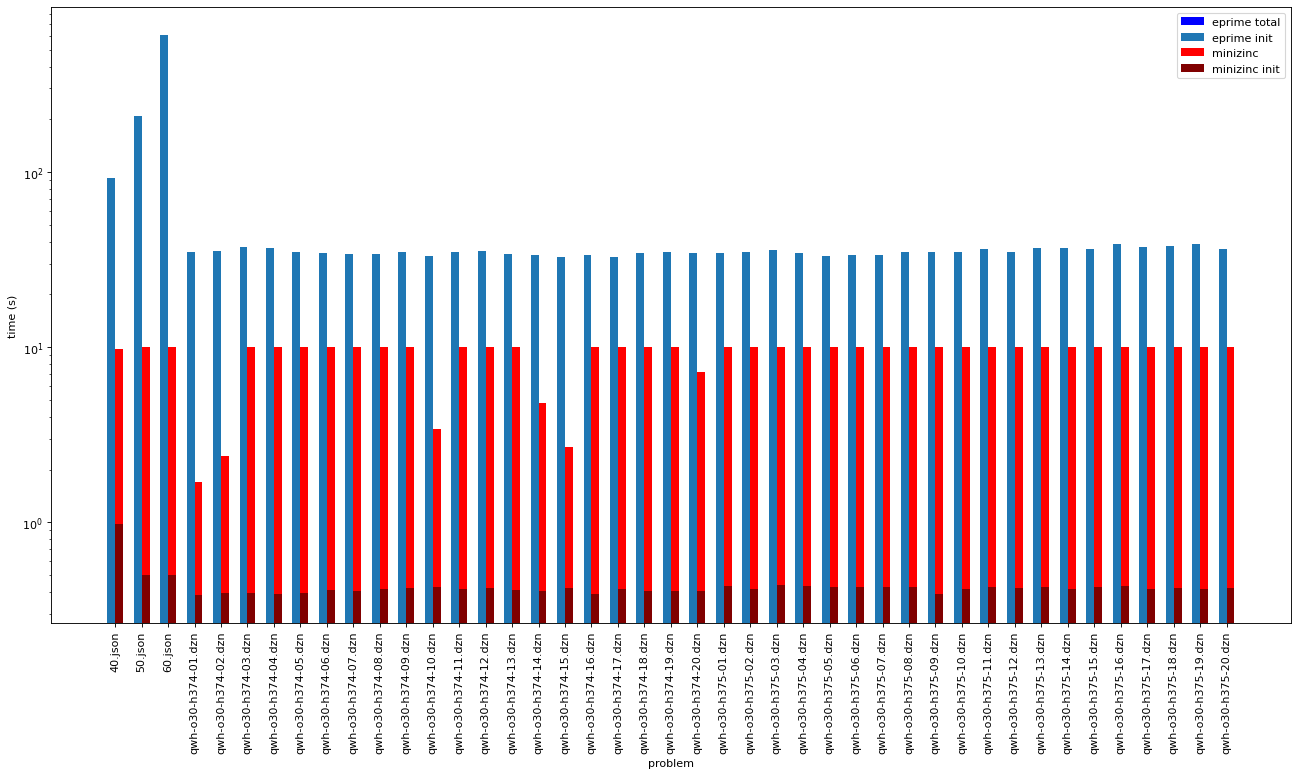

In [37]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

def getData(dataToExtract):
    # print(dataToExtract)
    xData, yData = zip(*sorted(dataToExtract))
    extractedY = []
    for i in dataKeys:
        extractedY.append(list(map(lambda y : y[i], yData)))
        if i != "timeout":
            extractedY.append(list(map(lambda y : y[i+"_stdev"], yData)))
    # yTime =  
    # yInit = list(map(lambda x : x["initTime"], yData))
    # ySolverTime = list(map(lambda x : x["solveTime"], yData))
    # yCompleted = list(map(lambda x : x["timeout"], yData))
    # yTime, ySolverTime, yInit, yCompleted)
    return (xData, *extractedY)



eprimeX, eprimeTime, eprimeTimeStdDev, eprimeSolverTime, eprimeSolverTimeStd, eprimeInit, eprimeInitStd, eprimeCompleted = getData(eprimeData["quasigroupOcc_free_chuffed"]["O3_S2"])
minizincX, minizincTime, minizincTimeStd, minizincSolverTime, minizincSolverStd, minizincInit, mznInitStd, minizincCompleted = getData(minizincData["quasigroupOcc_free_chuffed"])
# minizincX, minizincTime, minizincInit, minizincCompleted = getData(eprimeData[quasigroup]["O0_S0"])
# eprimeCseX, eprimeCseTime, eprimeCseInit = getData(eprimeCseData[wordpress])

# print(set(minizincX).difference(set(eprimeX)))
# print(set(eprimeX).difference(set(minizincX)))
# print(len(eprimeX))
# print(len(minizincX))

eprimeX = list(map(str, eprimeX))
minizincX = list(map(str, minizincX))

ind = np.arange(len(eprimeX))
width = 0.3

figure(figsize=(20, 10), dpi=80)
# plt.bar(ind-width, eprimeCseTime, width, label="eprime x-cse total", color="blue")
# plt.bar(ind-width, eprimeCseInit, width, label="eprime x-cse init")
plt.bar(ind, eprimeTime, width, label="eprime total", color="blue")
plt.bar(ind, eprimeInit, width, label="eprime init")
plt.bar(ind+width, minizincTime, width, label="minizinc", color="red")
plt.bar(ind+width, minizincInit, width, label="minizinc init" , color="maroon")
# plt.scatter(eprimeX, eprimeY, label="eprime")
# plt.scatter(minizincX, minizincY, label="minizinc")
plt.legend(loc="best")
plt.xticks(ind+width/2, minizincX)
plt.xticks(rotation = 90)
plt.xlabel("problem")
plt.ylabel("time (s)")
plt.yscale("log")

quasigroup_noFree_chuffed
quasigroup_free_chuffed
quasigroup_noFree_gecode
quasigroup_free_gecode
quasigroupOcc_noFree_chuffed
quasigroupOcc_free_chuffed
quasigroupOcc_noFree_gecode
quasigroupOcc_free_gecode
wordpress_noFree_chuffed
wordpress_free_chuffed
wordpress_noFree_gecode
wordpress_free_gecode
wordpressNoSymm_noFree_chuffed
wordpressNoSymm_free_chuffed
wordpressNoSymm_noFree_gecode
wordpressNoSymm_free_gecode
tournament_noFree_chuffed
tournament_free_chuffed
tournament_noFree_gecode
tournament_free_gecode
mspsp_noFree_chuffed
mspsp_free_chuffed
mspsp_noFree_gecode
mspsp_free_gecode
cvrptw_noFree_chuffed
cvrptw_free_chuffed
cvrptw_noFree_gecode
cvrptw_free_gecode
roster_noFree_chuffed
roster_free_chuffed
roster_noFree_gecode
roster_free_gecode


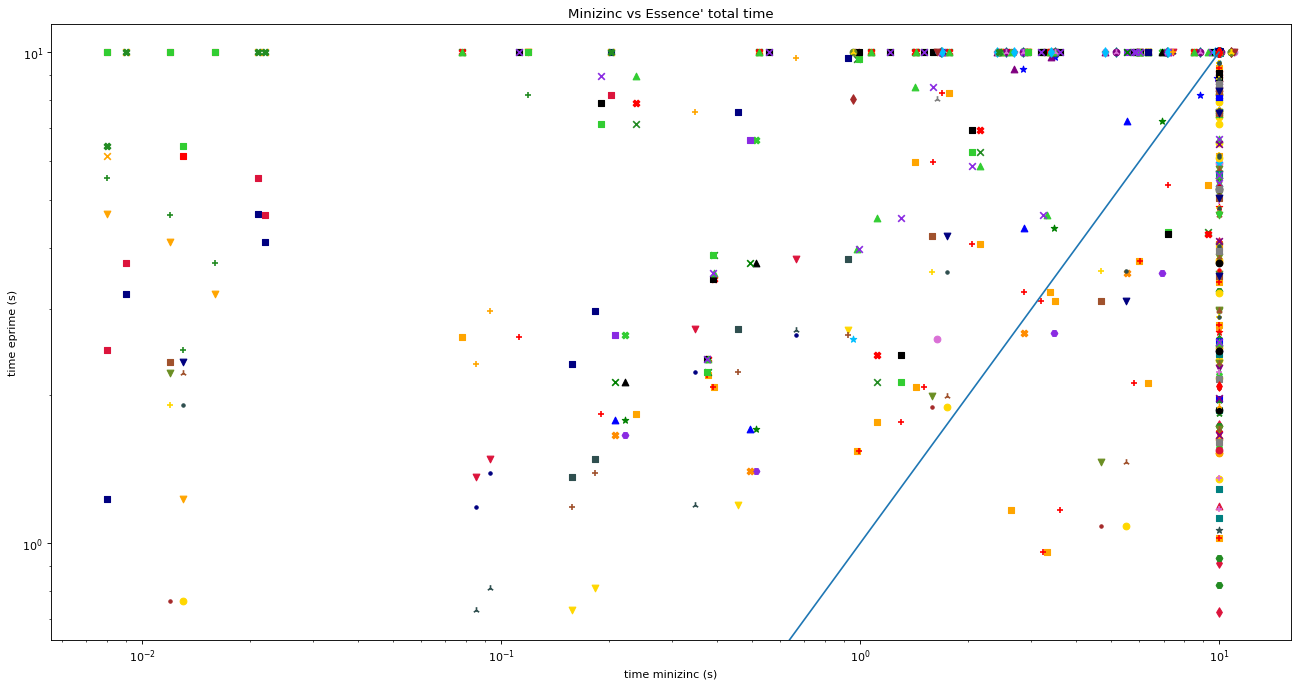

In [38]:
import itertools

allEprimeTimings = {}
allMinizincTimings = {}

problemIndex = 0
timingIndex = 1
timingStdevIndex = 2
solverTimeIndex = 3
solverStdevIndex = 4
initIndex = 5
initIndexStdev = 6
timeoutIndex = 7

titleNames = {}
titleNames[timingIndex] = "total time"
titleNames[timingStdevIndex] = "total time standard deviation" 
titleNames[solverTimeIndex] = "solver time"
titleNames[solverStdevIndex] = "solver time standard deviation"
titleNames[initIndex] = "initialization time"
titleNames[initIndexStdev] = "initialization time standard deviation"
titleNames[timeoutIndex] = "timeout"

for i in problems:
    print(i)
    allMinizincTimings[i] = getData(minizincData[i])
    allEprimeTimings[i] = {}
    for j in optimisations:
        allEprimeTimings[i][j] = getData(eprimeData[i][j])

marker = itertools.cycle((',', '+', '.', 'o', '*', '^', 'x', 's', 'v','2', 'd', 'H', 'X'))
color = itertools.cycle(('orange', 'red', 'black', 'green', 'blue', 'purple', 'grey', "brown", "gold", "darkslategray", "crimson", "forestgreen", "limegreen", "blueviolet", "darkorange", "teal", "orchid", "deepskyblue", "olivedrab", "sienna", "navy"))

# for i in problems:
#     plt.scatter(allMinizincTimings[i][timingIndex], allMinizincTimings[i][timingIndex], label="minizinc_"+i)
#     for j in optimisations:
#         plt.scatter(allEprimeTimings[i][j][timingIndex], allEprimeTimings[i][j][timingIndex], label=i + "_" + j)

def setupPlotSolverSolver(graphTitle="Minizinc vs Essence'", indexOfInterest=timingIndex):
    # fig = plt.figure(figsize=(20, 20), dpi=80)
    figure(figsize=(20, 10), dpi=80)
    # ax = plt.axes()
    plt.plot([0, timeoutTimeSecs], [0, timeoutTimeSecs])
    plt.xlabel("time minizinc (s)")
    plt.ylabel("time eprime (s)")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(graphTitle + " " + titleNames[indexOfInterest])

# wordpress timingIndex, timing out
# tournament timingIndex, notably only 20f, 20h
# roster timingIndex, timing out
# cvrptw everything times out
# mspsp out-performed by minizinc on init and solver time
# quasigroup, all over the place

def createOccurencePlot(opt, occProblem, explicitProblem, annotate=False, indexOfInterest=timingIndex, errorbars=False):
    x, y = occProblem[indexOfInterest], explicitProblem[indexOfInterest]
    chosenColor = next(color)
    plt.xlabel("time occurrence (s)")
    plt.ylabel("time explicit (s)")
    plt.scatter(x, y, label= quasigroup + " " + opt, marker=next(marker), color=chosenColor)
    if annotate:
        for j in range(len(occProblem[problemIndex])):
            plt.annotate(occProblem[problemIndex][j], (occProblem[indexOfInterest][j], explicitProblem[indexOfInterest][j]))
    if errorbars:
        stdDevLoc = indexOfInterest+1
        plt.errorbar(x, y, yerr=explicitProblem[stdDevLoc], xerr=occProblem[stdDevLoc], ls='none', color=chosenColor, lw=1)



def createPlot(opt, problemList, annotate=False, errorbars=False, indexOfInterest=timingIndex):
    for i in problemList:
        minizincProblem = allMinizincTimings[i]
        essenceProblem = allEprimeTimings[i][opt]
        # print(set(allMinizincTimings[i][problemIndex]).difference(set(allEprimeTimings[i][opt][problemIndex])))
        # print(set(allEprimeTimings[i][opt][problemIndex]).difference(set(allMinizincTimings[i][problemIndex])))
        x, y = minizincProblem[indexOfInterest], essenceProblem[indexOfInterest]
        chosenColor = next(color)
        if errorbars:
            stdDevLoc = indexOfInterest+1
            plt.errorbar(x, y, yerr=essenceProblem[stdDevLoc], 
            xerr=minizincProblem[stdDevLoc], label= i + " " + opt, fmt=next(marker), ls='none', color=chosenColor, lw=0.5, capsize=2)
        else:
            plt.scatter(x, y, label= i + " " + opt, marker=next(marker), color=chosenColor)
        if annotate:
            for j in range(len(minizincProblem[problemIndex])):
                plt.annotate(minizincProblem[problemIndex][j], (minizincProblem[indexOfInterest][j], essenceProblem[indexOfInterest][j]))
    if len(problemList) == 1:
        plt.title("Minizinc vs Essence' " + problemList[0] + " " + titleNames[indexOfInterest])

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, problems)
# box = plt.get_position()
# plt.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc="best")

['quasigroup_noFree_chuffed', 'quasigroup_free_chuffed', 'quasigroupOcc_noFree_chuffed', 'quasigroupOcc_free_chuffed', 'wordpress_noFree_chuffed', 'wordpress_free_chuffed', 'wordpressNoSymm_noFree_chuffed', 'wordpressNoSymm_free_chuffed', 'tournament_noFree_chuffed', 'tournament_free_chuffed', 'mspsp_noFree_chuffed', 'mspsp_free_chuffed', 'cvrptw_noFree_chuffed', 'cvrptw_free_chuffed', 'roster_noFree_chuffed', 'roster_free_chuffed']


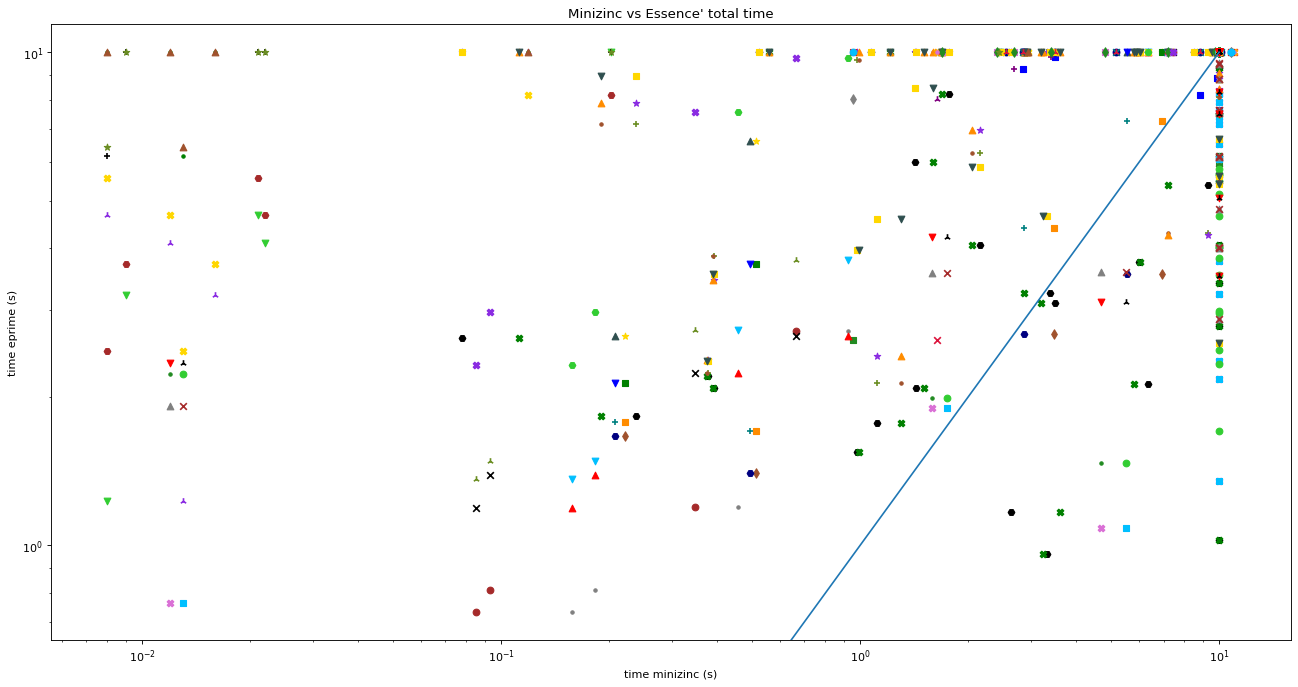

In [39]:
print(chuffedProblems)
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, chuffedProblems)
# plt.legend(loc="best")

KeyError: 'roster'

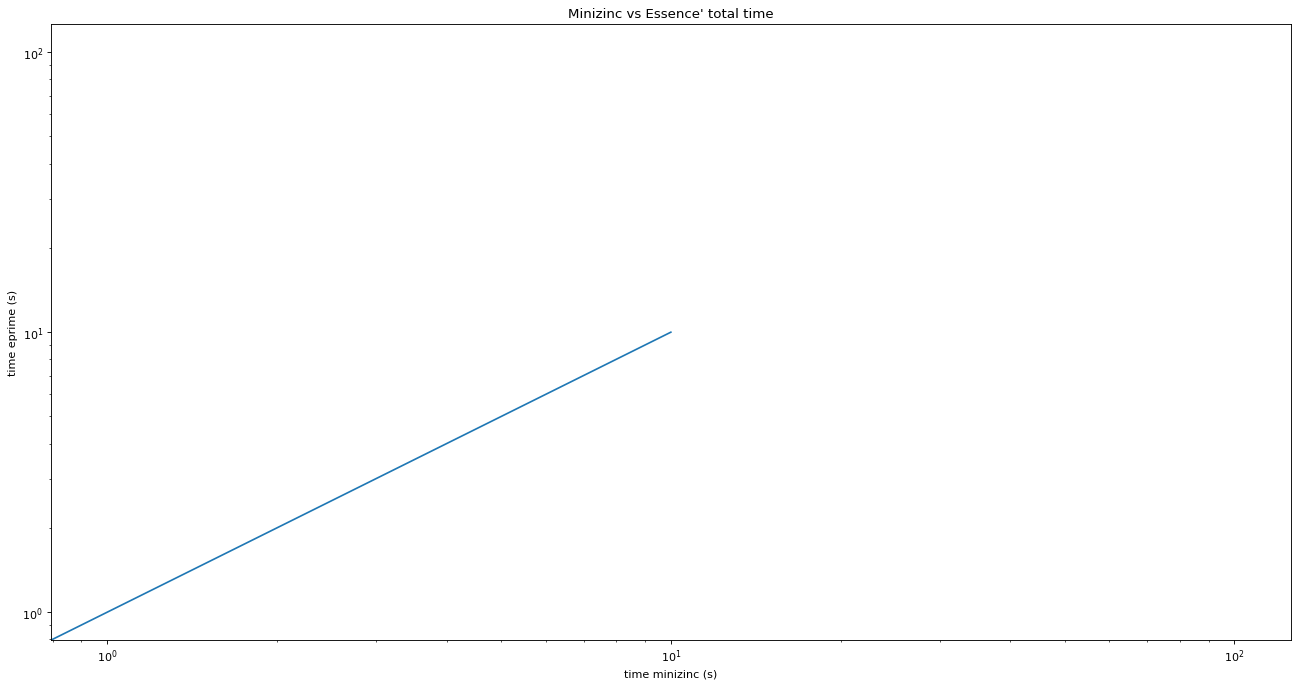

In [40]:
setupPlotSolverSolver()
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[roster][j], allEprimeTimings[rosterFree][j], errorbars=True)


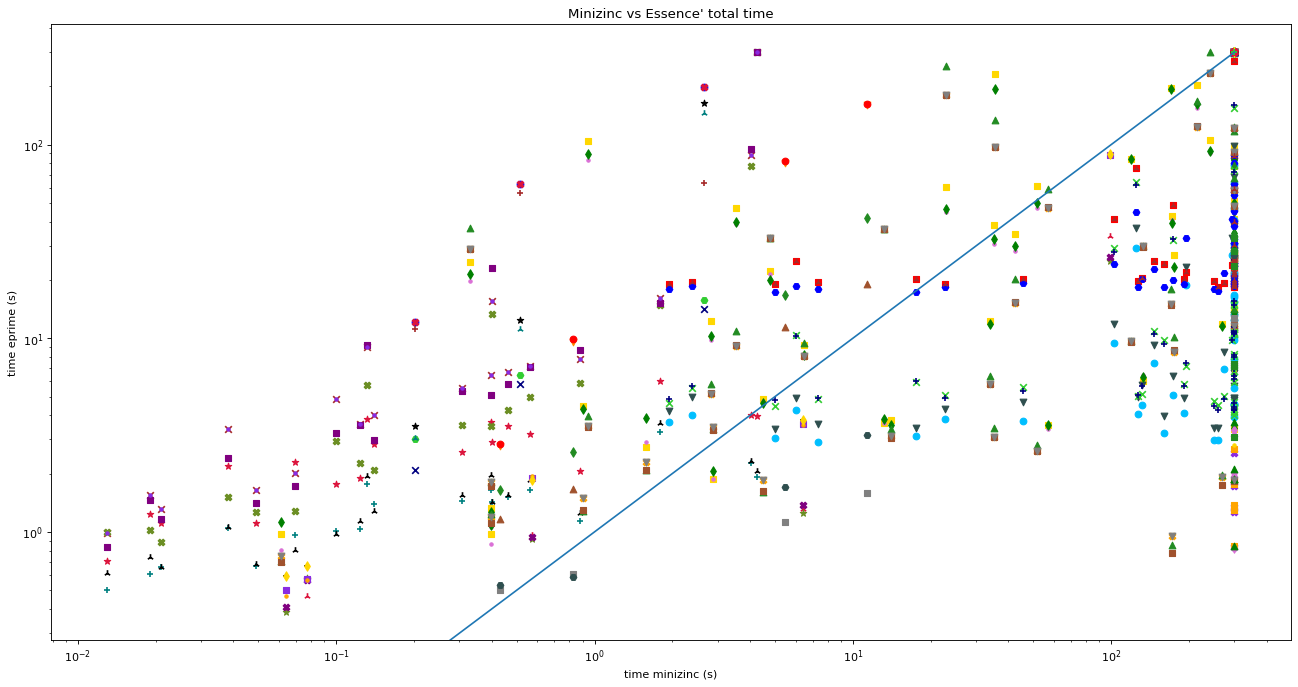

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, freeProblems)
# plt.legend(loc="best")

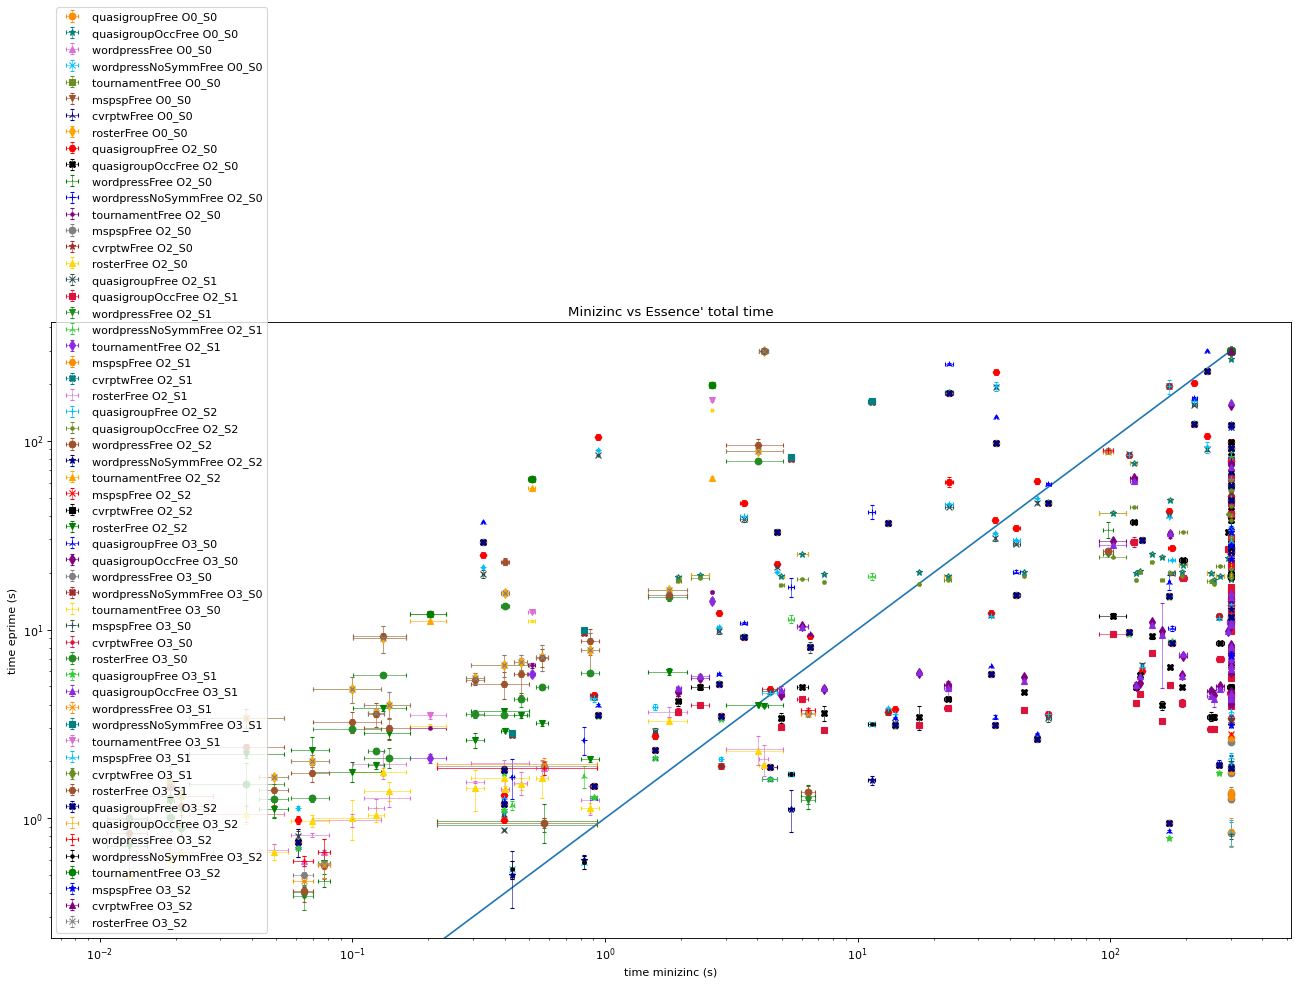

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, freeProblems, errorbars=True)
plt.legend(loc="best")
# plt.savefig('TEST.svg', bbox_inches='tight', format='svg')

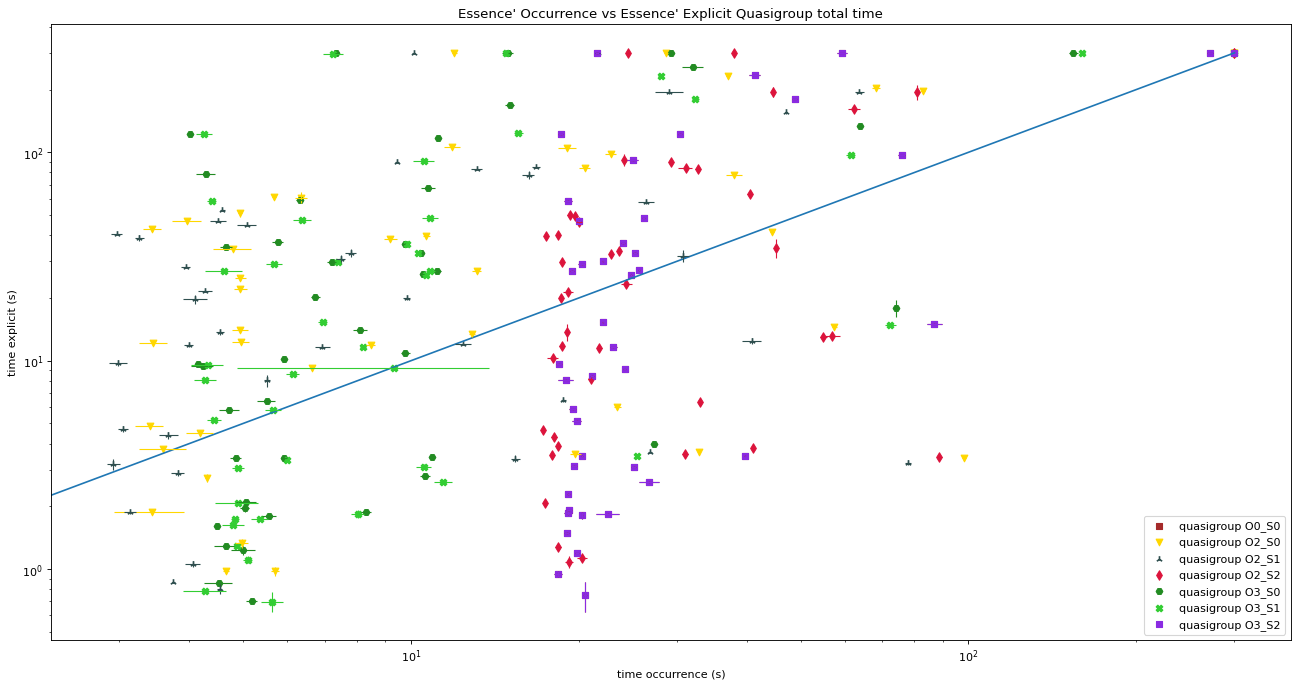

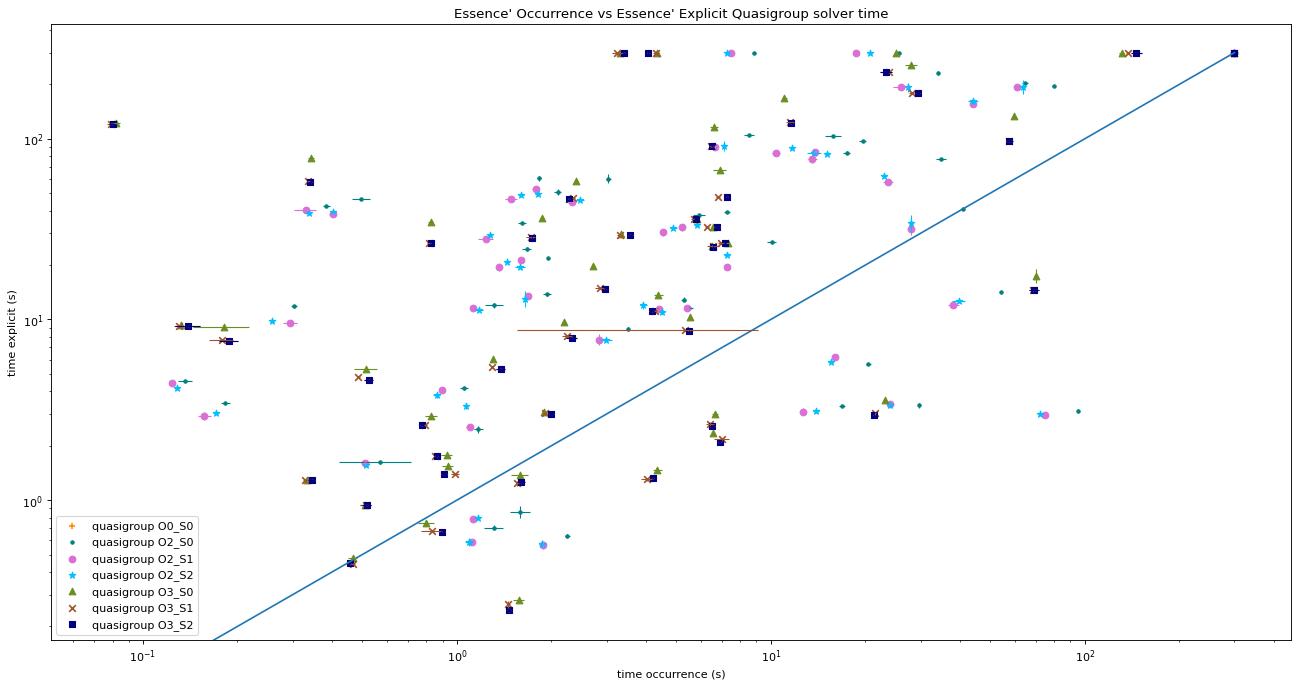

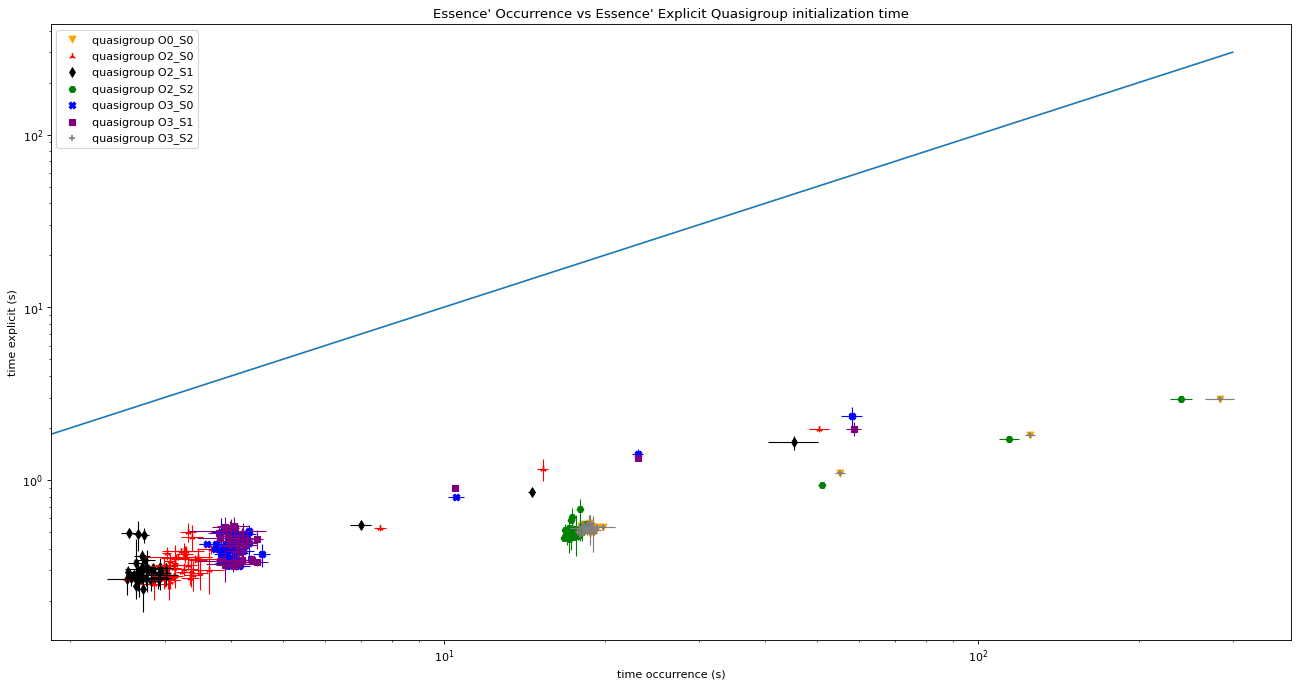

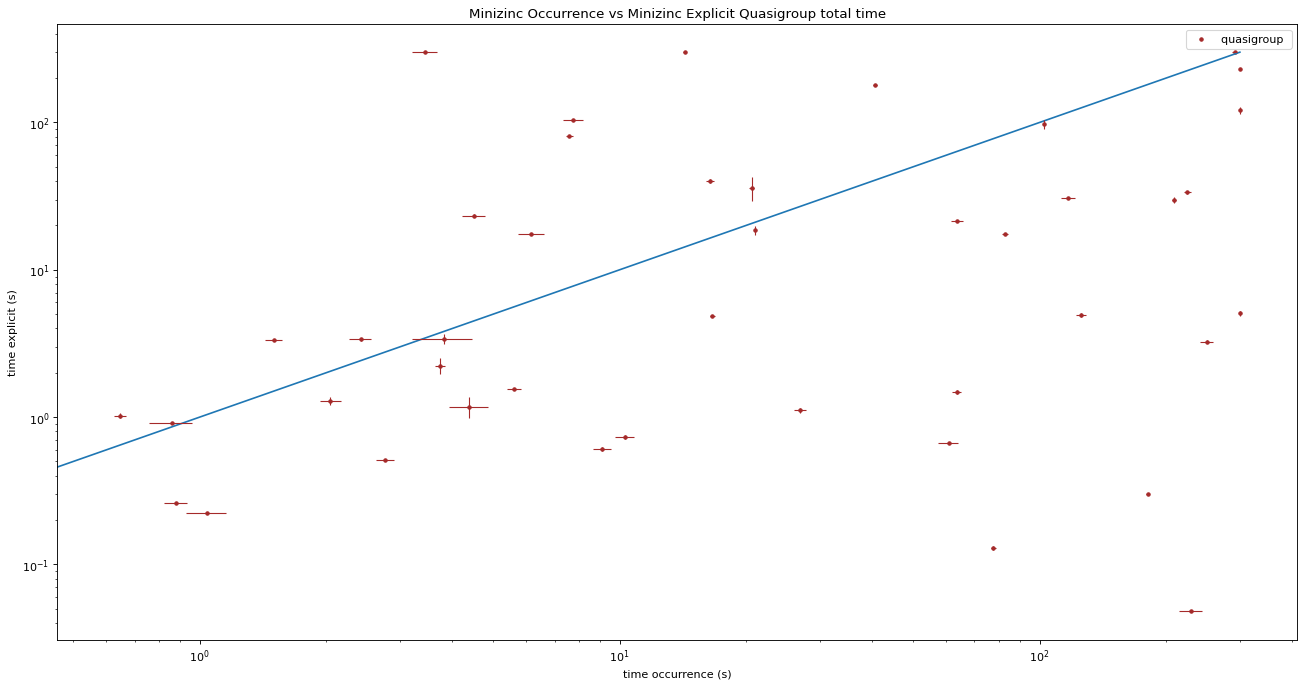

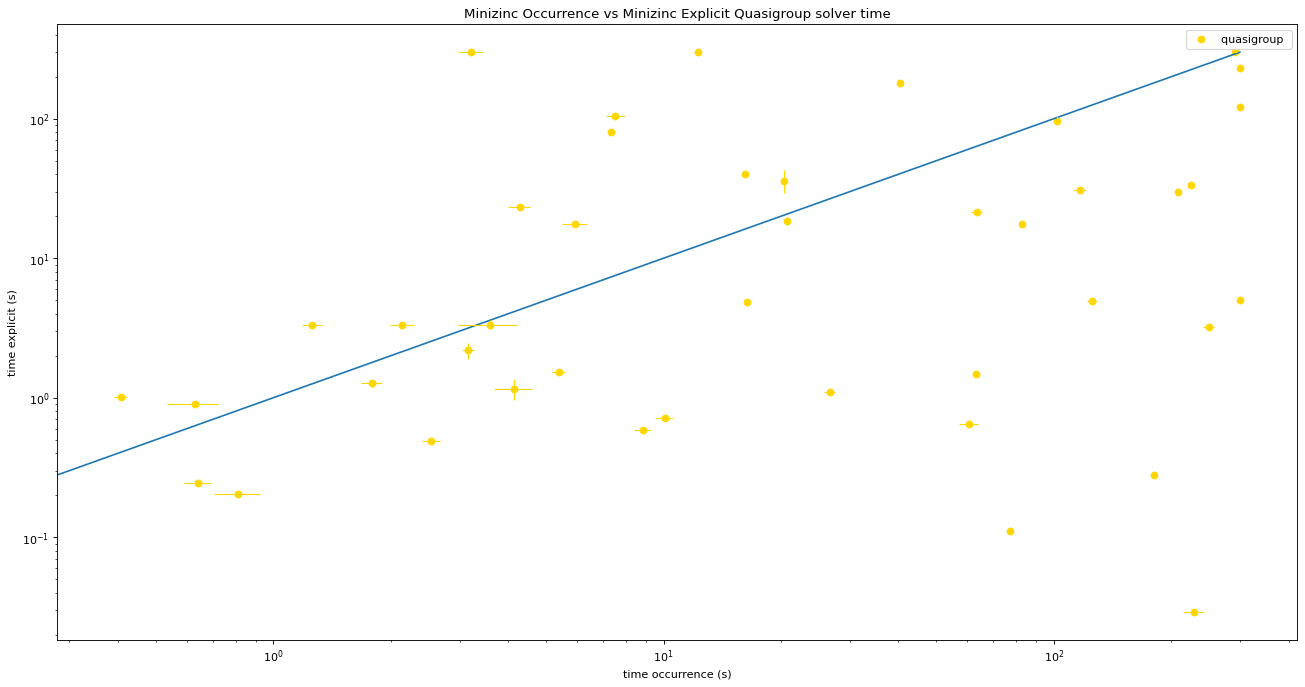

In [ ]:
setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup")
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allEprimeTimings[quasigroup][j], errorbars=True)
plt.legend(loc="best")

setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", solverTimeIndex)
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allEprimeTimings[quasigroup][j], indexOfInterest=solverTimeIndex, errorbars=True)
plt.legend(loc="best")

setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", initIndex)
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allEprimeTimings[quasigroup][j], indexOfInterest=initIndex, errorbars=True)
plt.legend(loc="best")

setupPlotSolverSolver("Minizinc Occurrence vs Minizinc Explicit Quasigroup")
createOccurencePlot("", allMinizincTimings[quasigroupOcc], allMinizincTimings[quasigroup], errorbars=True)
plt.legend(loc="best")


setupPlotSolverSolver("Minizinc Occurrence vs Minizinc Explicit Quasigroup", solverTimeIndex)
createOccurencePlot("", allMinizincTimings[quasigroupOcc], allMinizincTimings[quasigroup], indexOfInterest=solverTimeIndex, errorbars=True)
plt.legend(loc="best")


In [ ]:
# setupPlotSolverSolver("Essence' Boolean Occurrence vs Essence' Explicit Quasigroup")
# for j in optimisations:
# # for j in ["O2_S1"]:
#     createOccurencePlot(j, allEprimeTimings[quasigroupBool][j], allEprimeTimings[quasigroup][j])
# # createOccurencePlot("O2_S1")
# plt.legend(loc="best")

# setupPlotSolverSolver("Minizinc Boolean Occurrence vs Minizinc Explicit Quasigroup")
# createOccurencePlot("", allMinizincTimings[quasigroupBool], allMinizincTimings[quasigroup])
# plt.legend(loc="best")

In [ ]:
# setupPlotSolverSolver()
# for j in optimisations:
# # for j in ["O2_S1"]:
#     createOccurencePlot(j, allEprimeTimings[quasigroupBool][j], allEprimeTimings[quasigroupOcc][j])
# # createOccurencePlot("O2_S1")
# plt.legend(loc="best")

# setupPlotSolverSolver()
# createOccurencePlot("", allMinizincTimings[quasigroupBool], allMinizincTimings[quasigroupOcc])
# plt.legend(loc="best")

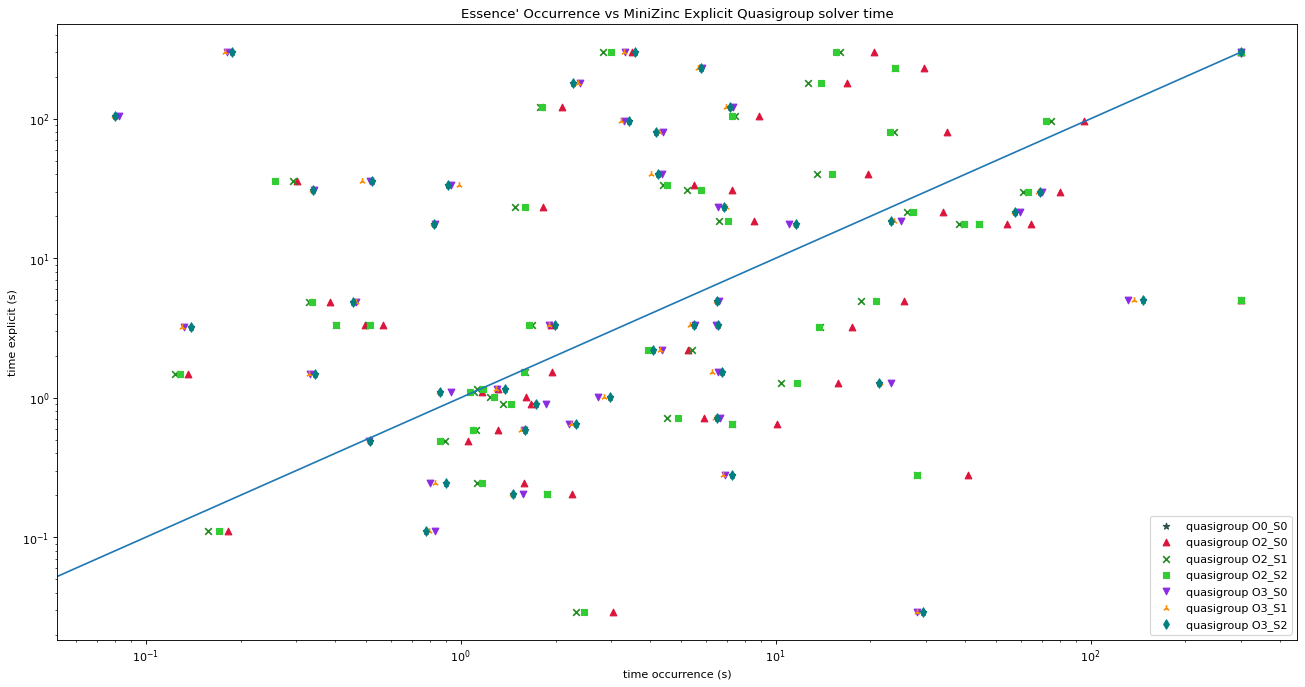

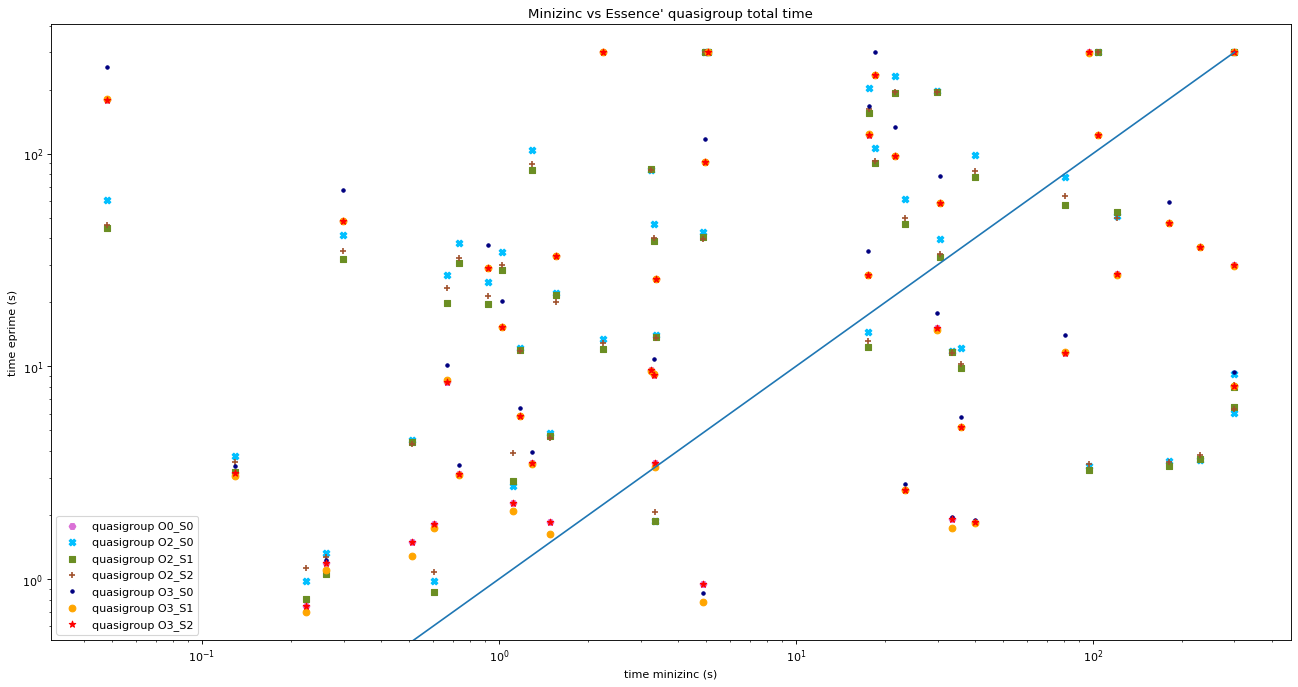

In [ ]:
setupPlotSolverSolver("Essence' Occurrence vs MiniZinc Explicit Quasigroup", solverTimeIndex)
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allMinizincTimings[quasigroup], indexOfInterest=solverTimeIndex)
plt.legend(loc="best")

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [quasigroup])
plt.legend(loc="best")

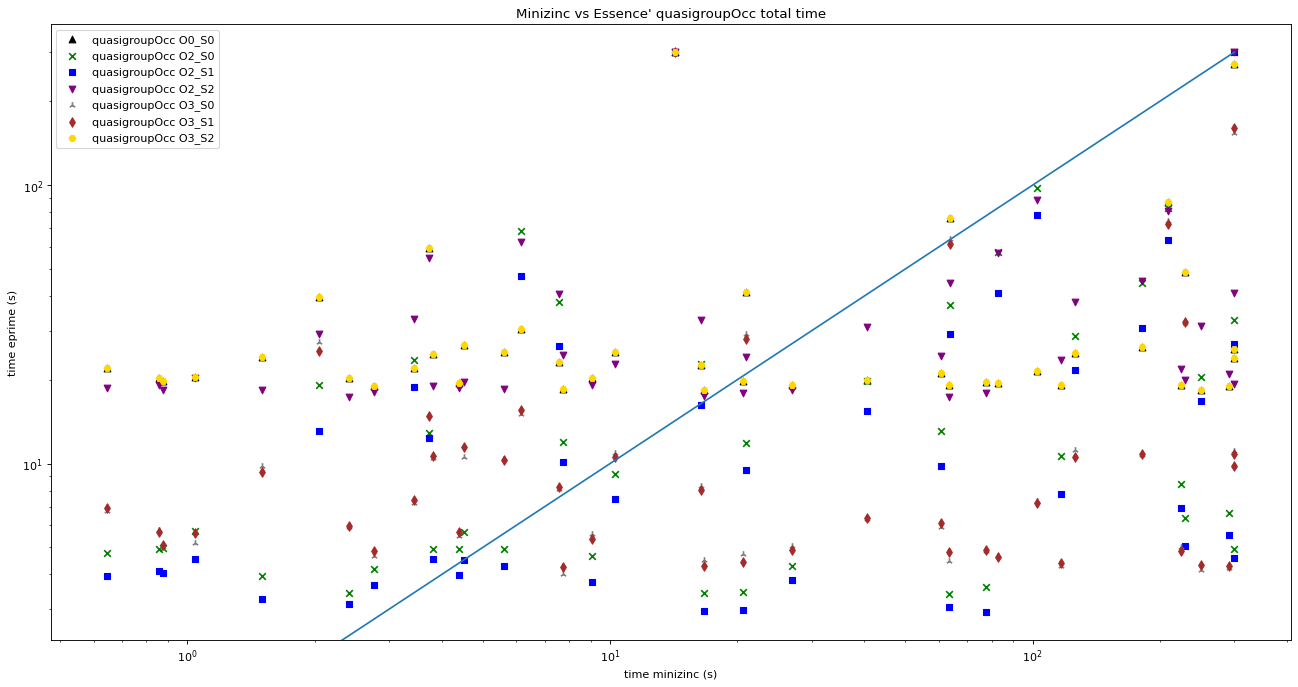

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [quasigroupOcc])
plt.legend(loc="best")

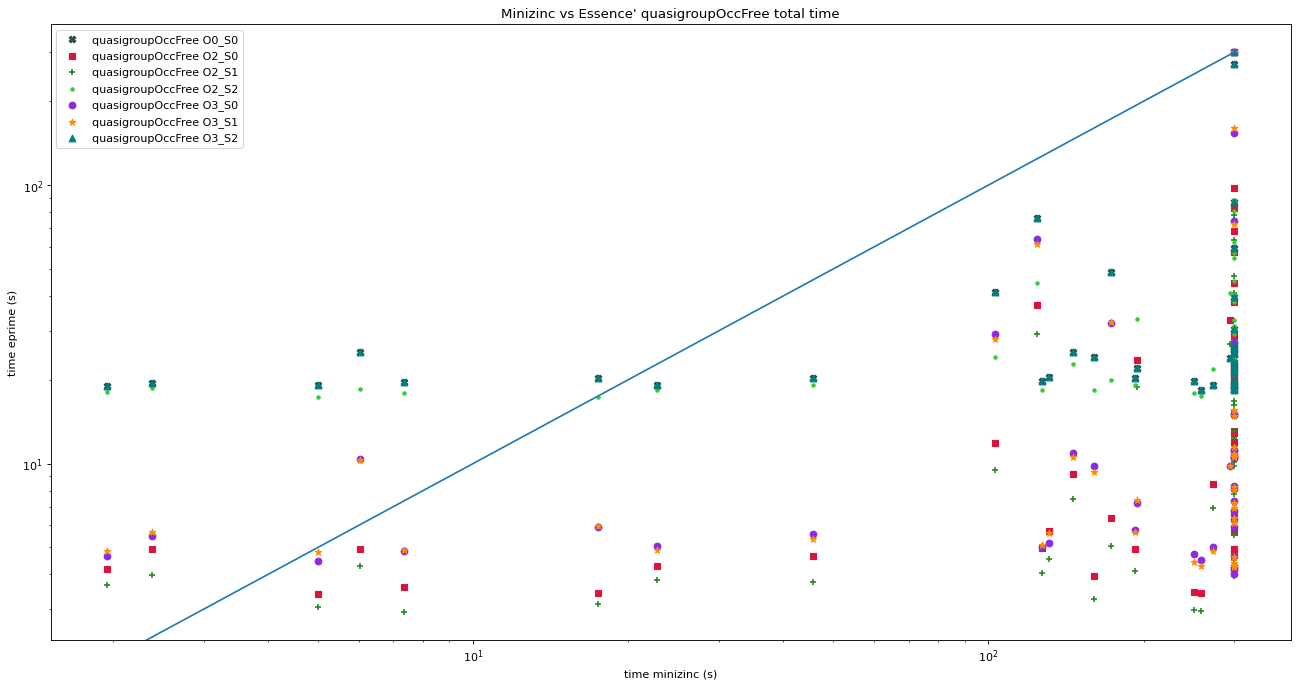

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [quasigroupOcc + "Free"])
plt.legend(loc="best")

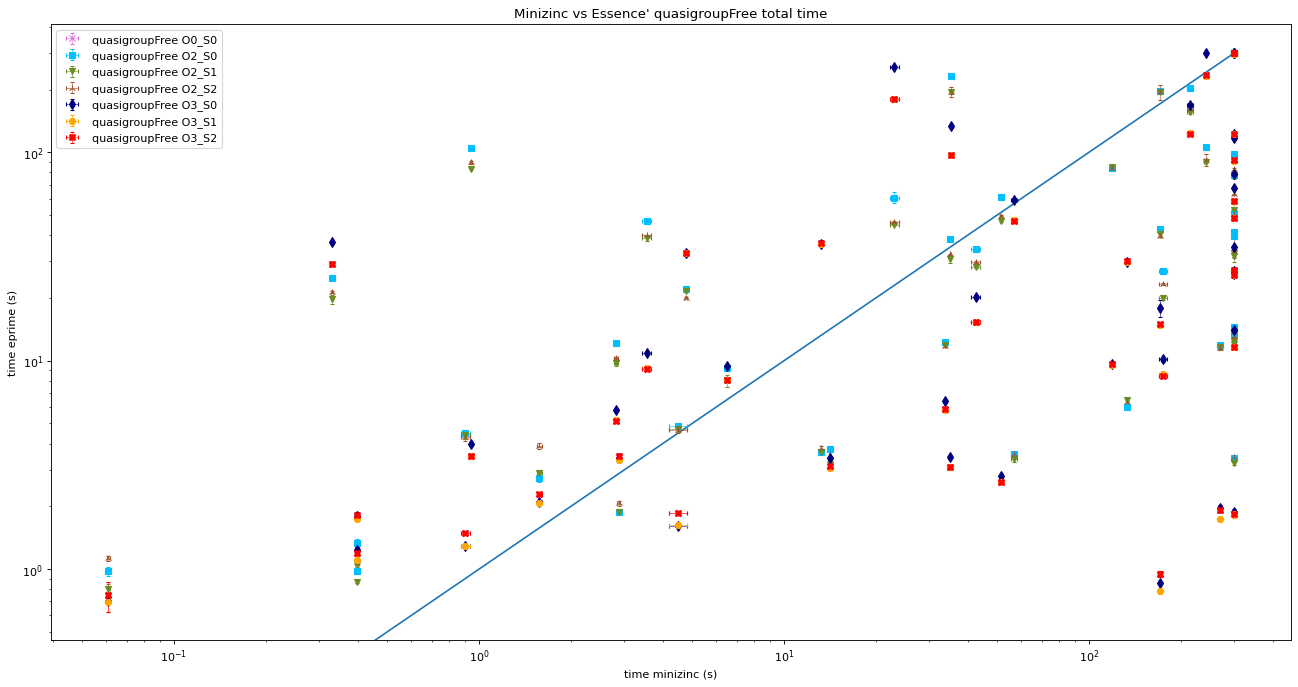

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [quasigroup + "Free"], errorbars=True)
plt.legend(loc="best")

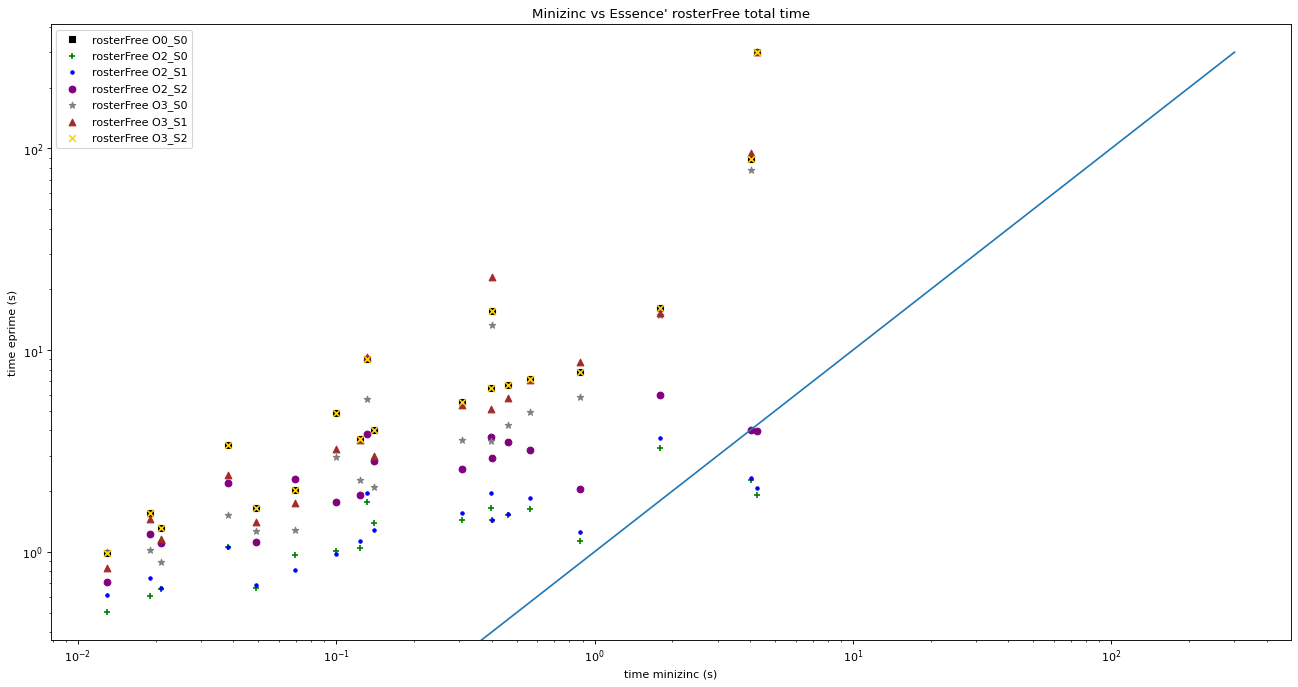

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [rosterFree])
plt.legend(loc="best")

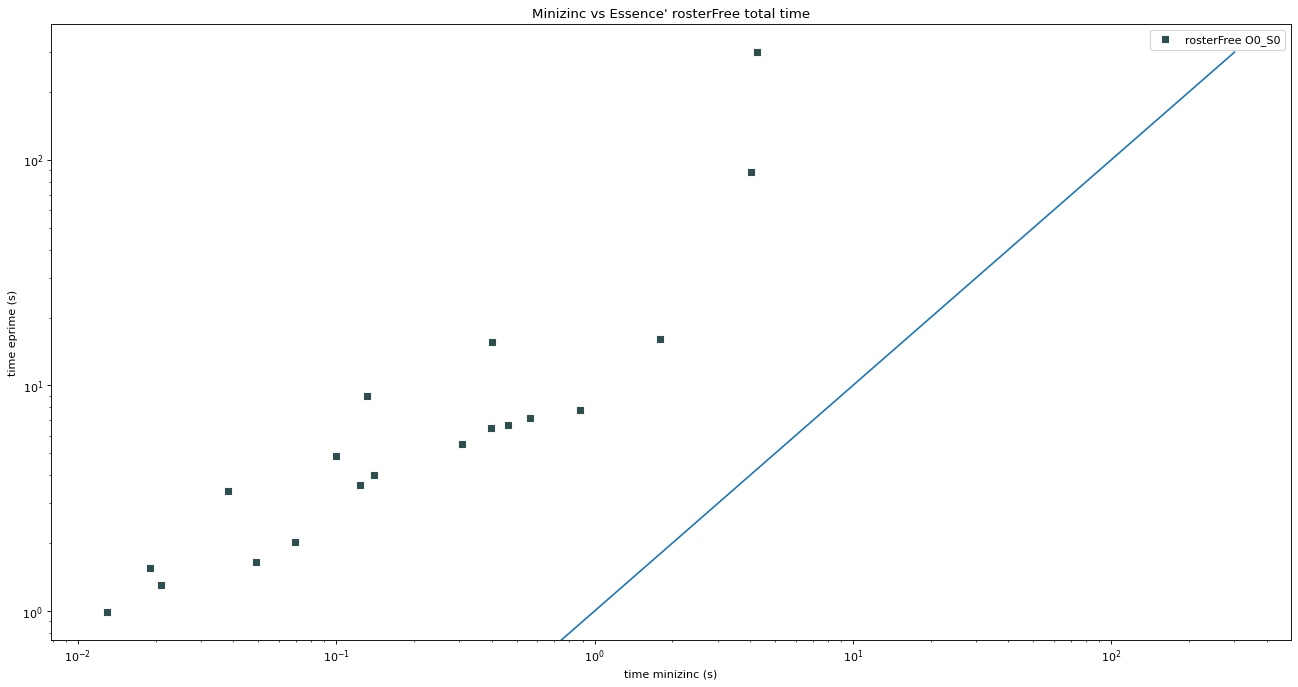

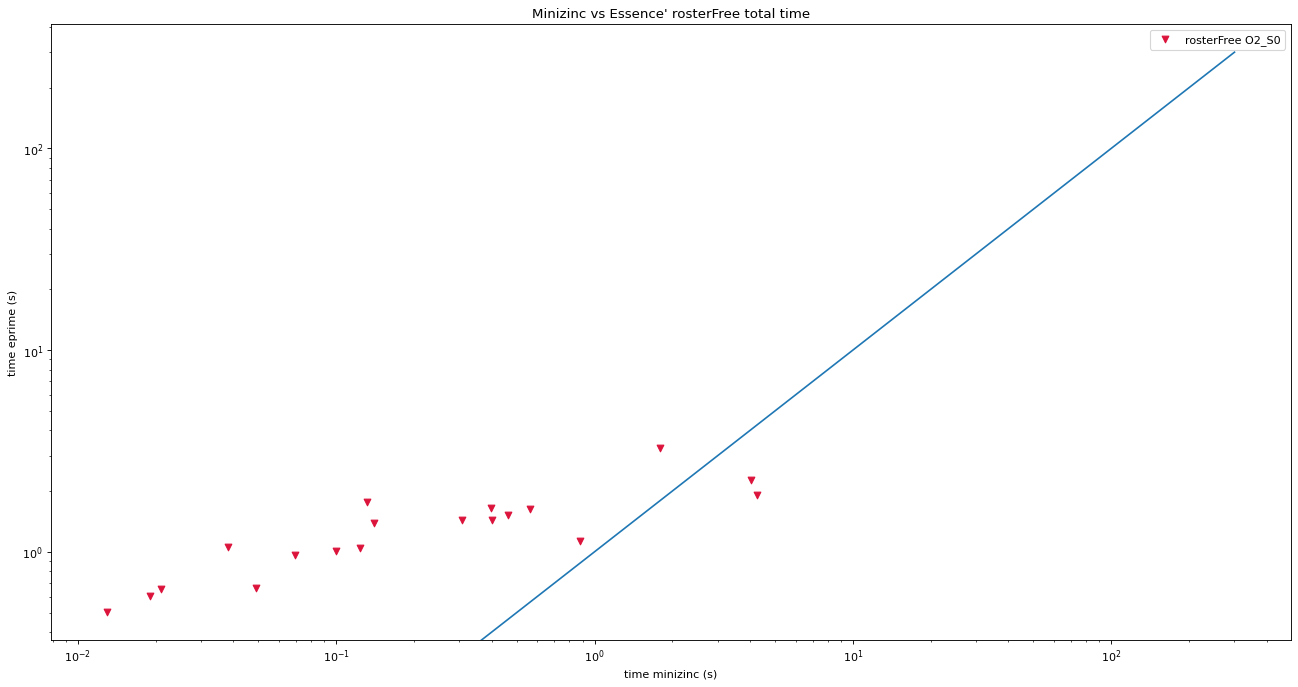

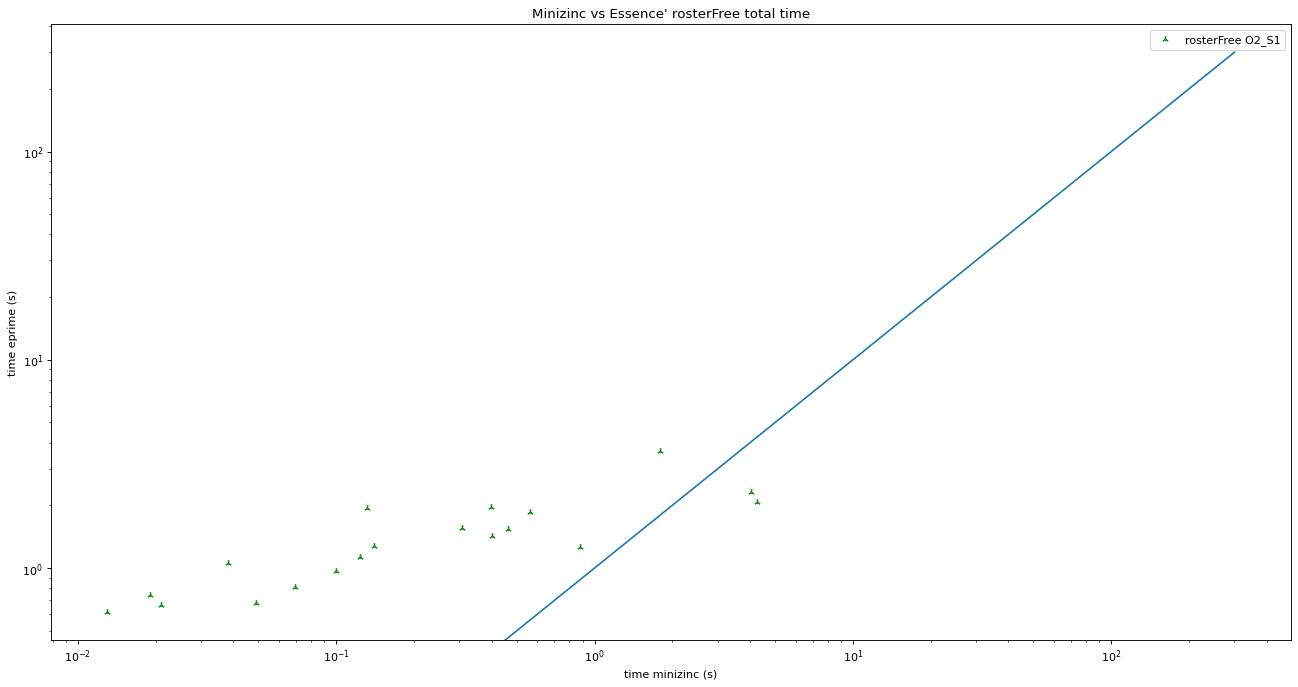

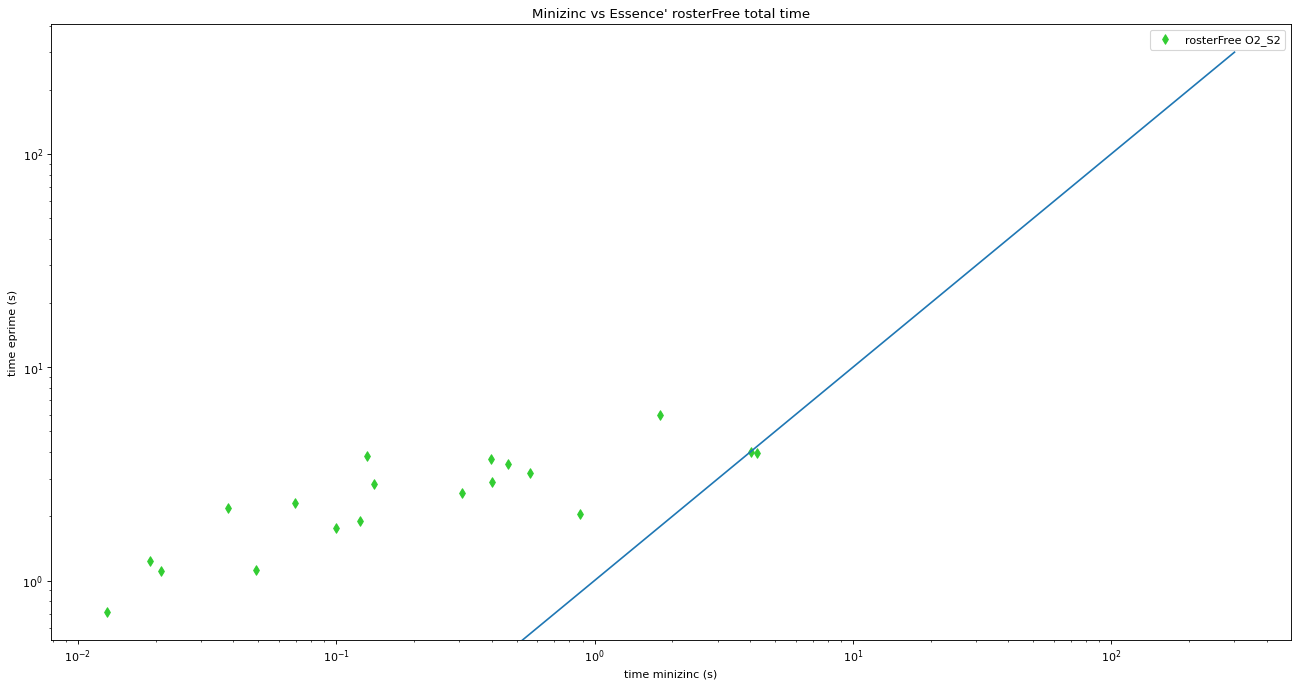

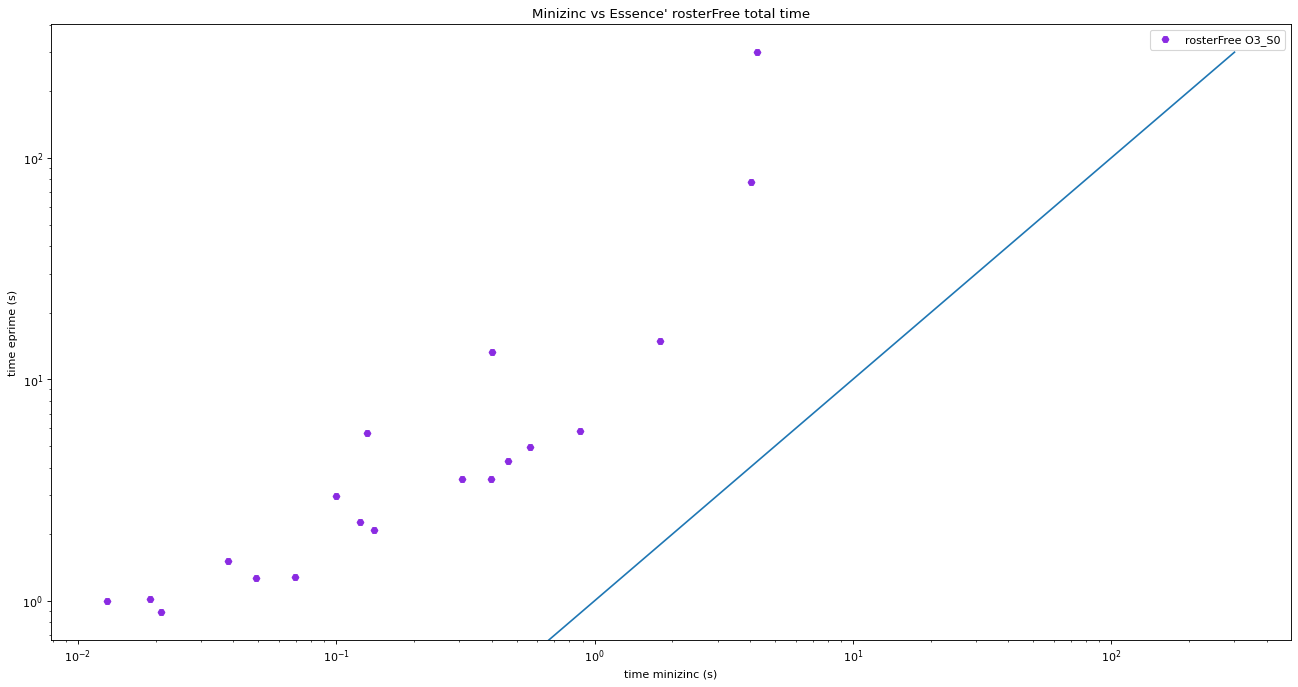

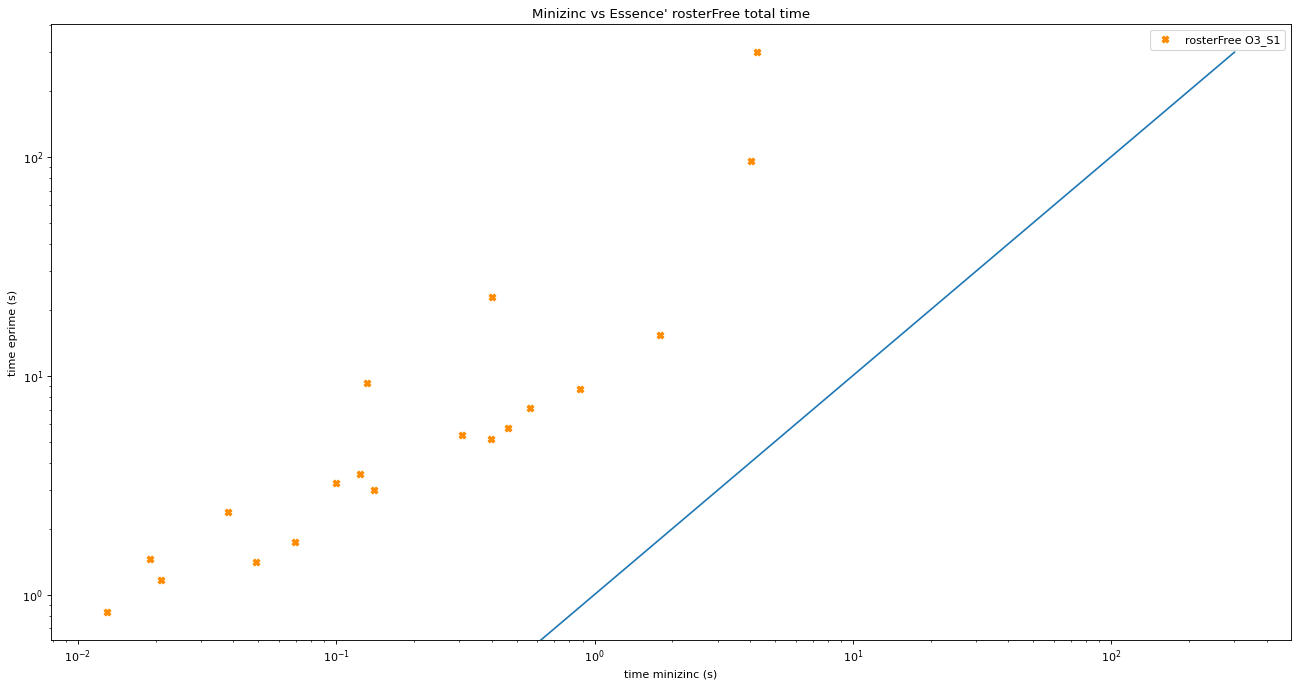

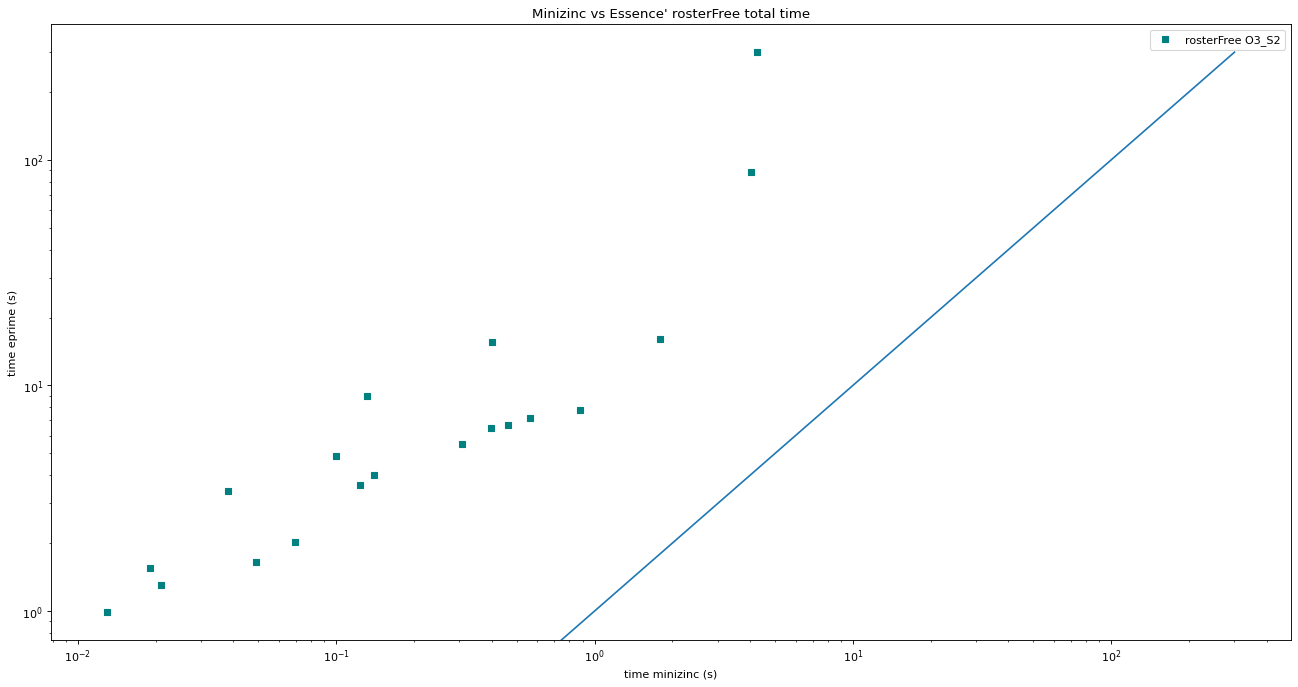

In [ ]:
for i in optimisations:
    setupPlotSolverSolver()
    createPlot(i, [rosterFree])
    plt.legend(loc="best")


/tmp/ipykernel_54668/4258437194.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure(figsize=(20, 10), dpi=80)


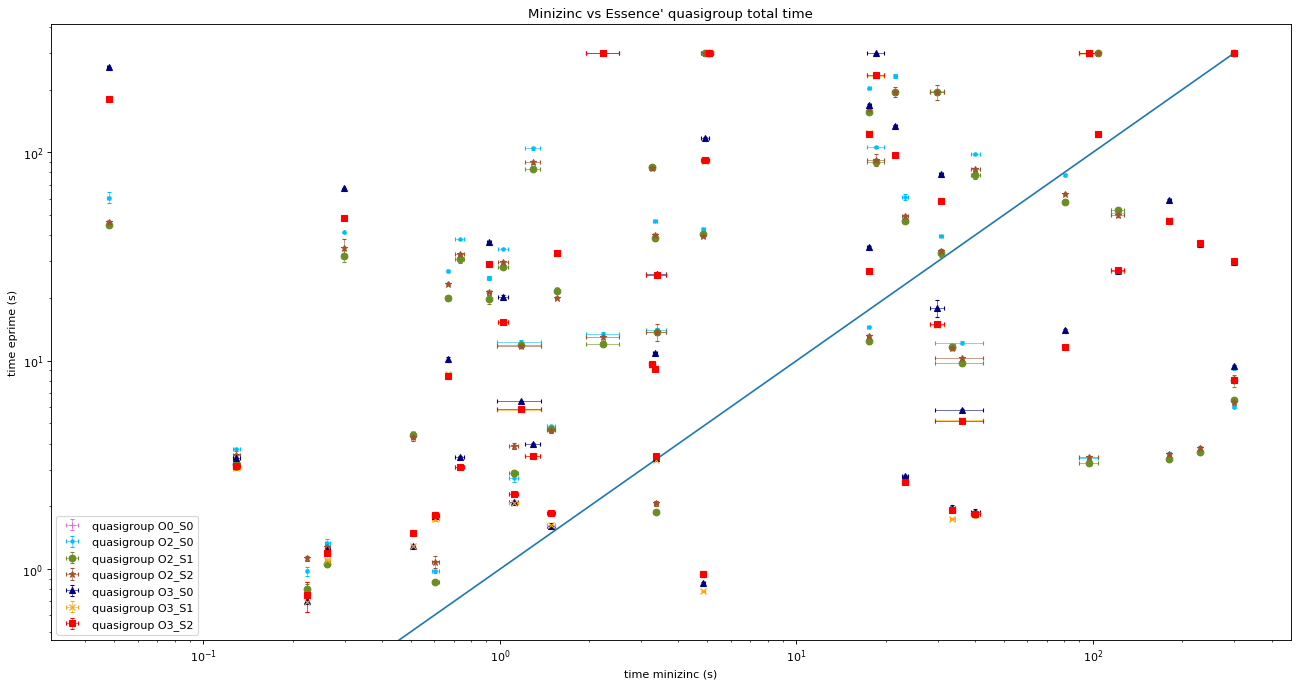

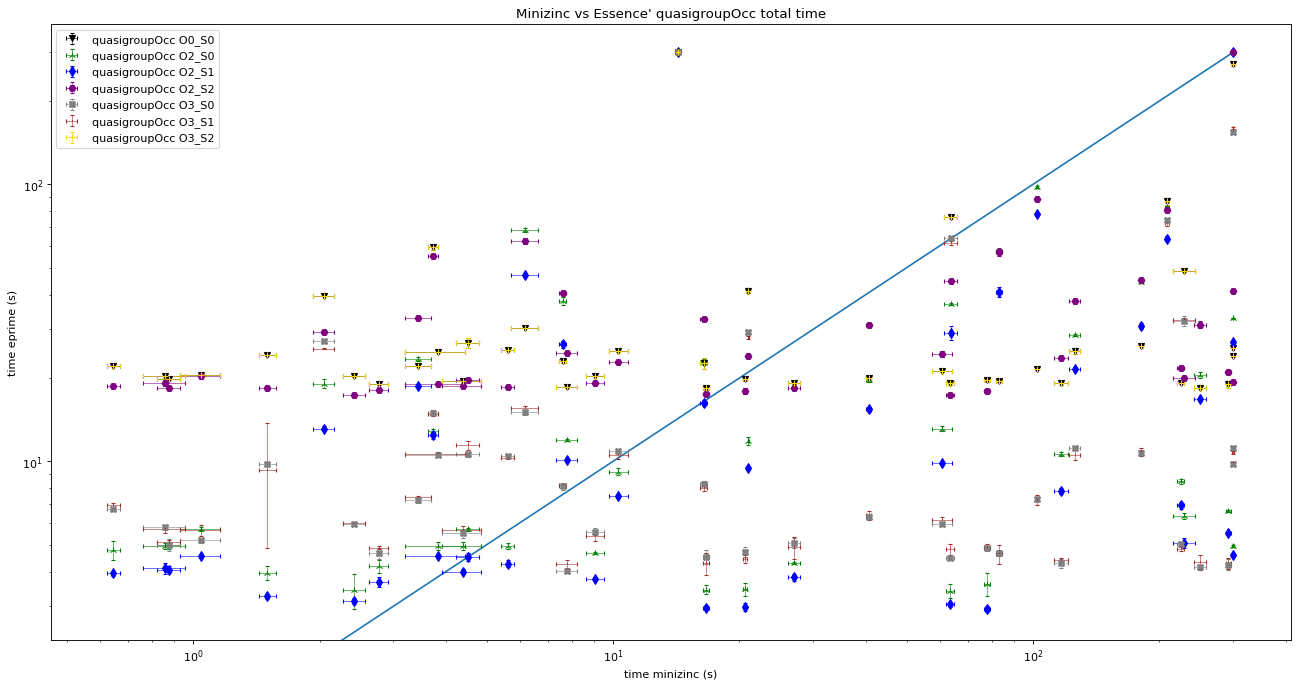

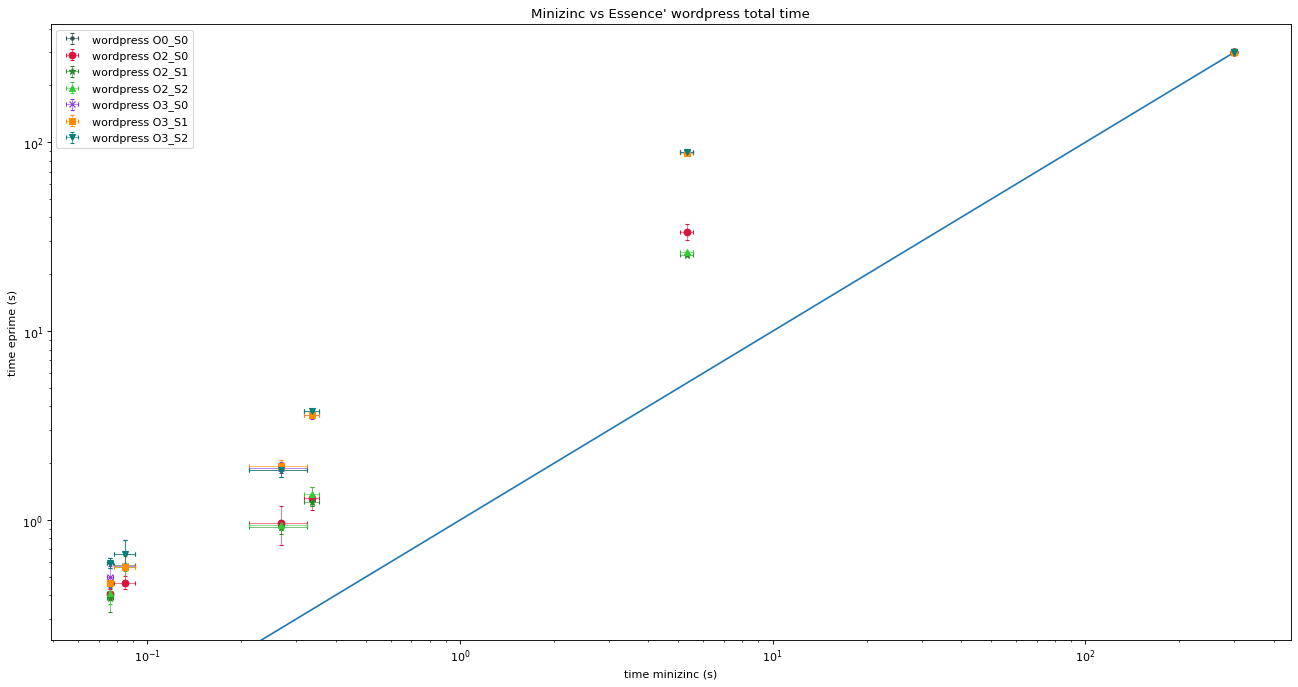

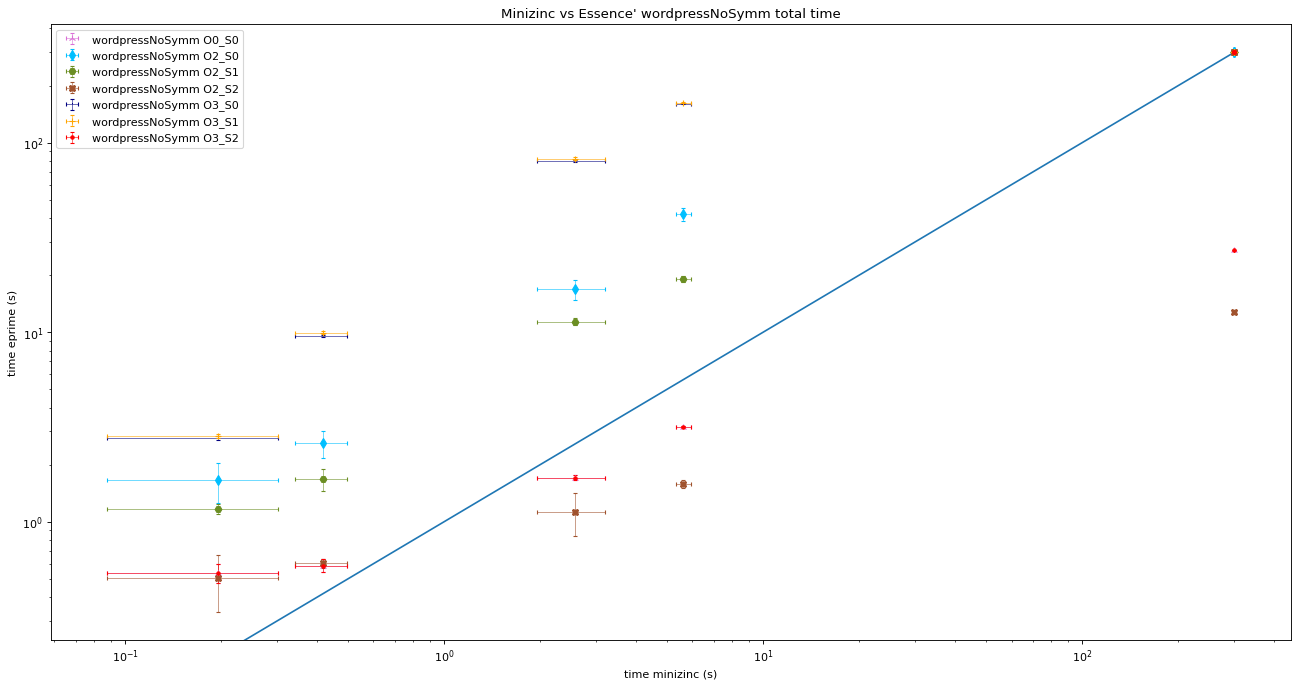

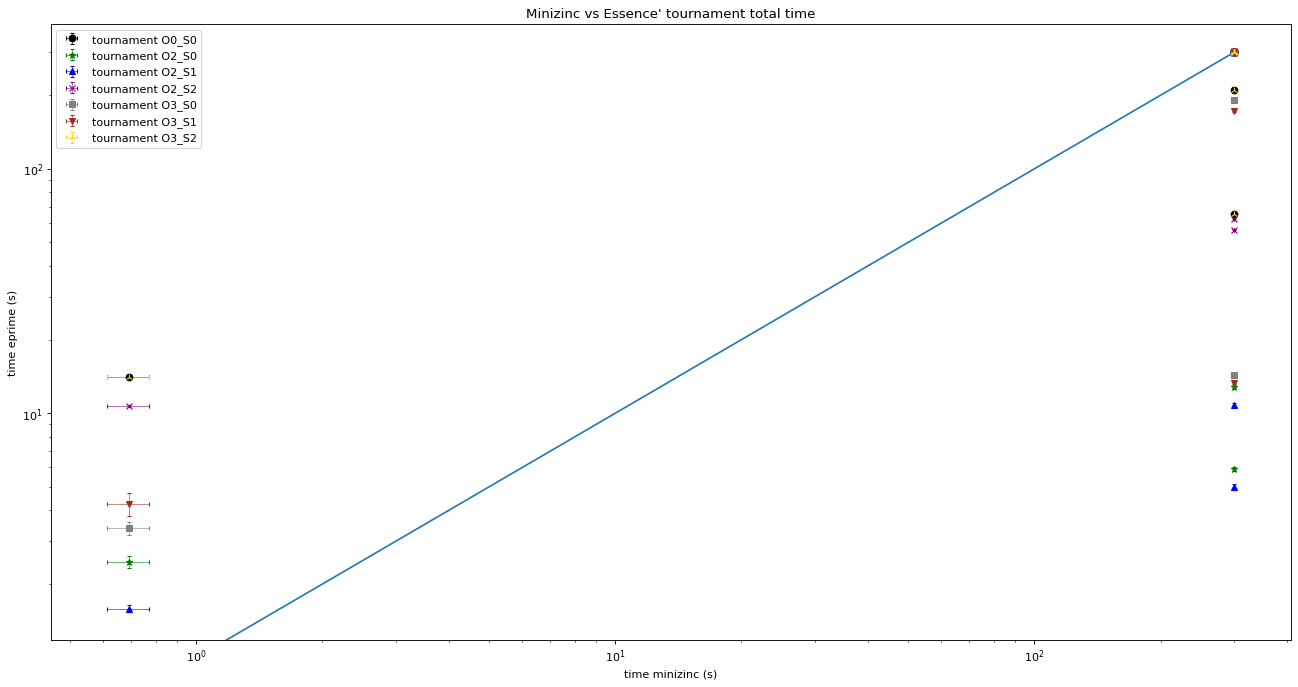

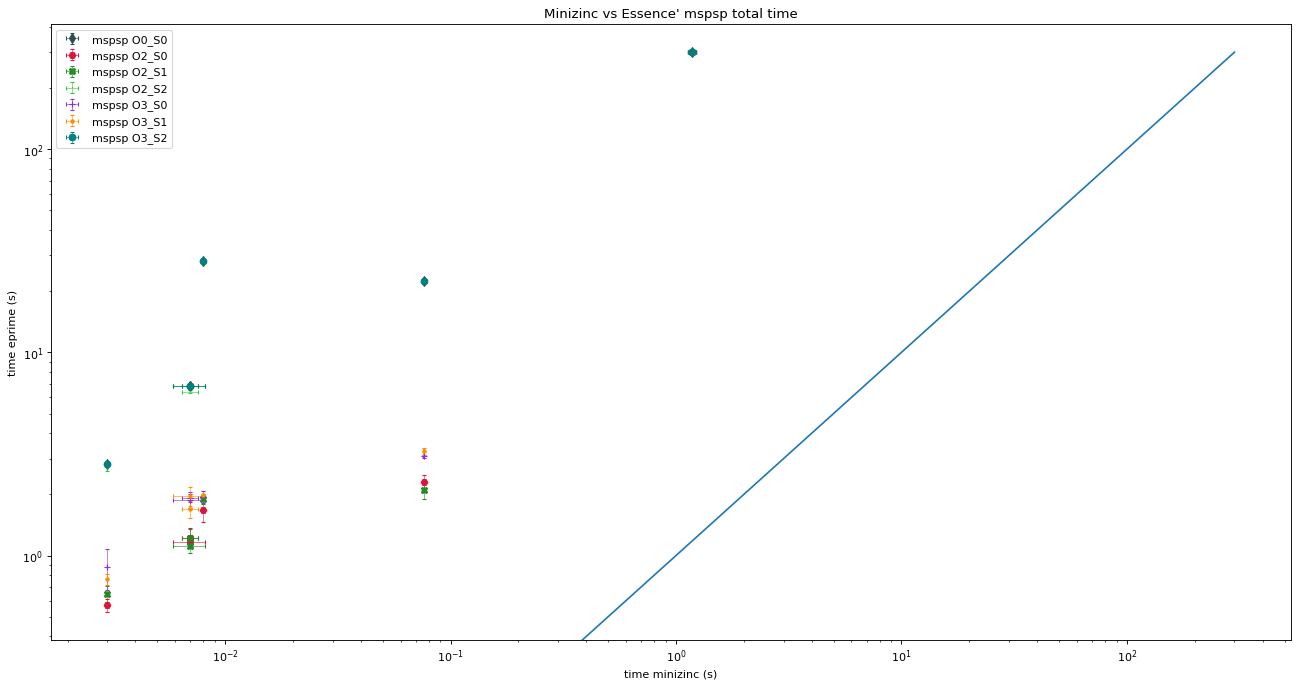

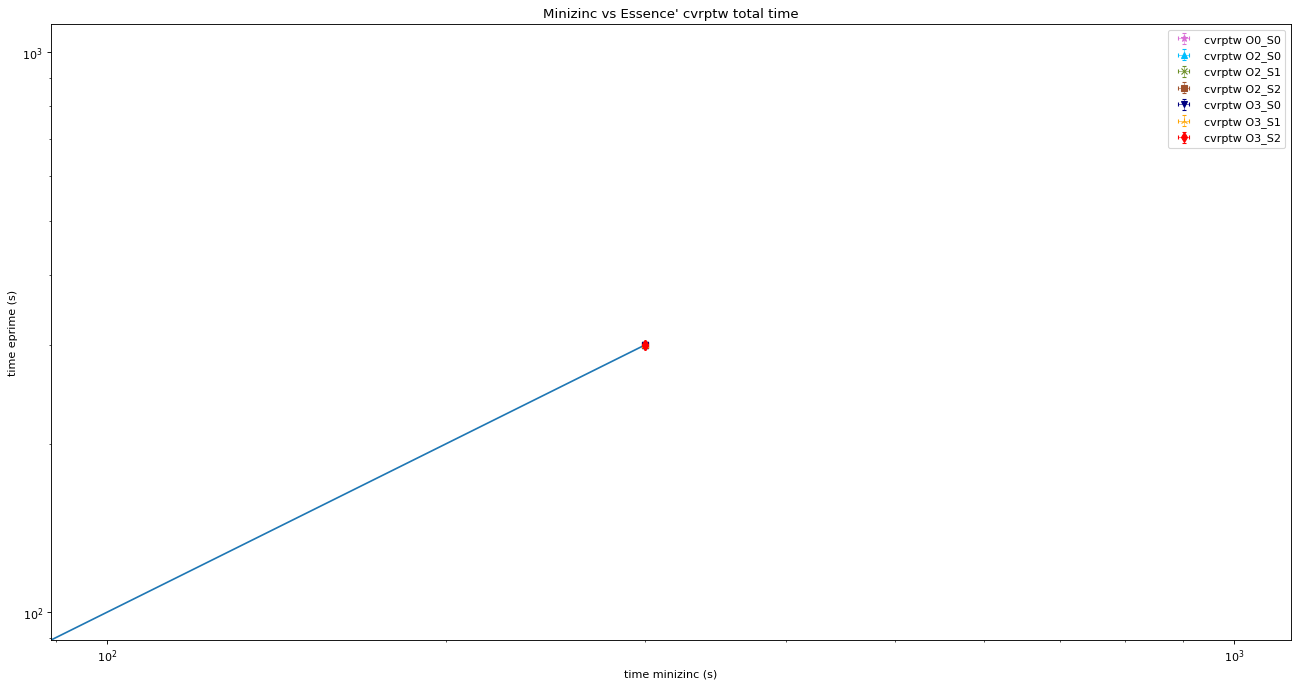

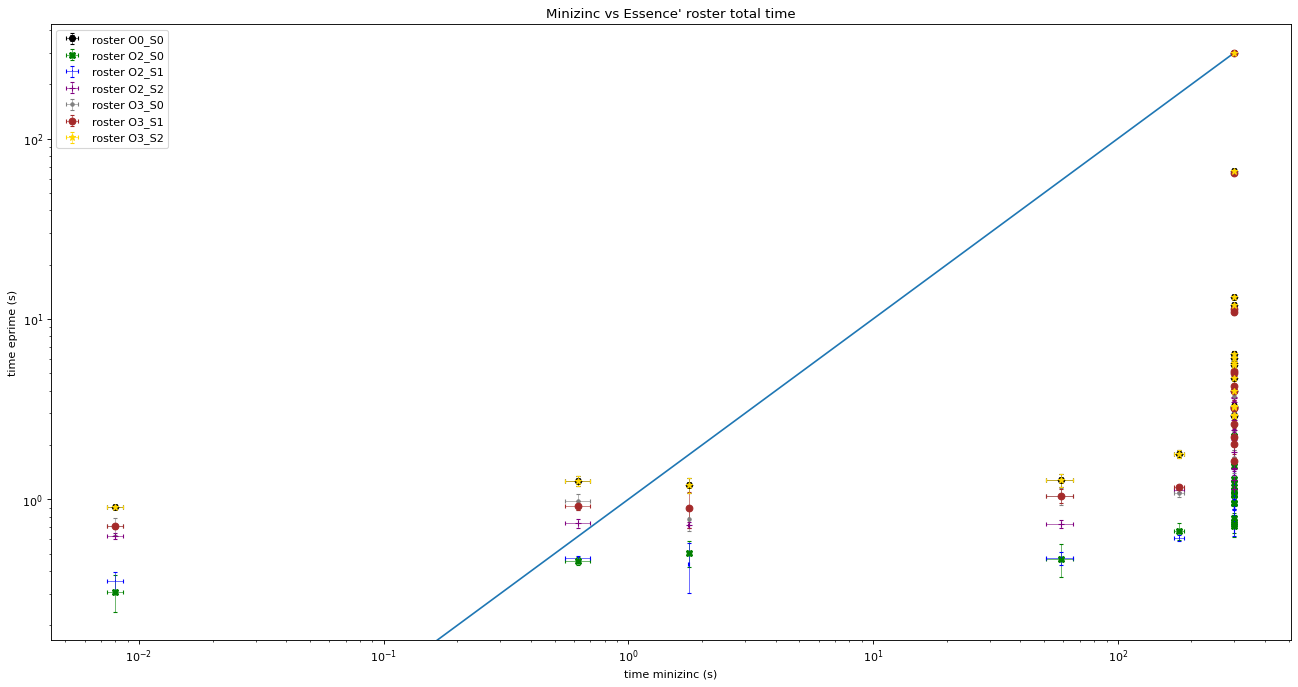

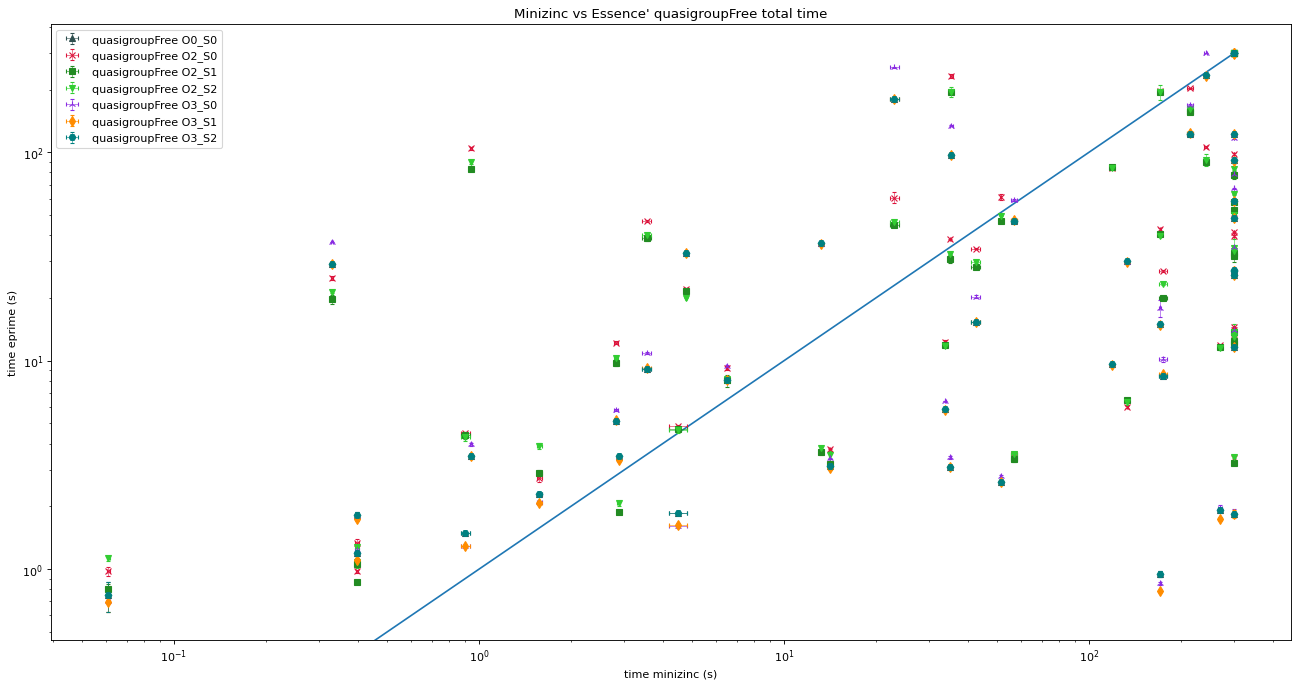

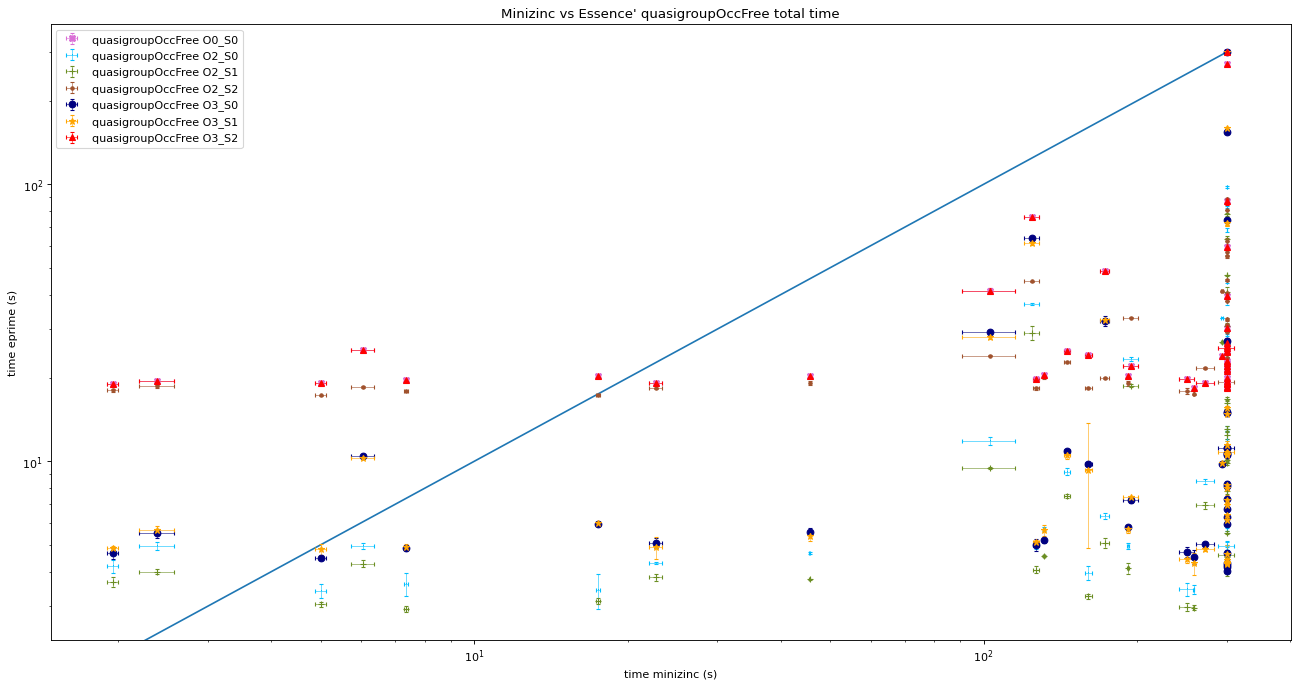

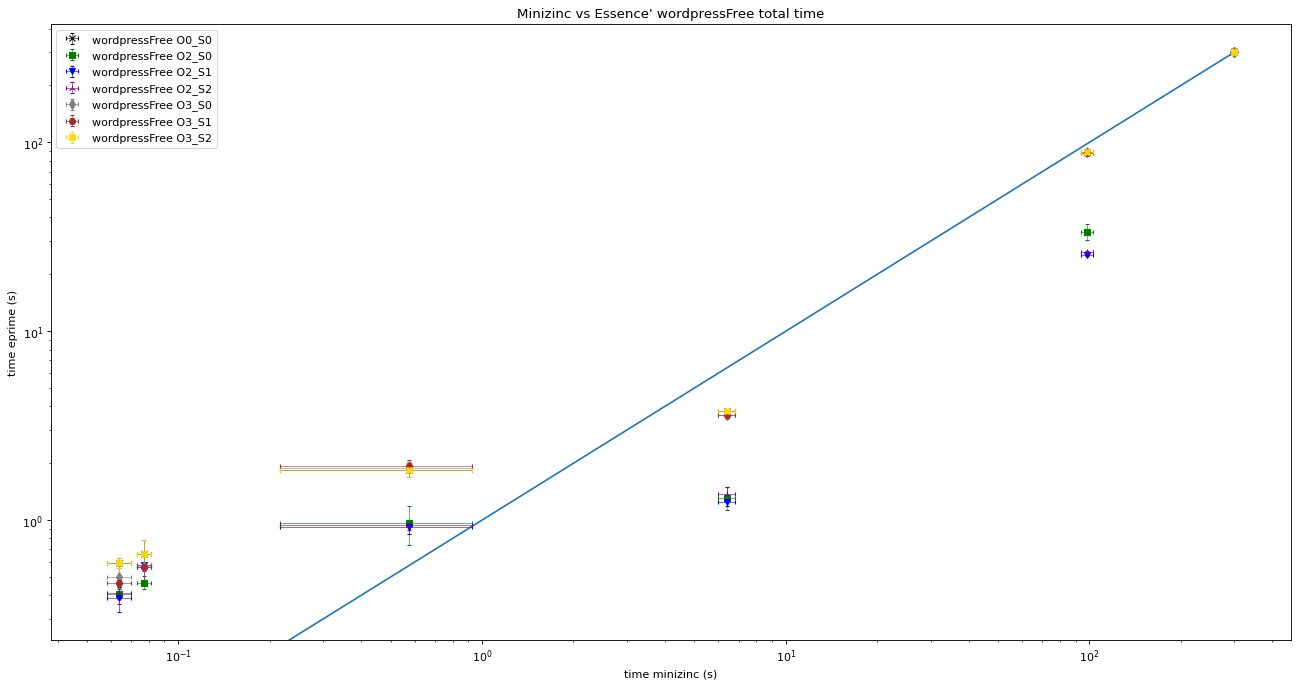

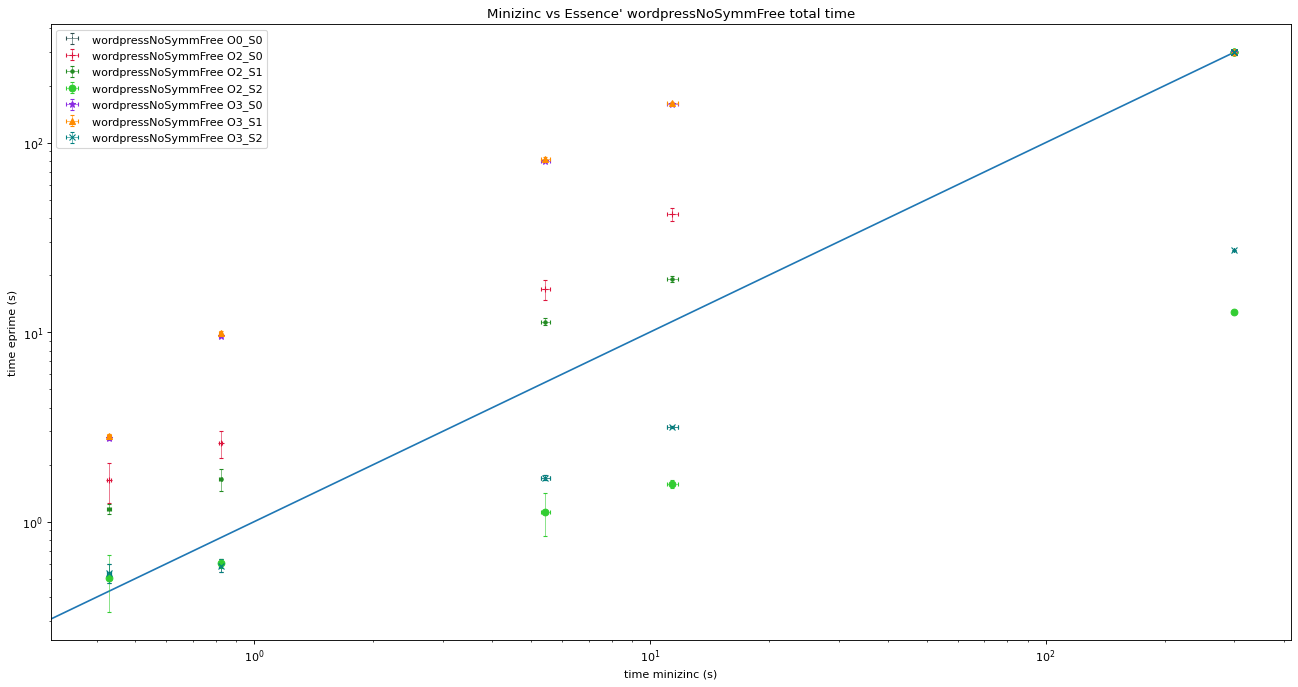

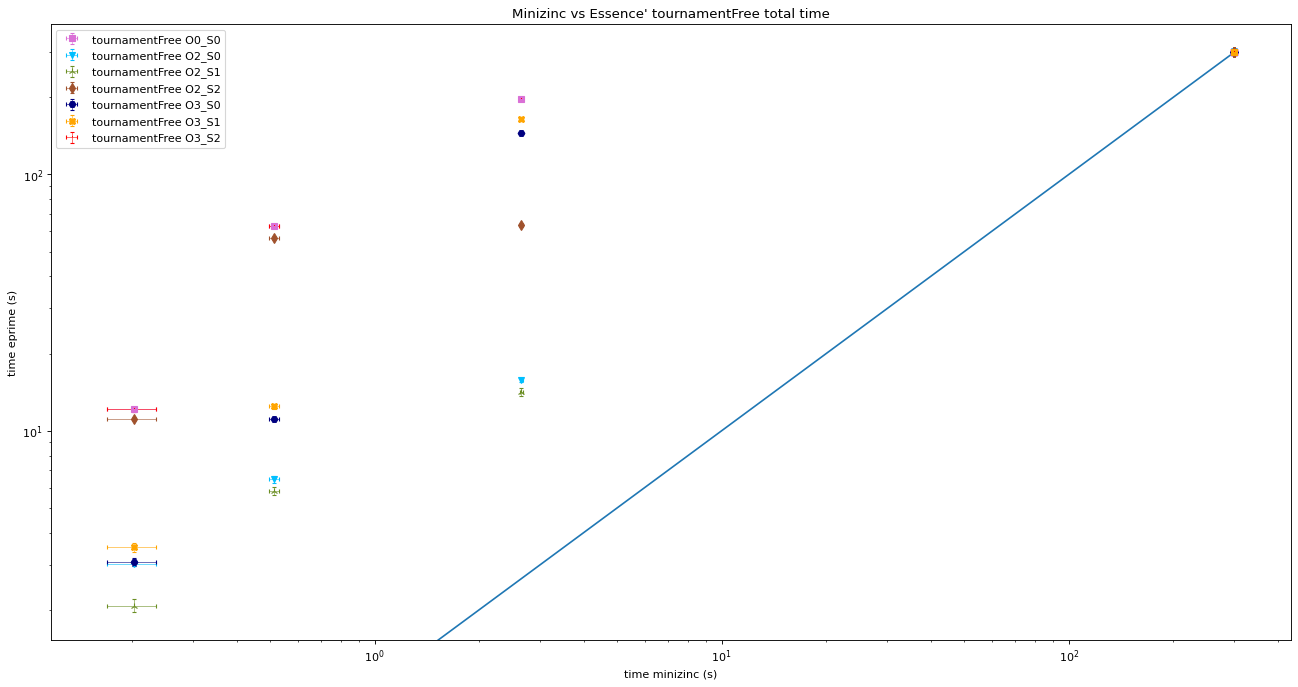

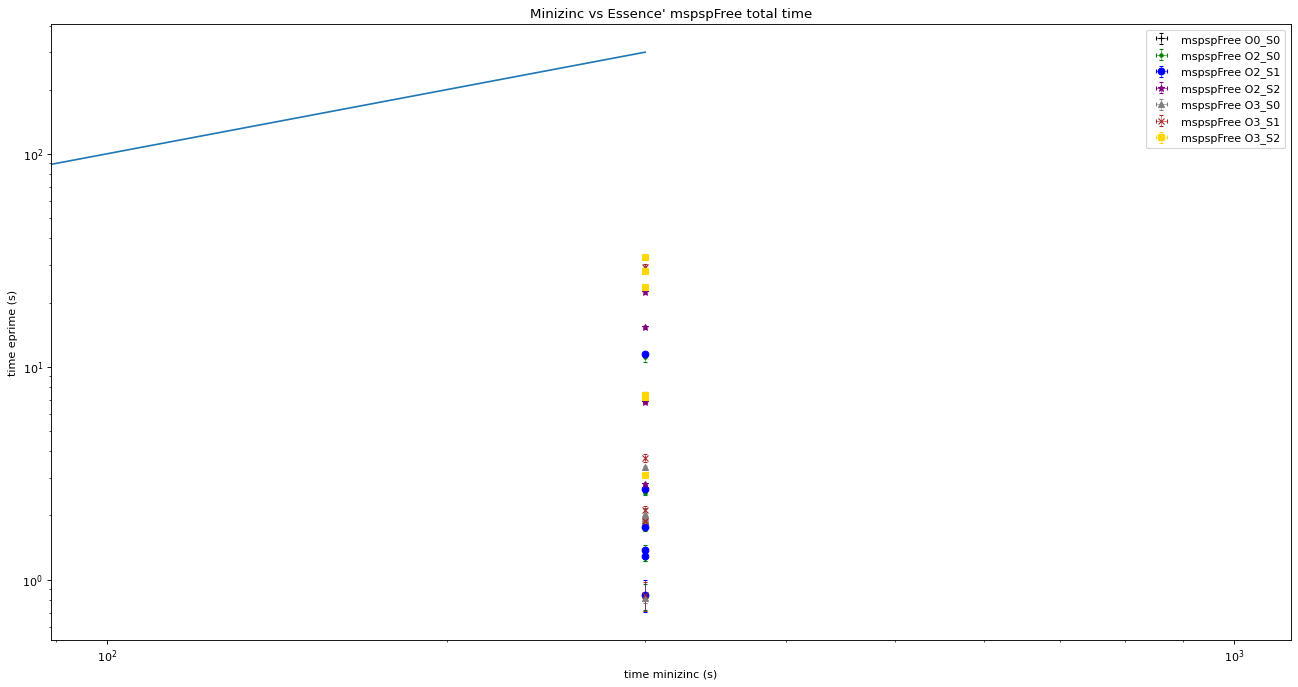

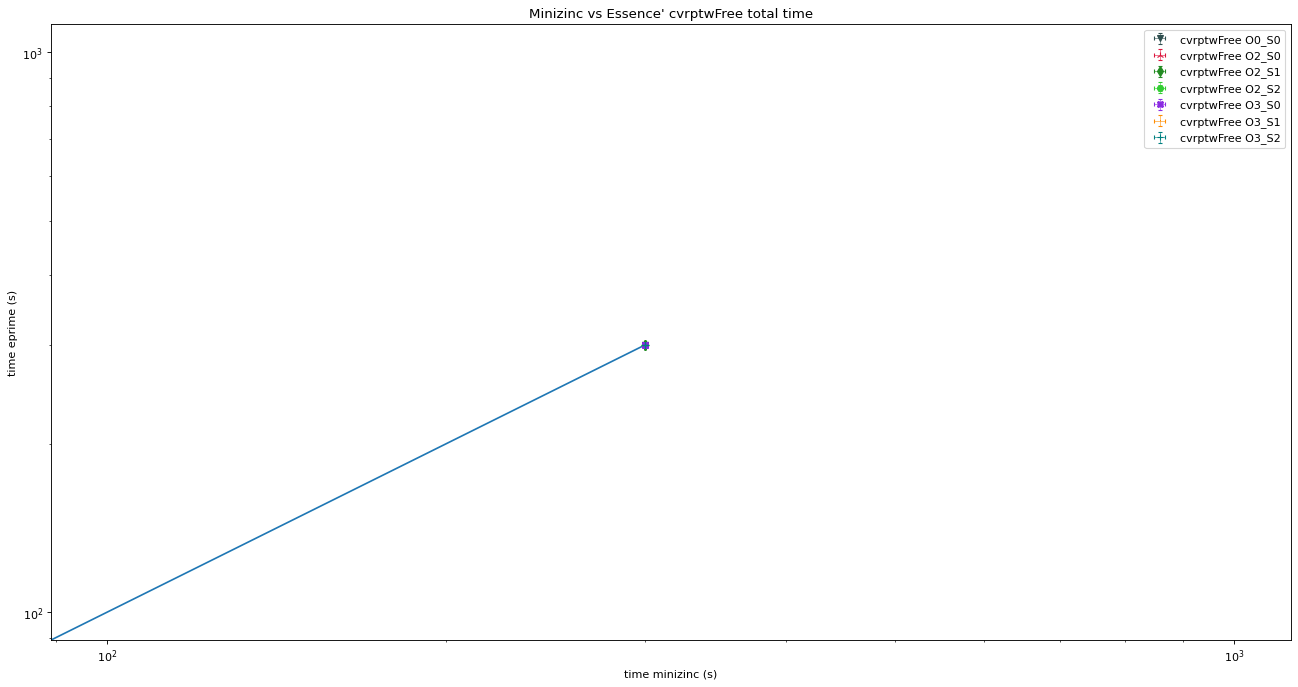

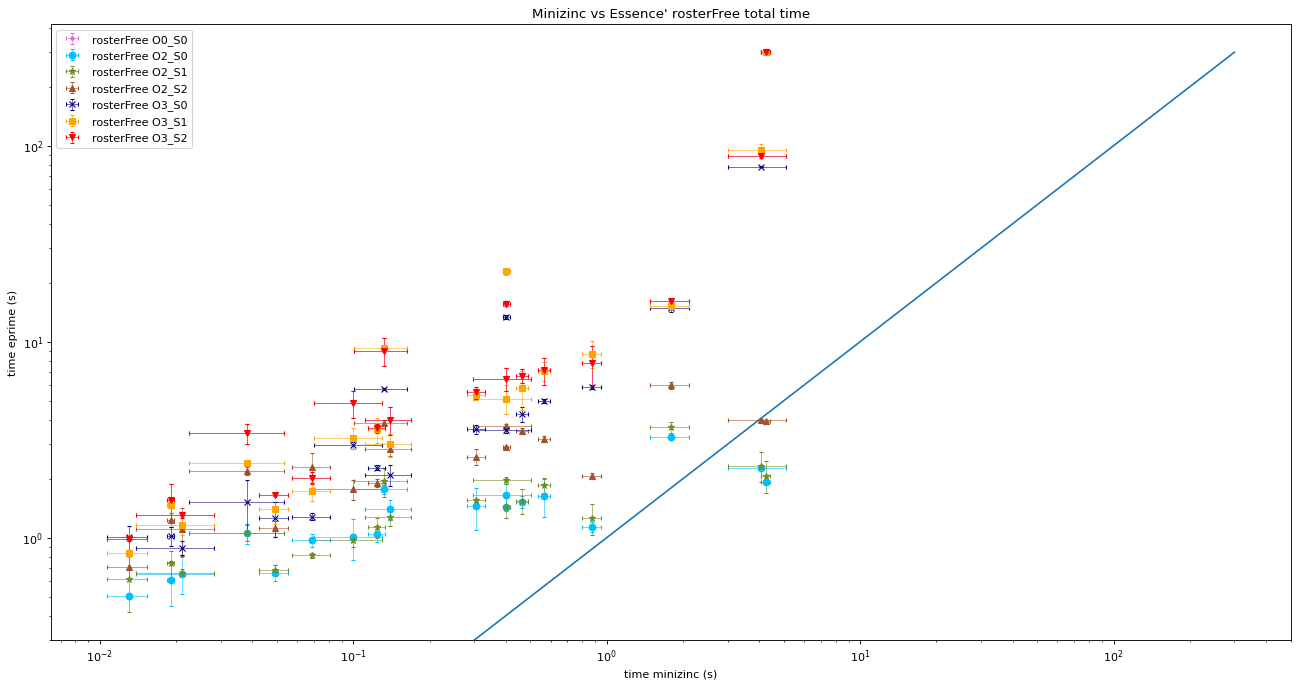

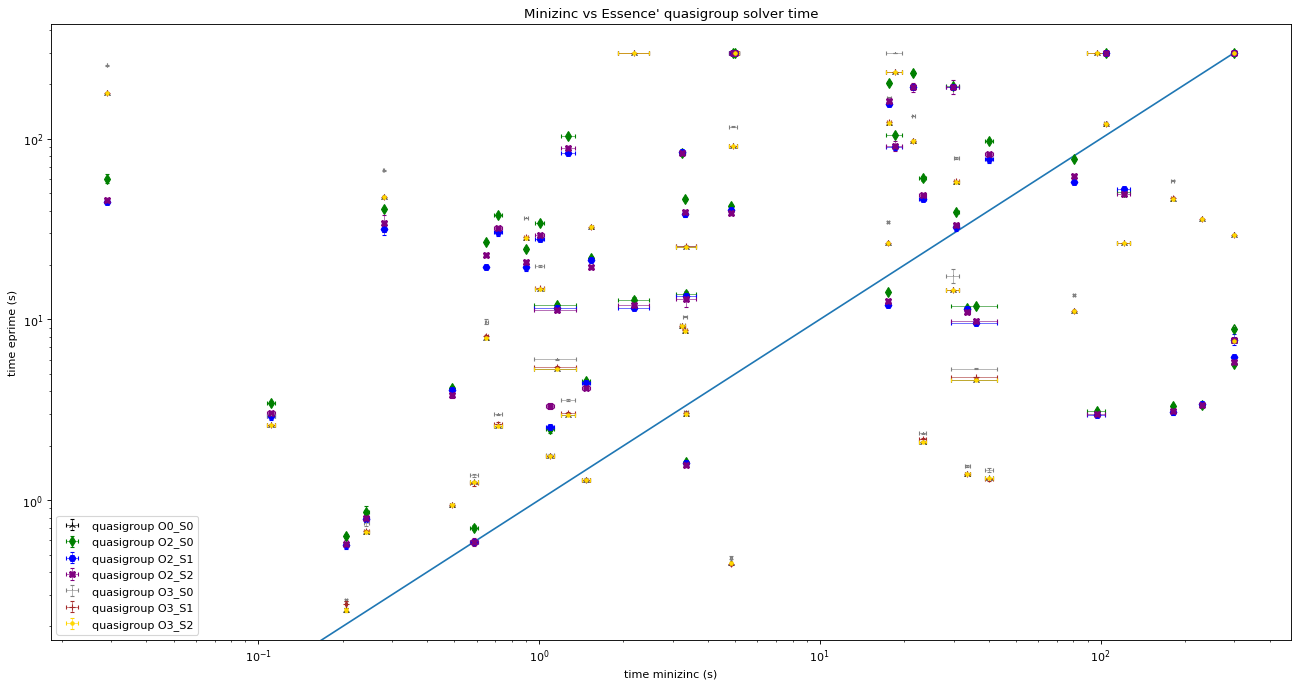

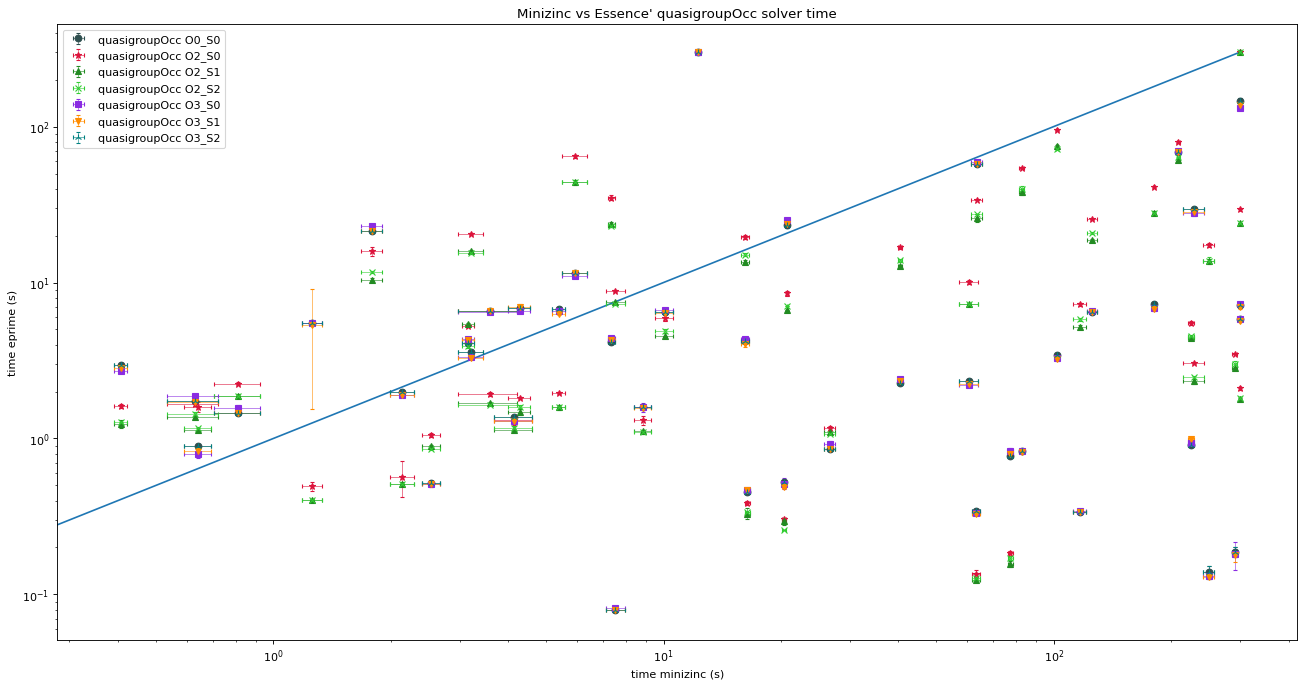

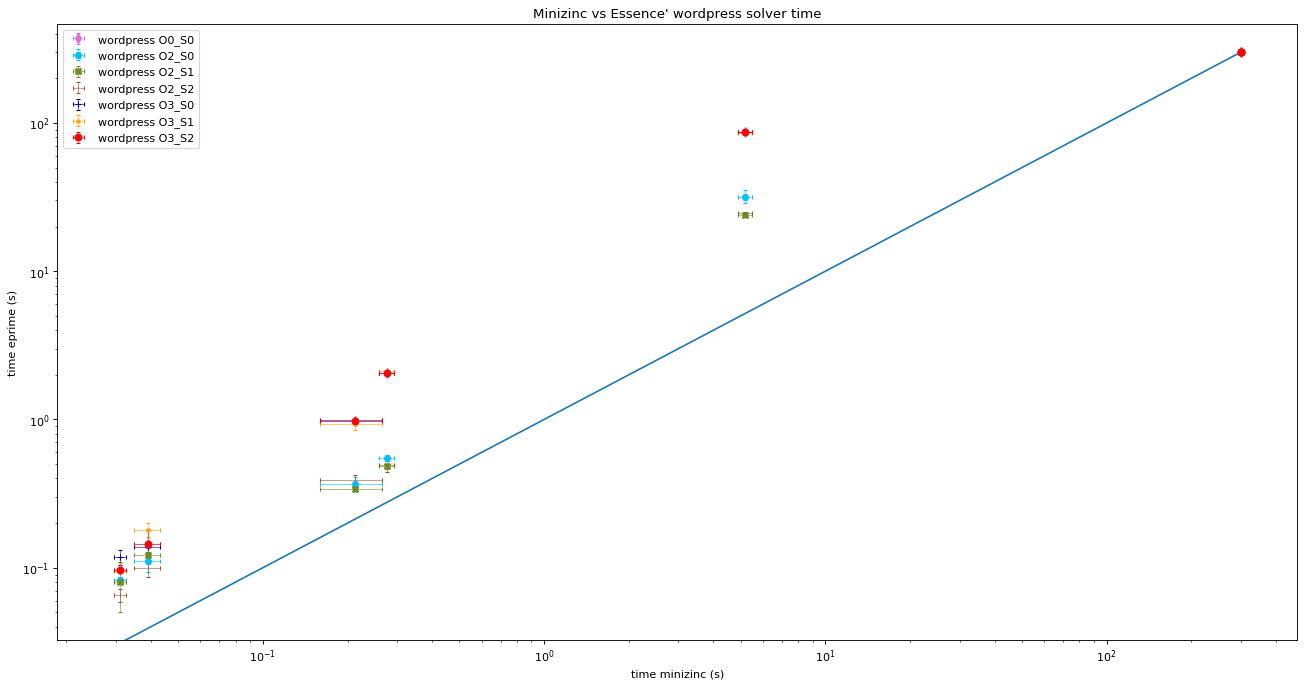

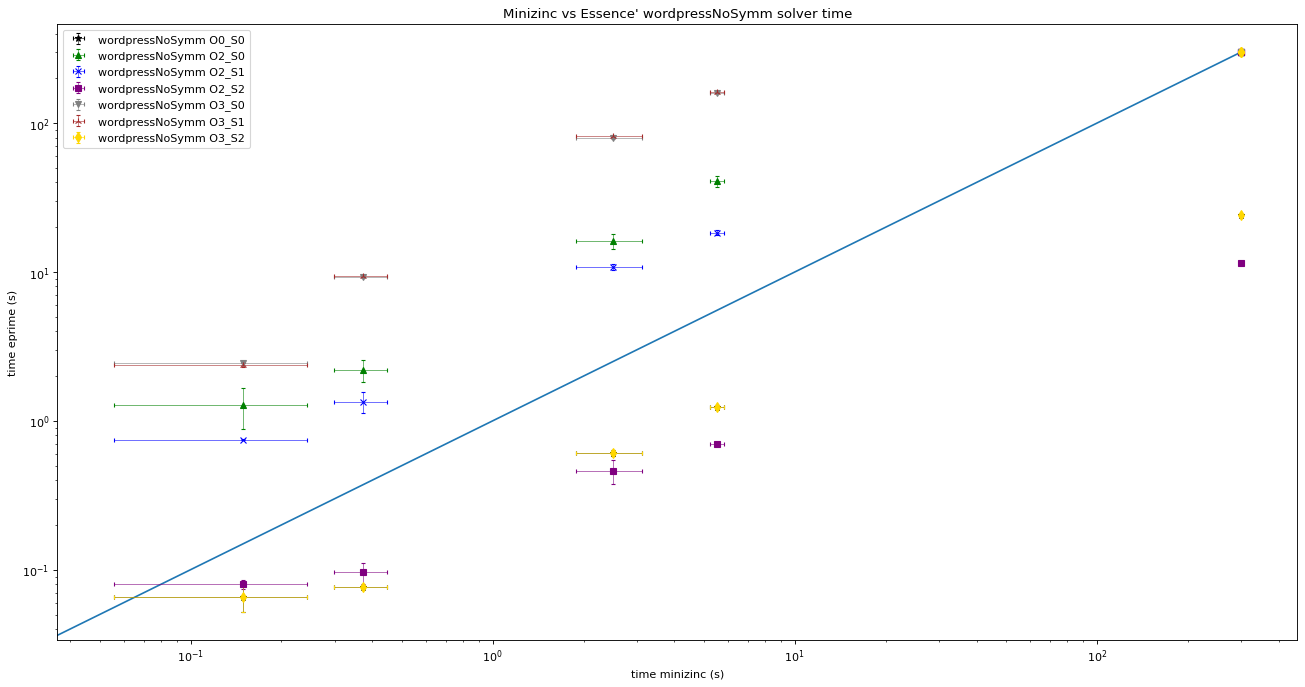

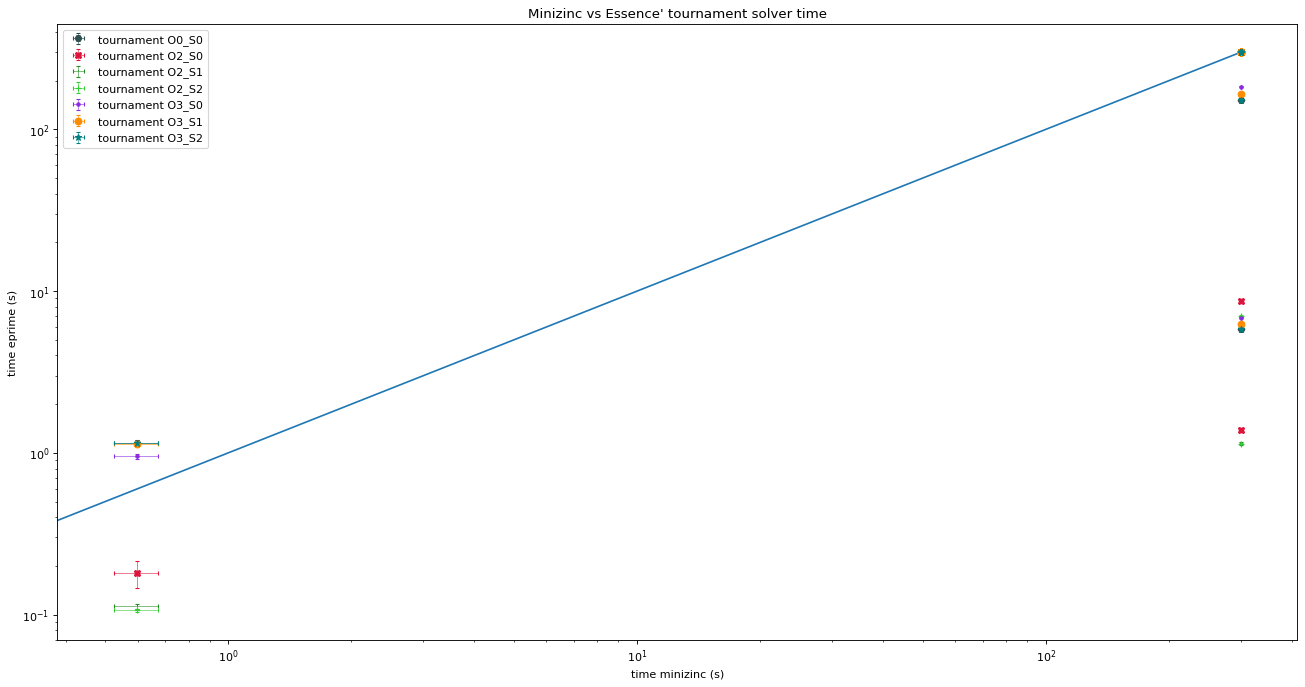

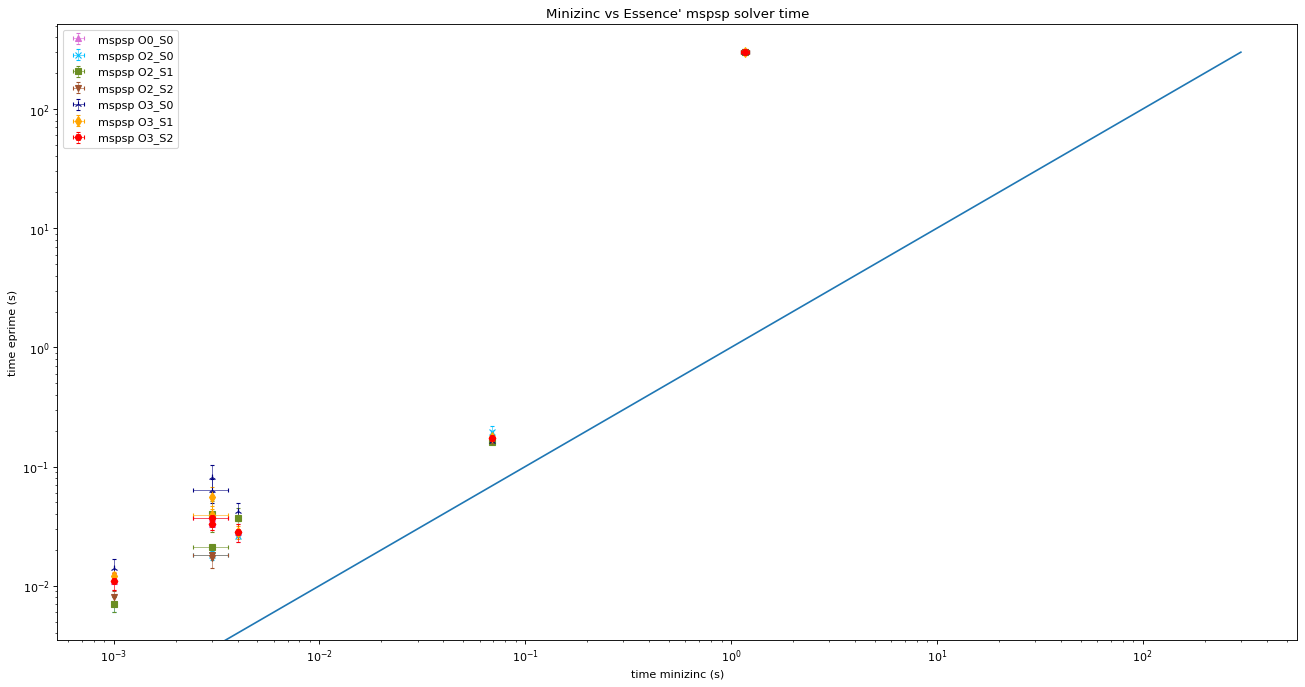

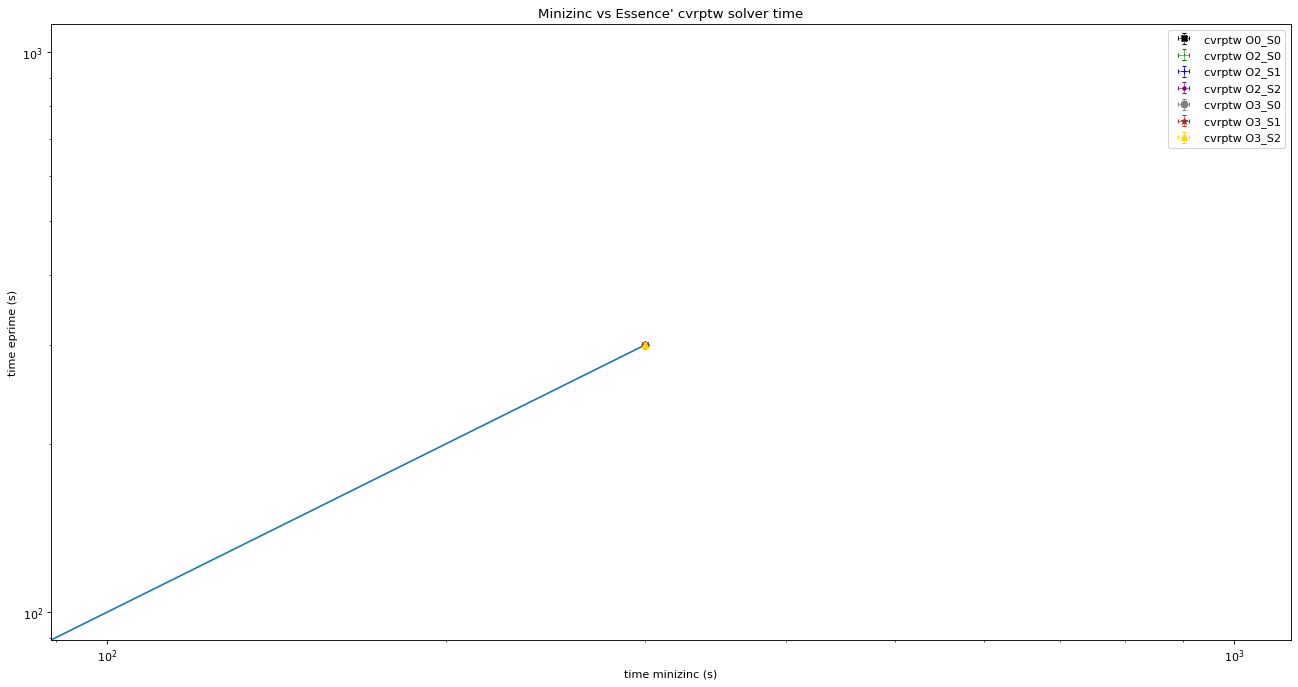

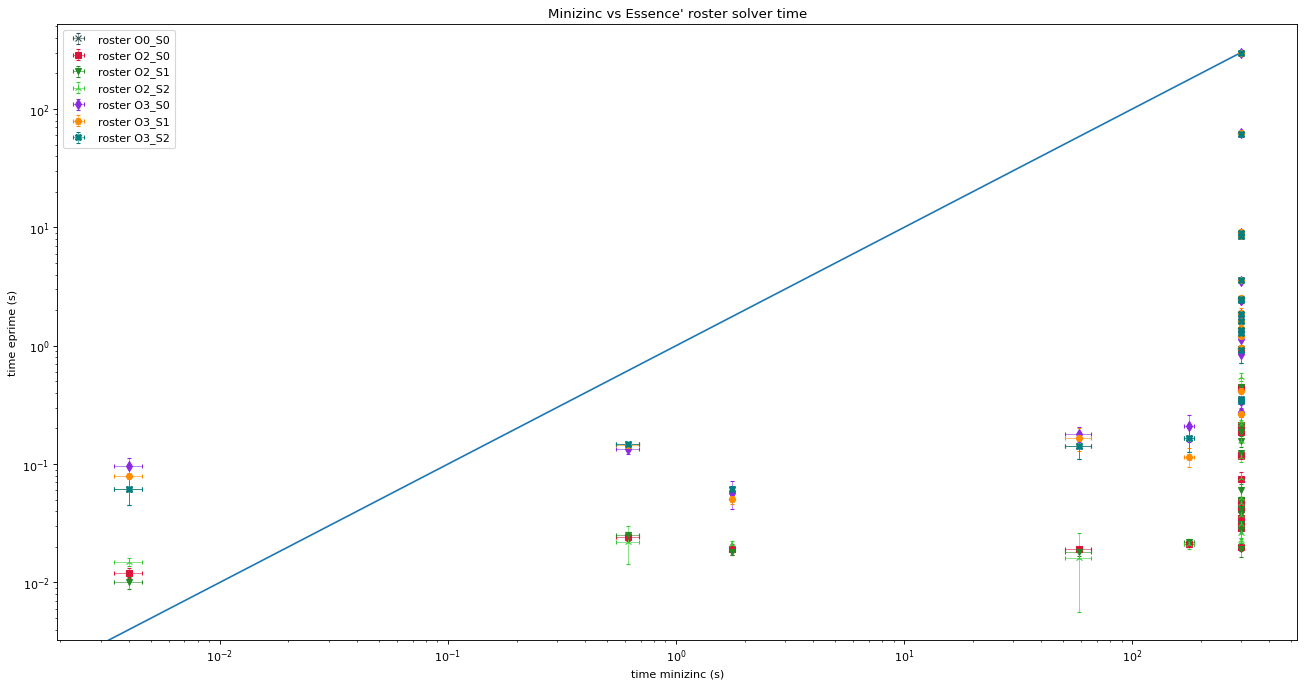

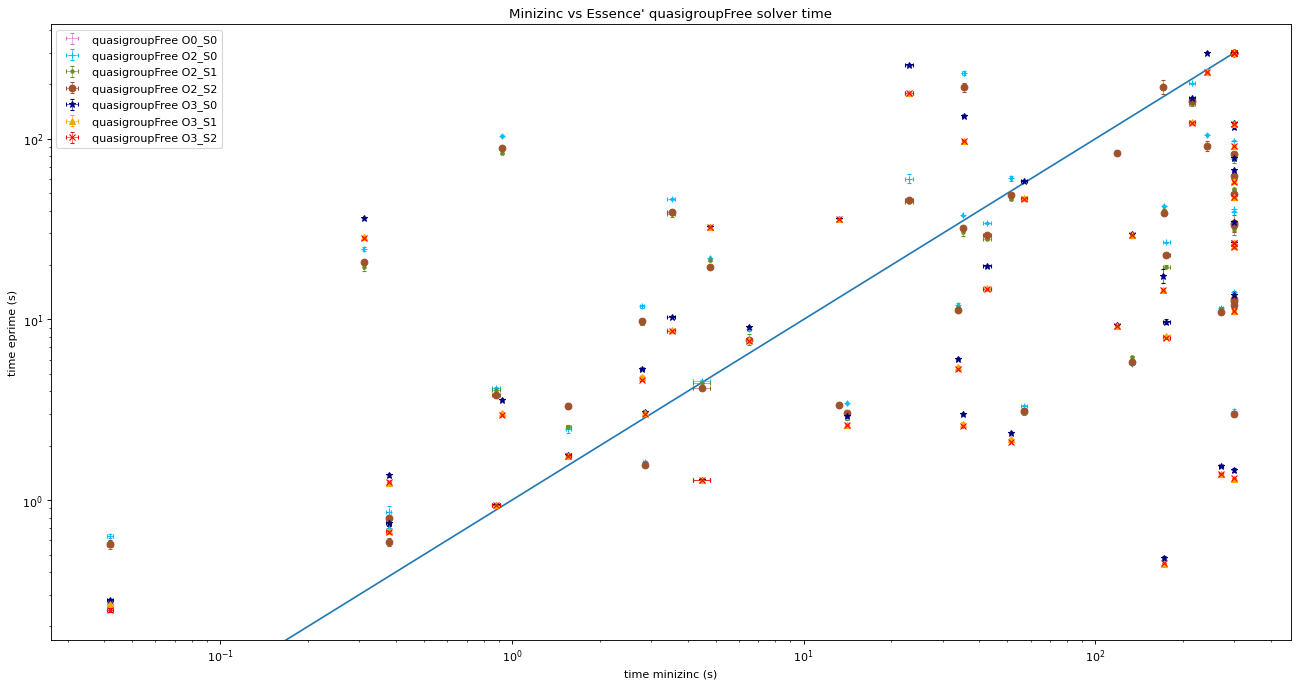

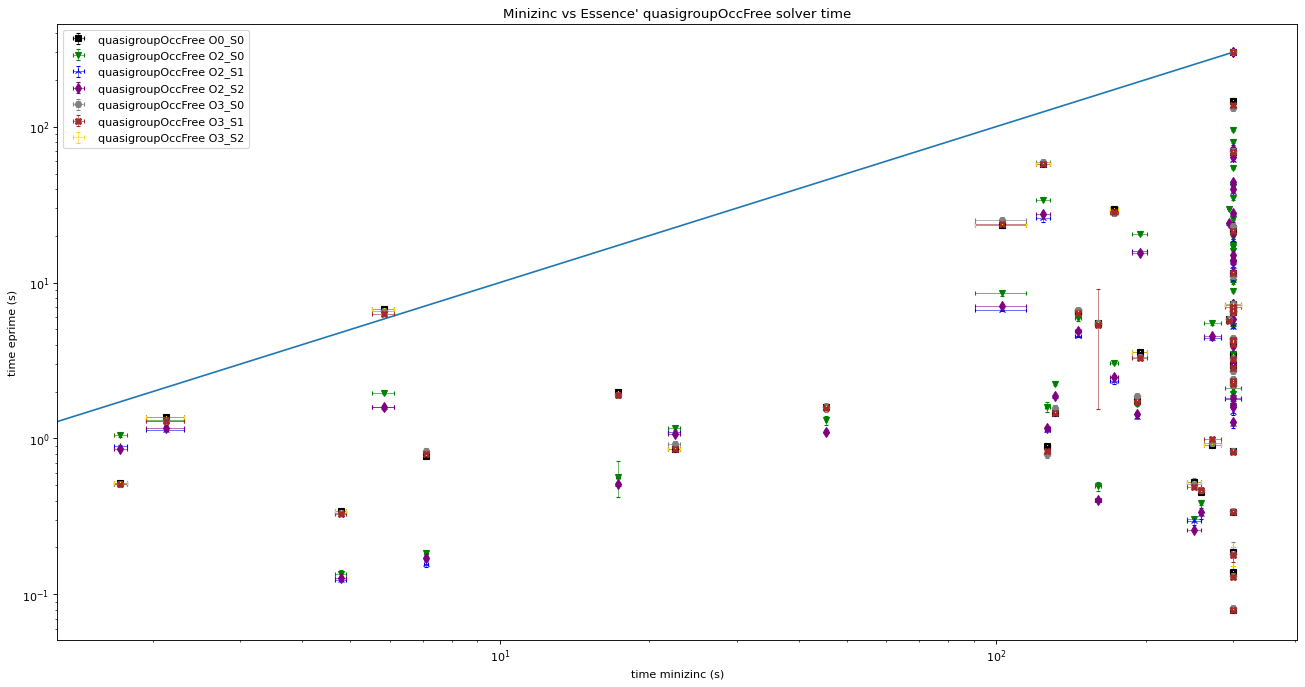

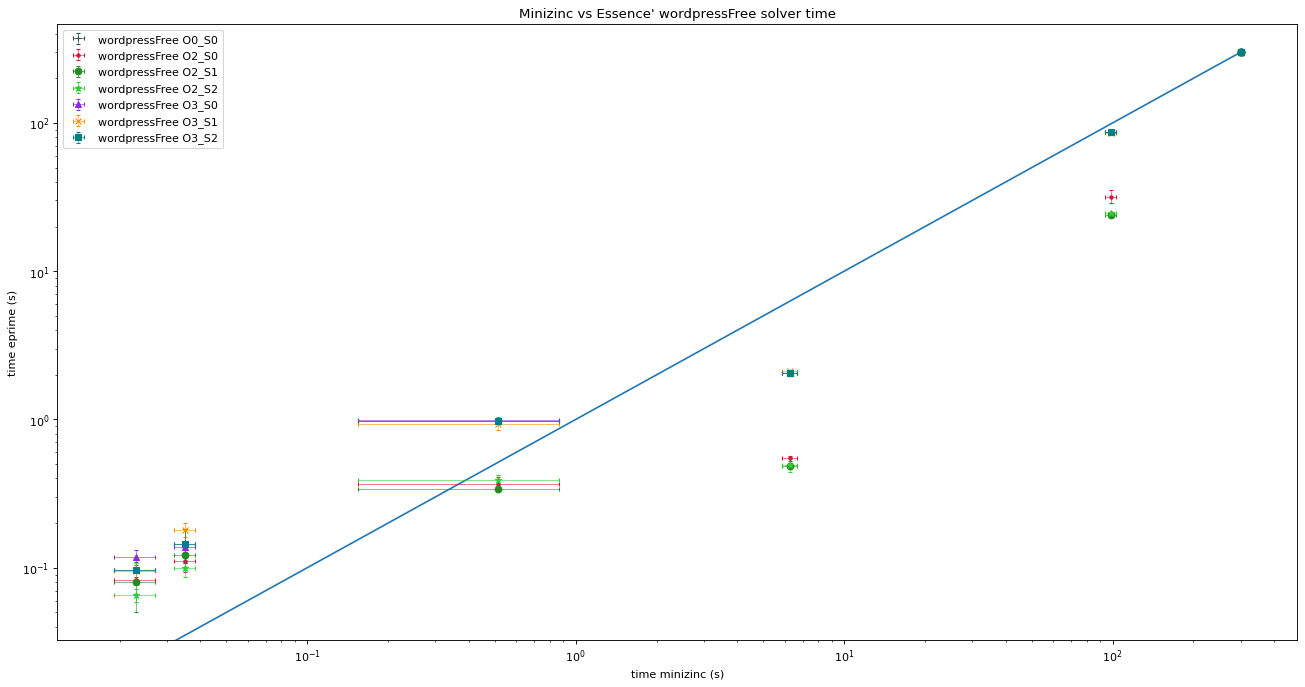

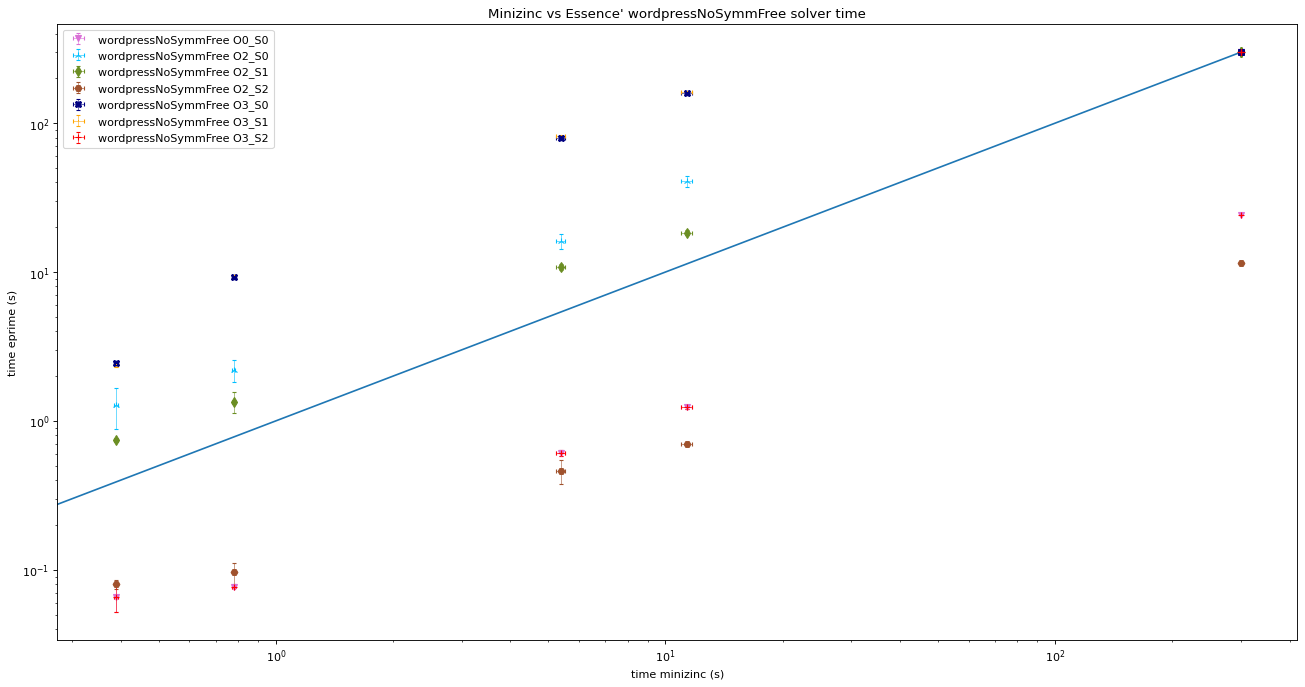

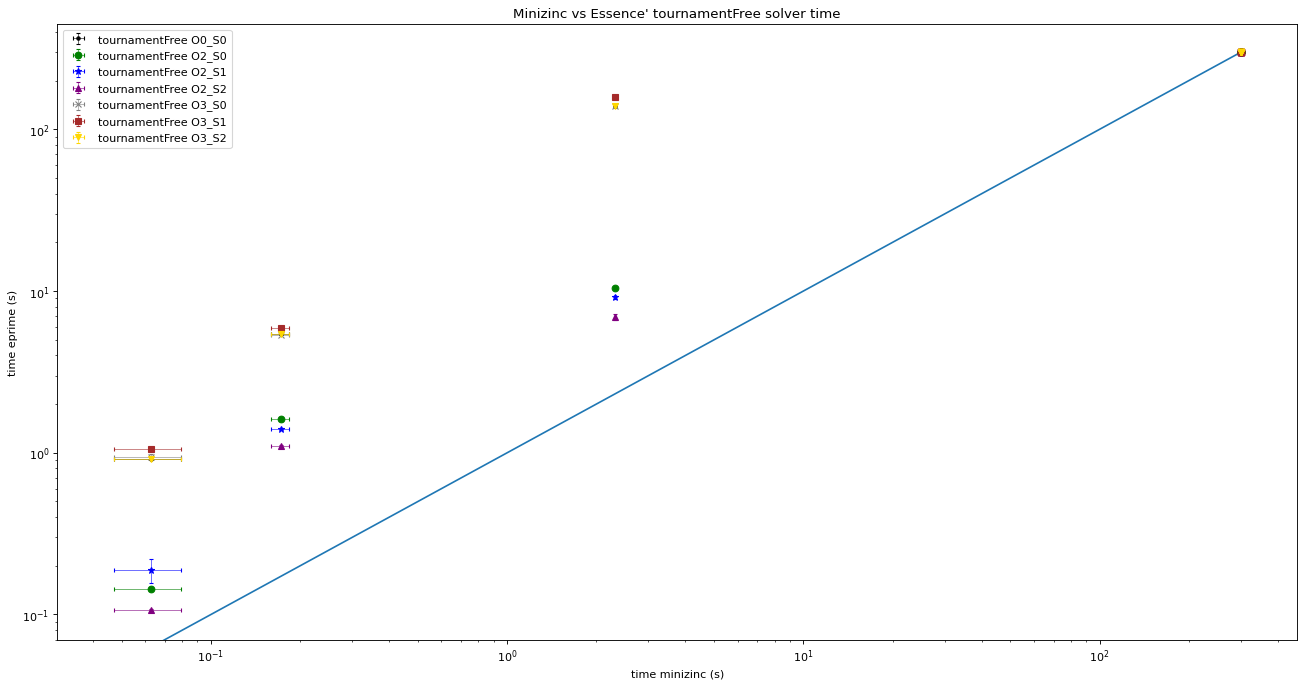

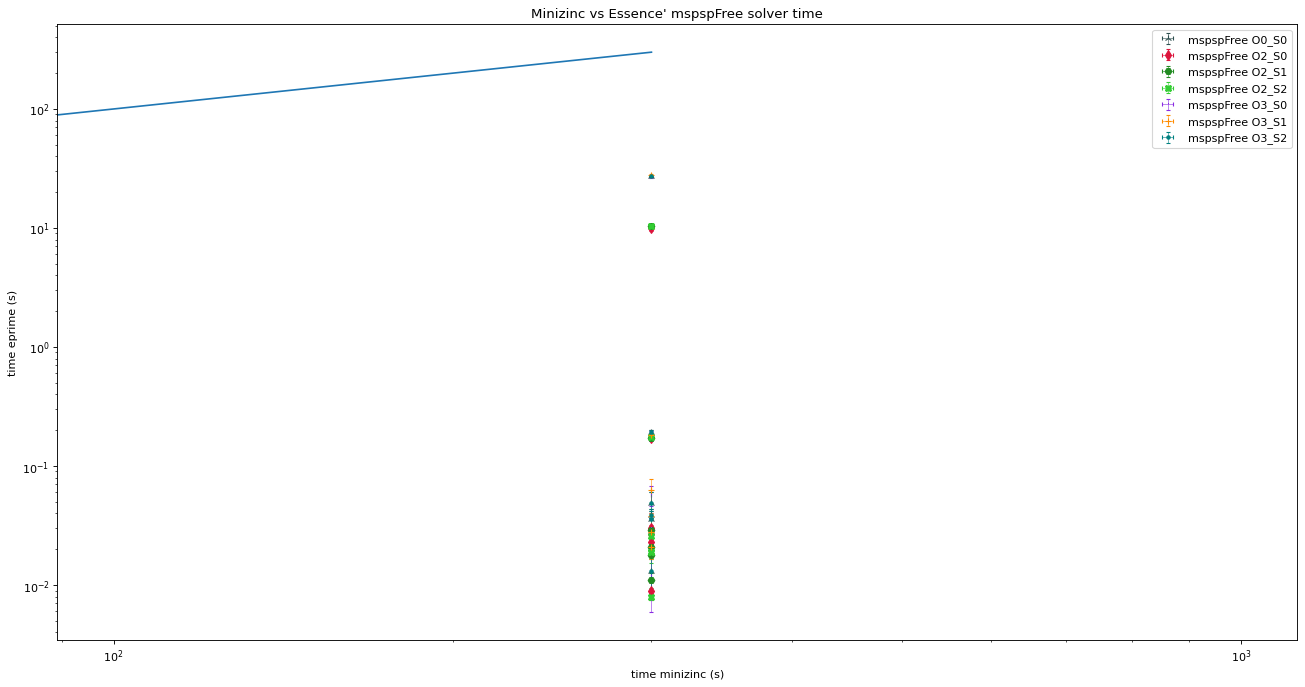

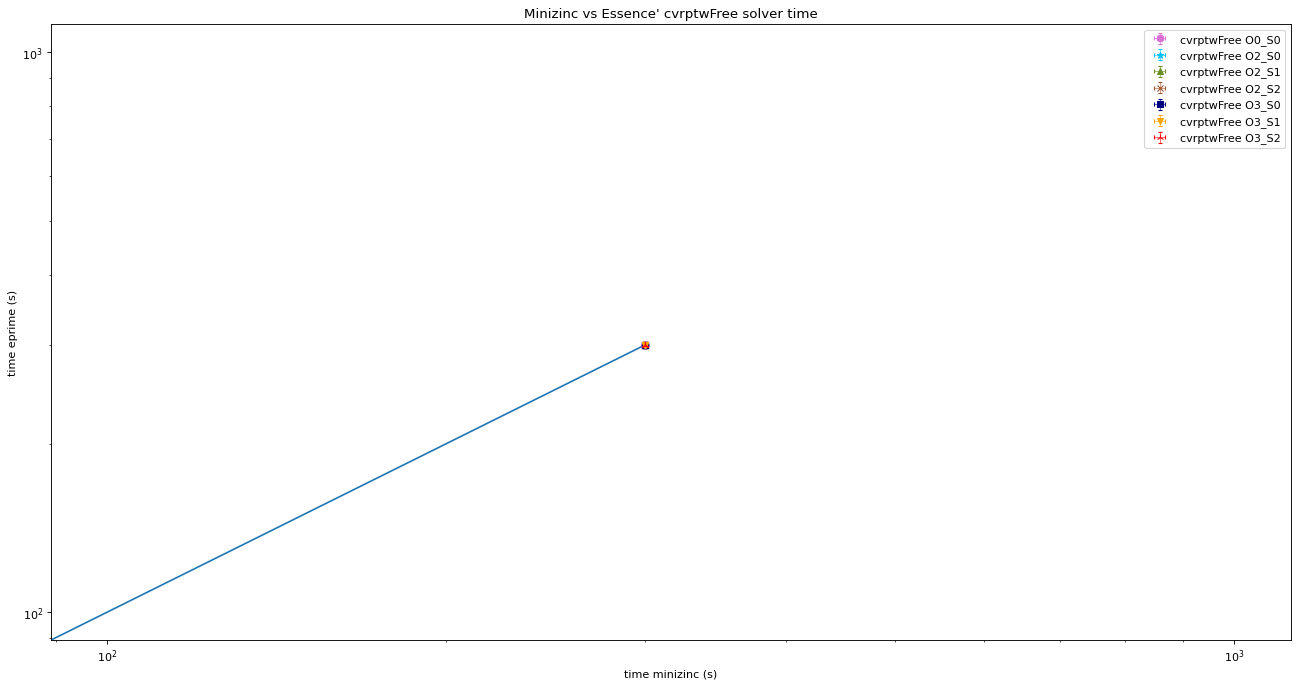

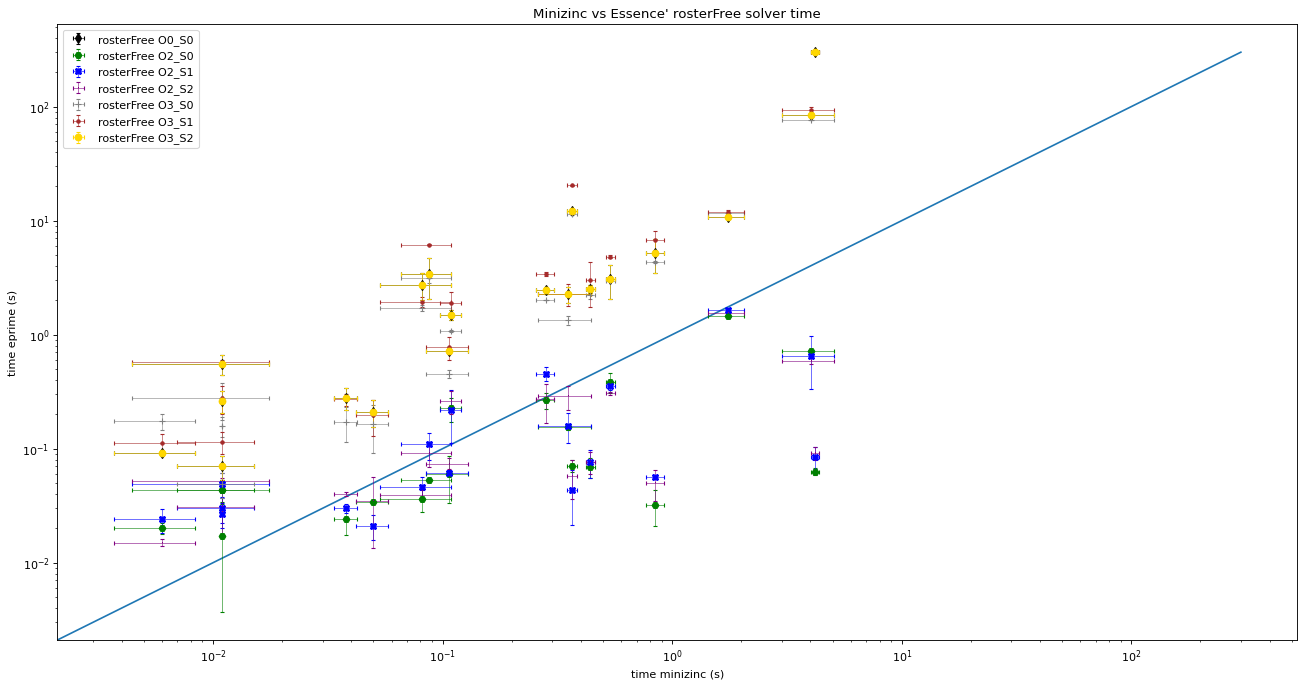

In [ ]:
for i in problems:
    setupPlotSolverSolver()
    for j in optimisations:
        createPlot(j, [i], errorbars=True)
    plt.legend(loc="best")

for i in problems:
    setupPlotSolverSolver()
    for j in optimisations:
        createPlot(j, [i], errorbars=True, indexOfInterest=solverTimeIndex)
    plt.legend(loc="best")

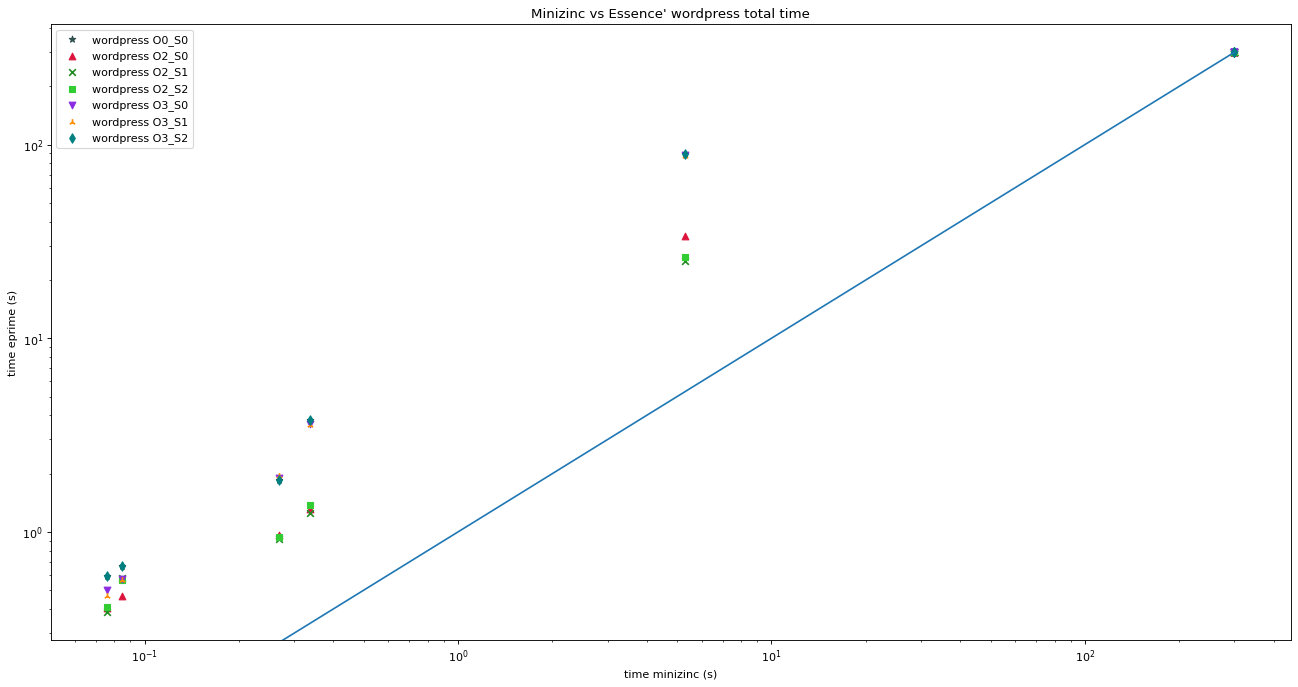

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpress])
plt.legend(loc="best")

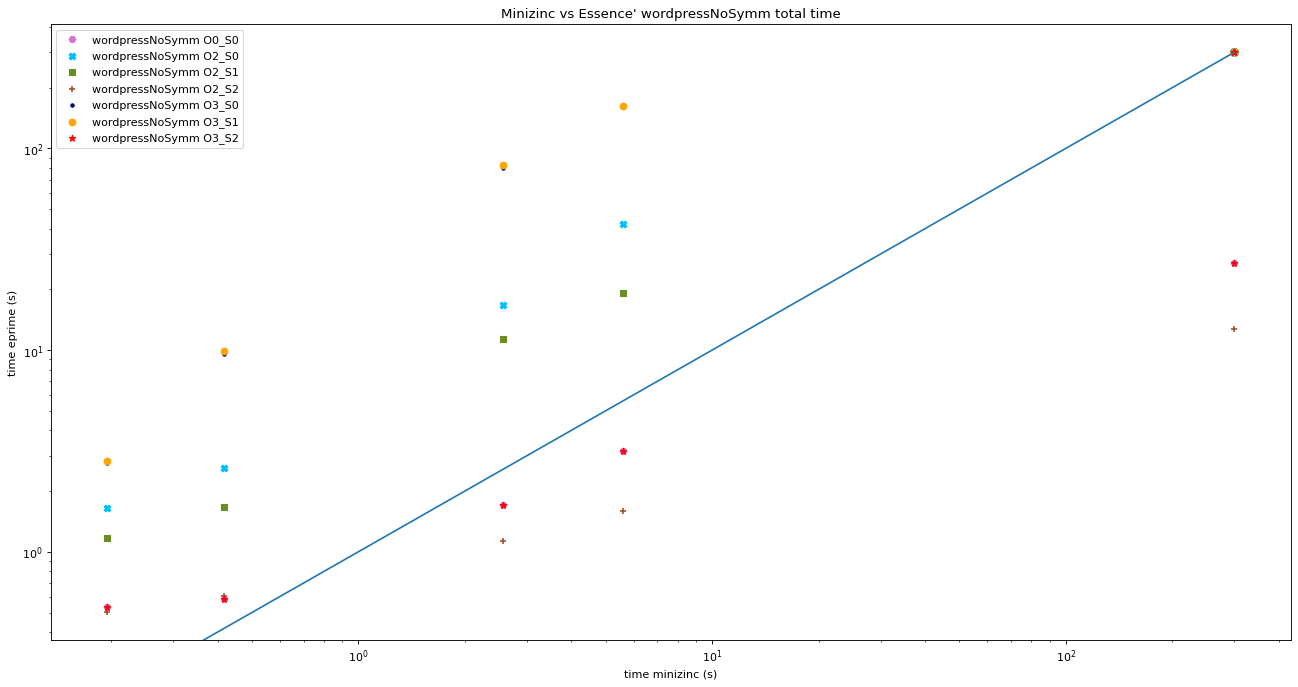

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpressNoSymm])
plt.legend(loc="best")

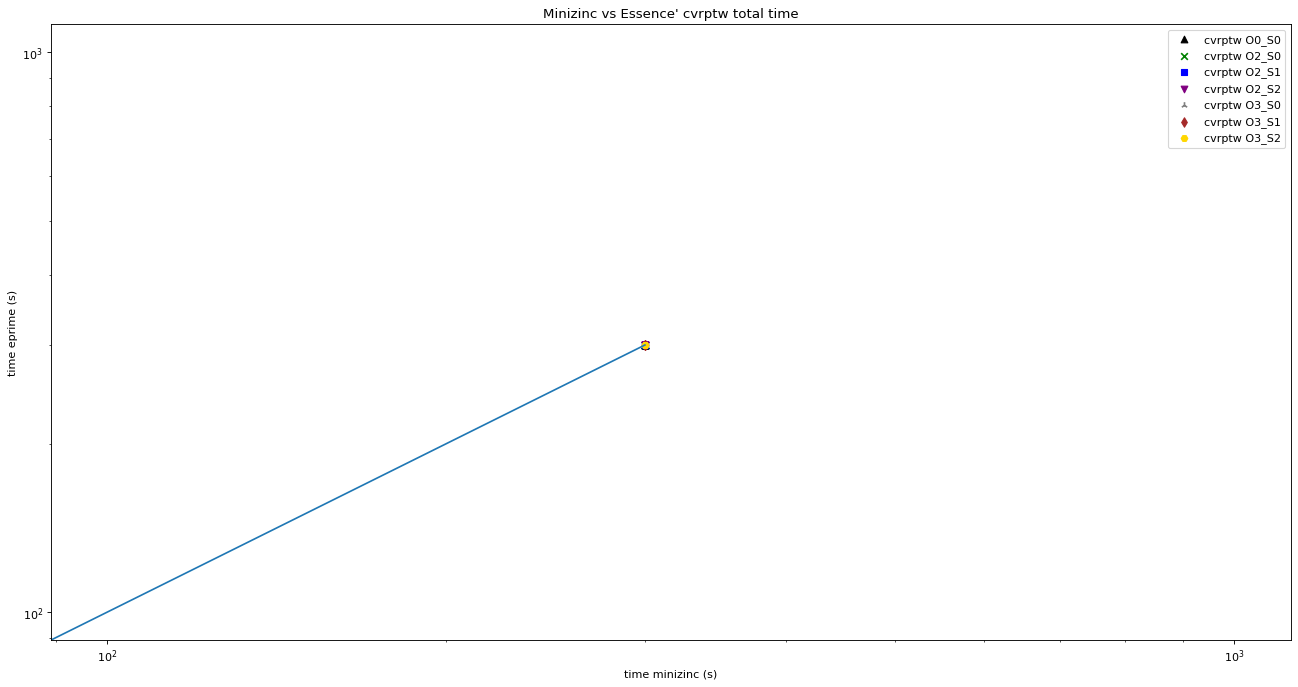

In [ ]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [cvrptw])
plt.legend(loc="best")

101

quasigroup_noFree_chuffed
[3.247, 2.085, 2.085, 2.628, 2.785, 3.399, 2.201, 1.77, 1.023, 2.122, 8.241999999999999, 5.977, 1.83, 1.169, 9.304, 6.152, 3.7560000000000002, 4.064, 3.9989999999999997, 4.061999999999999, 1.545, 5.375, 0.962, 3.107]
quasigroup_free_chuffed
[3.247, 2.085, 2.085, 2.628, 2.785, 3.399, 2.201, 1.77, 1.023, 2.122, 8.241999999999999, 5.977, 1.83, 1.169, 9.304, 6.152, 3.7560000000000002, 4.064, 3.9989999999999997, 4.061999999999999, 1.545, 5.375, 0.962, 3.107]
quasigroup_noFree_gecode
[]
quasigroup_free_gecode
[]
quasigroupOcc_noFree_chuffed
[8.281, 9.767, 9.239, 7.6240000000000006, 8.875, 8.184000000000001]
quasigroupOcc_free_chuffed
[8.281, 9.767, 9.239, 7.6240000000000006, 8.875, 8.184000000000001]
quasigroupOcc_noFree_gecode
[]
quasigroupOcc_free_gecode
[]
wordpress_noFree_chuffed
[0.732, 1.194, 0.8109999999999999, 2.716]
wordpress_free_chuffed
[0.732, 1.194, 0.8109999999999999, 2.716]
wordpress_noFree_gecode
[0.9119999999999999, 1.738, 0.724, 4.108]
wordpre

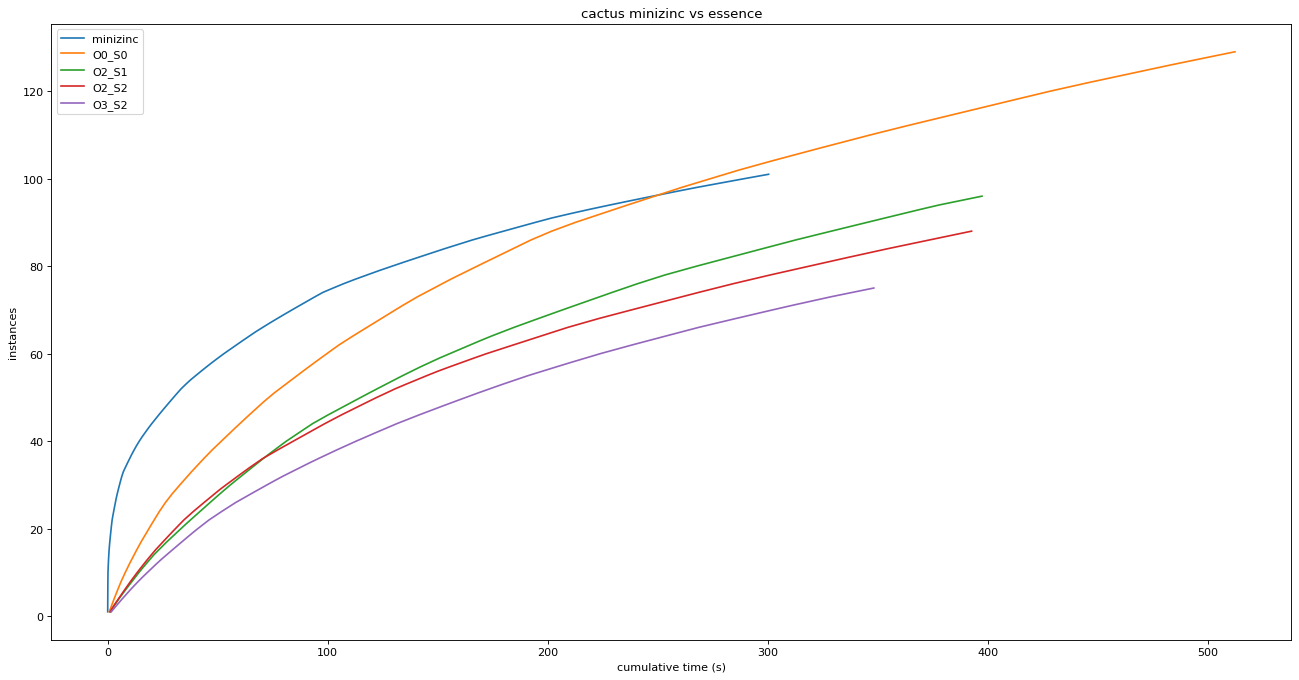

In [42]:
import numpy as np

def setupCumulativePlot(title):
    figure(figsize=(20, 10), dpi=80)
    plt.xlabel("cumulative time (s)")
    plt.ylabel("instances")
    plt.title(title)
    # plt.yscale("log")
    # plt.xscale("log")


# def plotInvValues(xValues, yValues, label):
#     plt.plot(xValues, yValues, label=label)
    # plt.xlim(max(xValues), min(xValues))
    # plt.ylim(max(yValues), min(yValues))

def getTimingCompleted(problemIndex, opt=None, std=False):
    indexToGet = timingIndex
    if std:
        indexToGet = timingStdevIndex
    lstToGet = allMinizincTimings[problemIndex]
    if opt != None:
        lstToGet = allEprimeTimings[problemIndex][opt]
    return [lstToGet[indexToGet][i] for i in range(len(lstToGet[indexToGet])) if not lstToGet[timeoutIndex][i]]
    #     return 
    #         allEprimeTimings[i][opt][indexToGet], allEprimeTimings[i][opt][timeoutIndex])
    # return (, allMinizincTimings[i][timeoutIndex])


def createCumulativePlot(problemList=problems, opt=None, std=False):
    cumulativeTime = 0.0
    cumulativeInstance = 0
    xValues = []
    # listLenMap = sum([len(allEprimeTimings[j][opt][timingIndex]) for j in problems])
    # yValues = [i for i in range(1, listLenMap+1)]
    allTimings = []
    for i in problemList:

        # print(i + " " + str(len(getTimingCompleted(i, opt, std))))
        allTimings.extend(getTimingCompleted(i, opt, std))
        if opt == "O0_S0":
            print(i)
            print(getTimingCompleted(i, opt, std))
    # allTimings = [getTimingCompleted(i) for i in problemList]
    allTimings.sort()
    print(len(allTimings))
    yValues = []
    for i in allTimings:
        cumulativeTime += i
        cumulativeInstance += 1
        xValues.append(cumulativeTime)
        yValues.append(cumulativeInstance)
    plt.plot(xValues, yValues, label=opt if opt else "minizinc")

    # for i in problemList:
    #     timing, incomplete = getTimingCompleted(i, opt, std)
    #     for j in range(len(timing)):
    #         if incomplete[j]:
    #             continue
    #         cumulativeTime += timing[j]
    #         cumulativeInstance += 1
    #         xValues.append(cumulativeTime)
    #         yValues.append(cumulativeInstance)
    # plt.plot(xValues, yValues, label=opt if opt else "minizinc")
    # return xValues, yValues

setupCumulativePlot("cactus minizinc vs essence")
createCumulativePlot()
print()
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(opt=opt)
plt.legend(loc="best")

# for opt in optimisations:
    # setupCumulativePlot(opt)
    # createCumulativePlot(opt)


KeyError: 'tournamentFree'

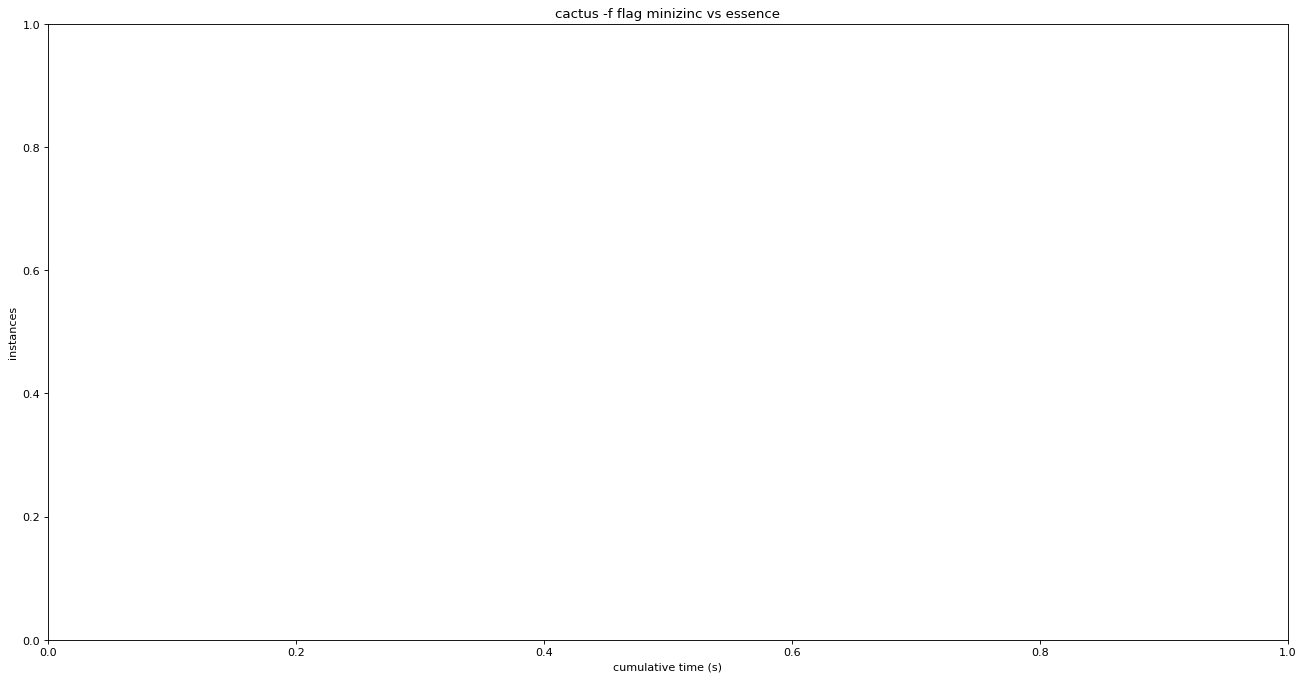

In [ ]:
setupCumulativePlot("cactus -f flag minizinc vs essence")
# freeProblems.remove("quasigroupOccFree")
# freeProblems.remove("quasigroupBoolFree")
# freeProblems.append("quasigroupFree")
# freeProblems.append("mspspFree")
test = [tournamentFree, rosterFree, "mspspFree", "cvrptwFree", "wordpressFree", "wordpressNoSymmFree", "quasigroupFree"]
createCumulativePlot(problemList=test)
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(problemList=test, opt=opt)
plt.legend(loc="best")


setupCumulativePlot("selective cactus -f flag minizinc vs essence")
test = [tournamentFree, rosterFree, mspsp, cvrptw, wordpress, wordpressNoSymm, quasigroup]
createCumulativePlot(problemList=test)
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(problemList=test, opt=opt)
plt.legend(loc="best")

77
76
75
75
76
74
75
76


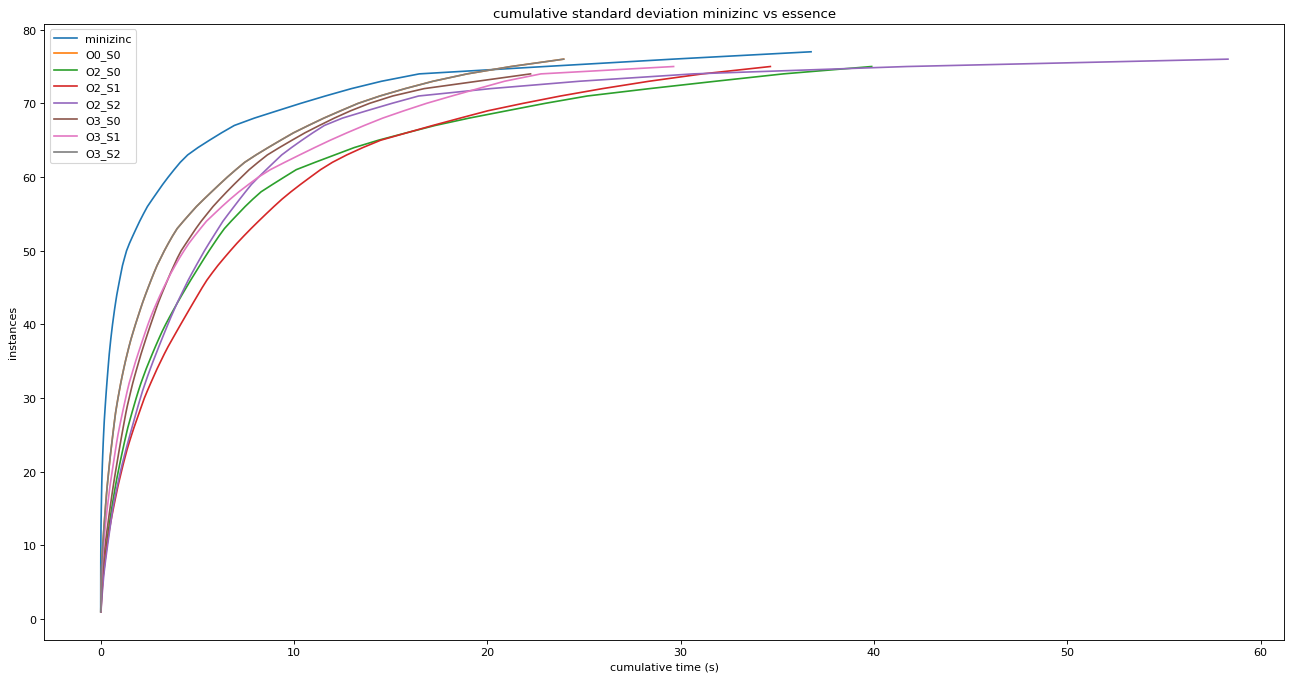

In [ ]:
setupCumulativePlot("cumulative standard deviation minizinc vs essence")
createCumulativePlot(problemList=freeOriginalProblems, std=True)
for opt in optimisations:
# for opt in ["O0_S0"]:
    createCumulativePlot(problemList=freeOriginalProblems, opt=opt, std=True)
plt.legend(loc="best")

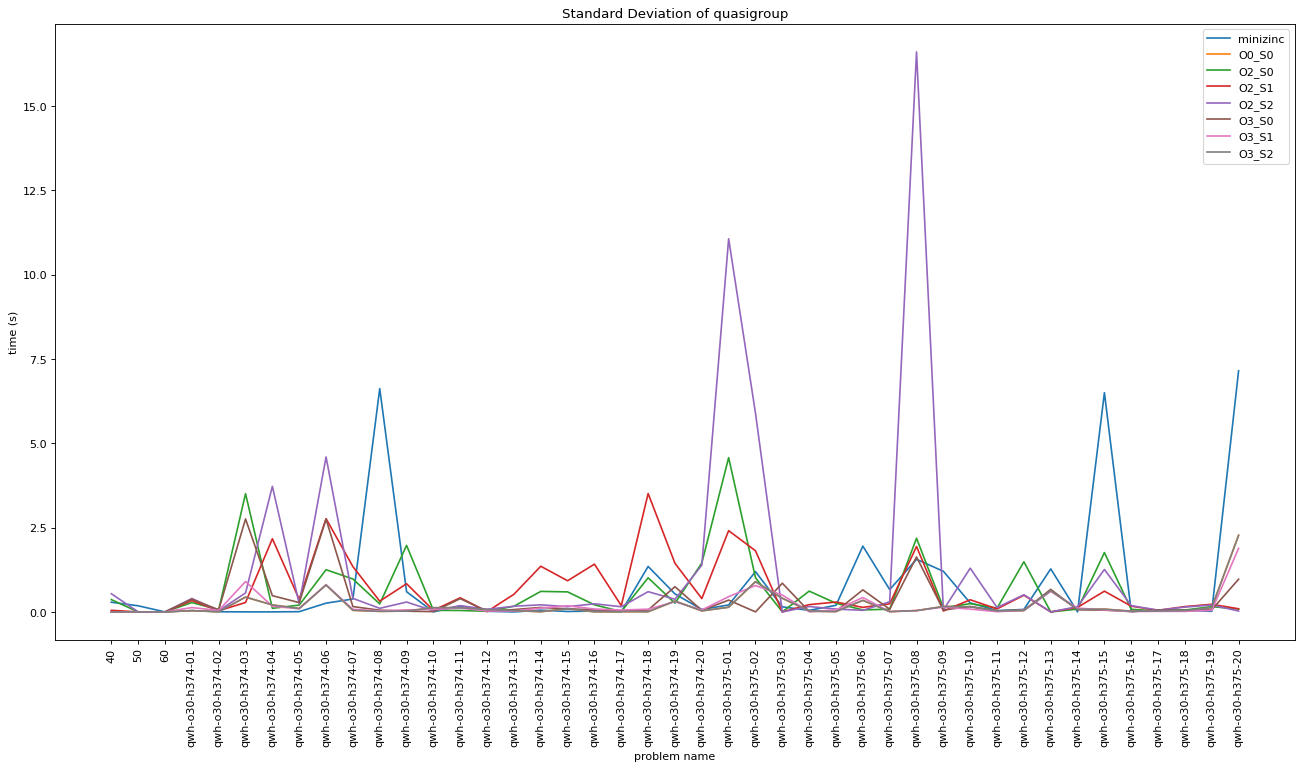

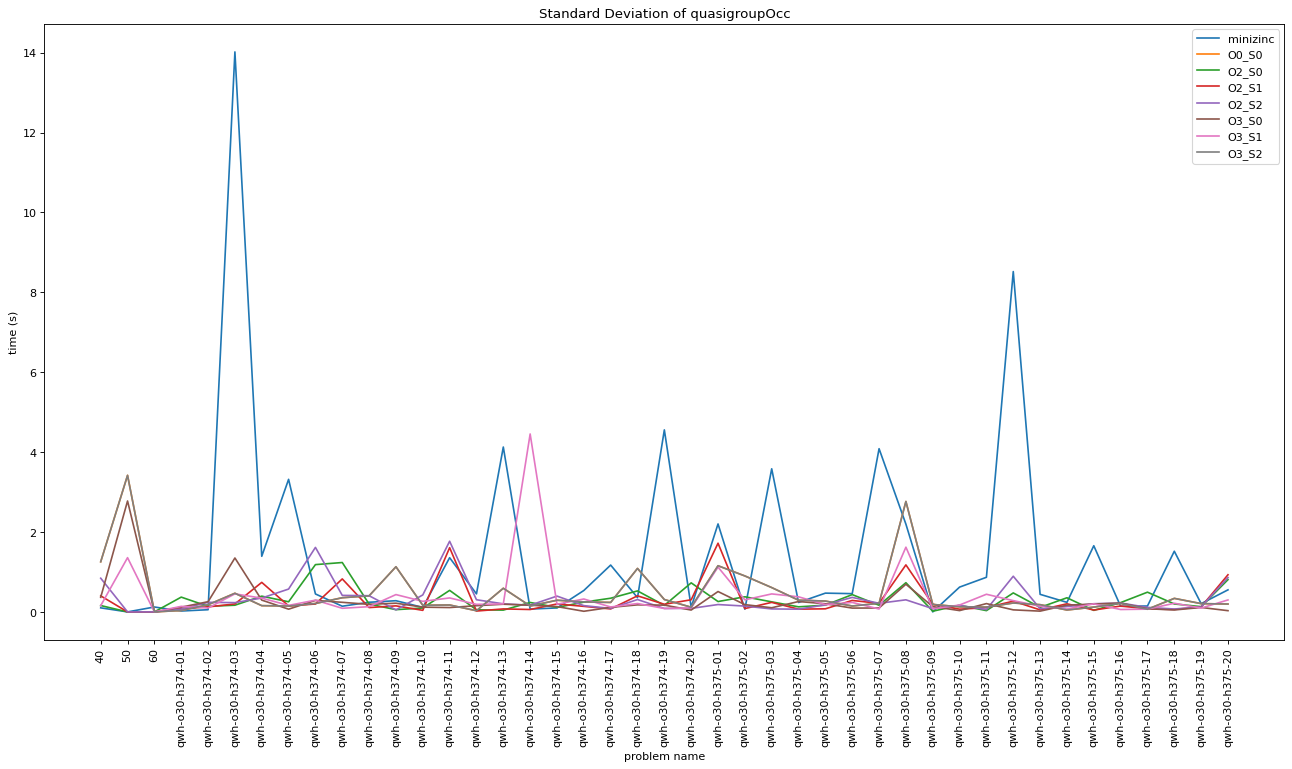

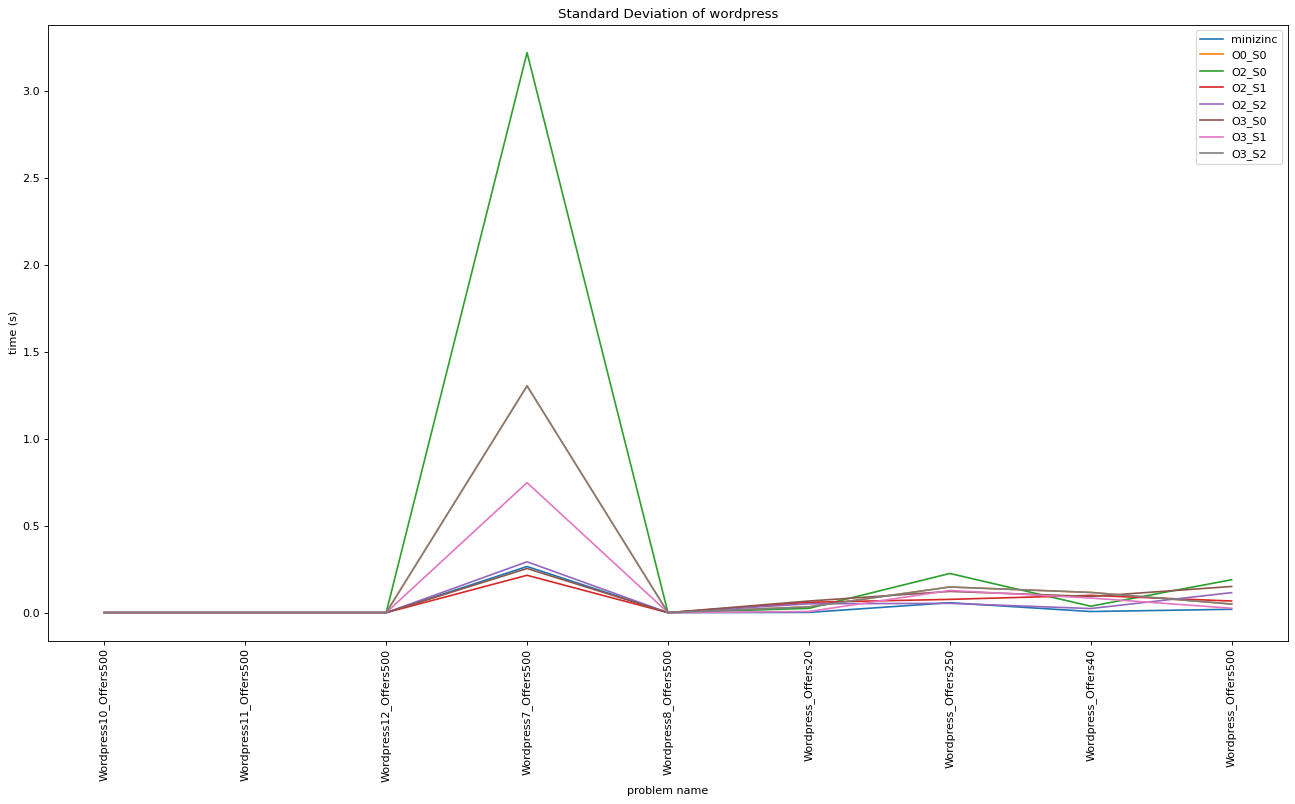

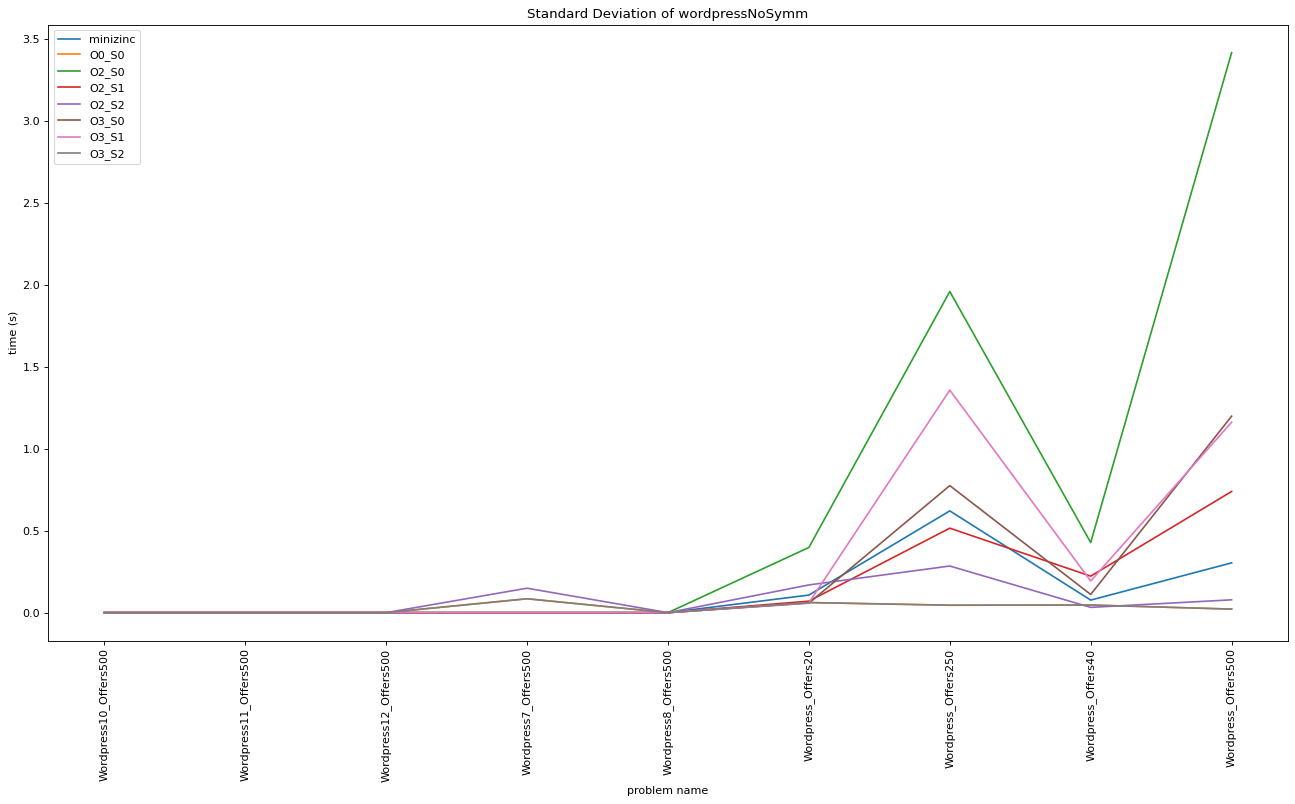

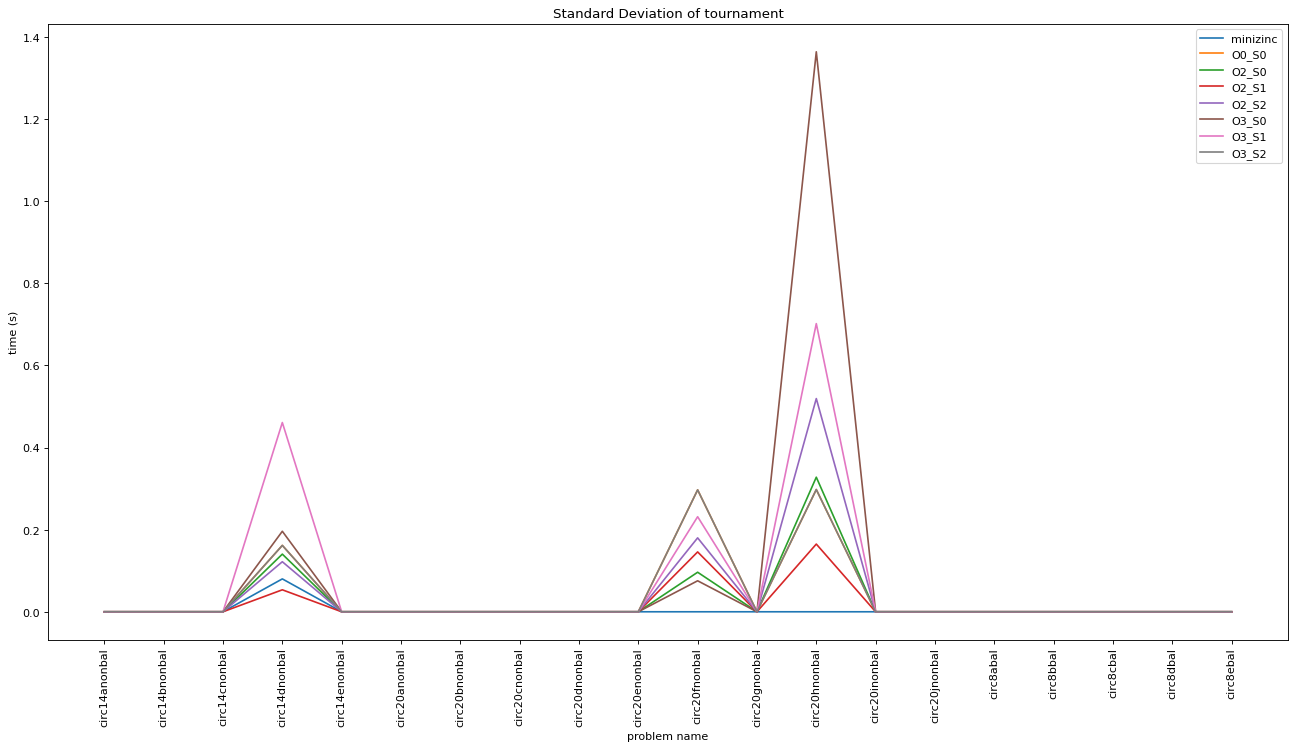

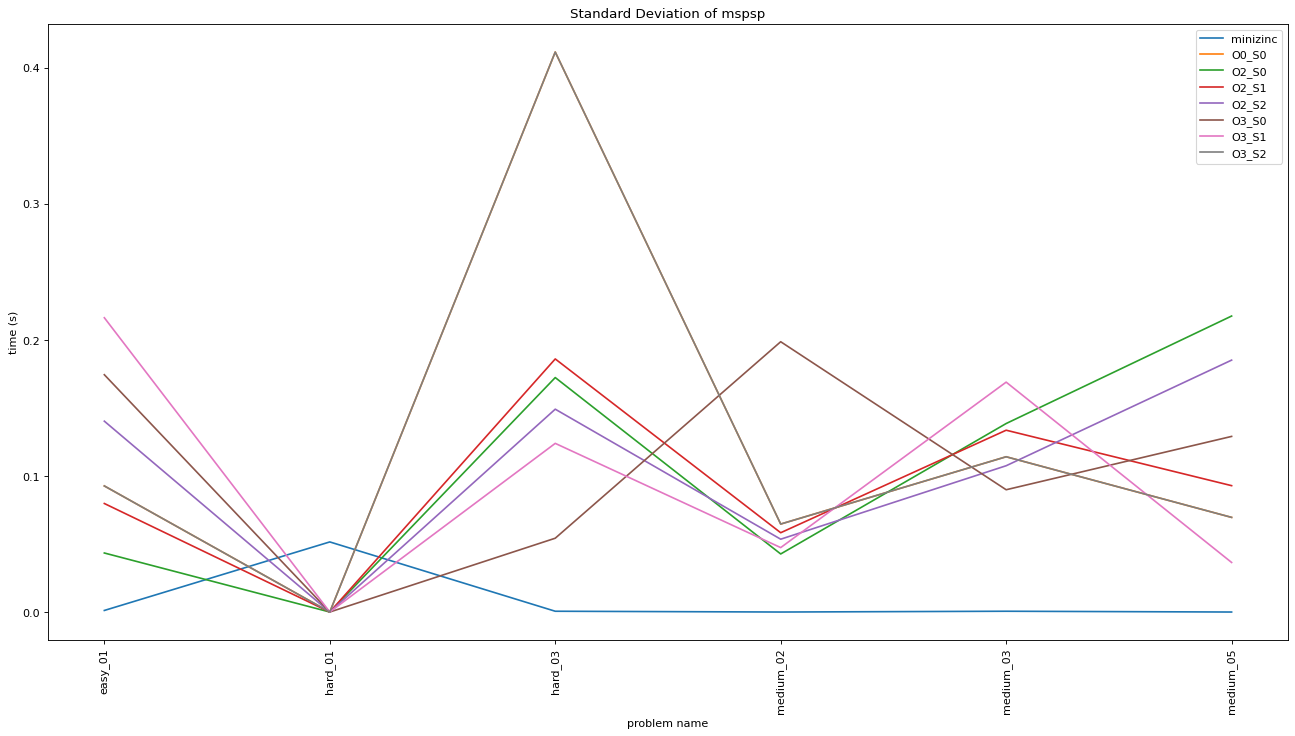

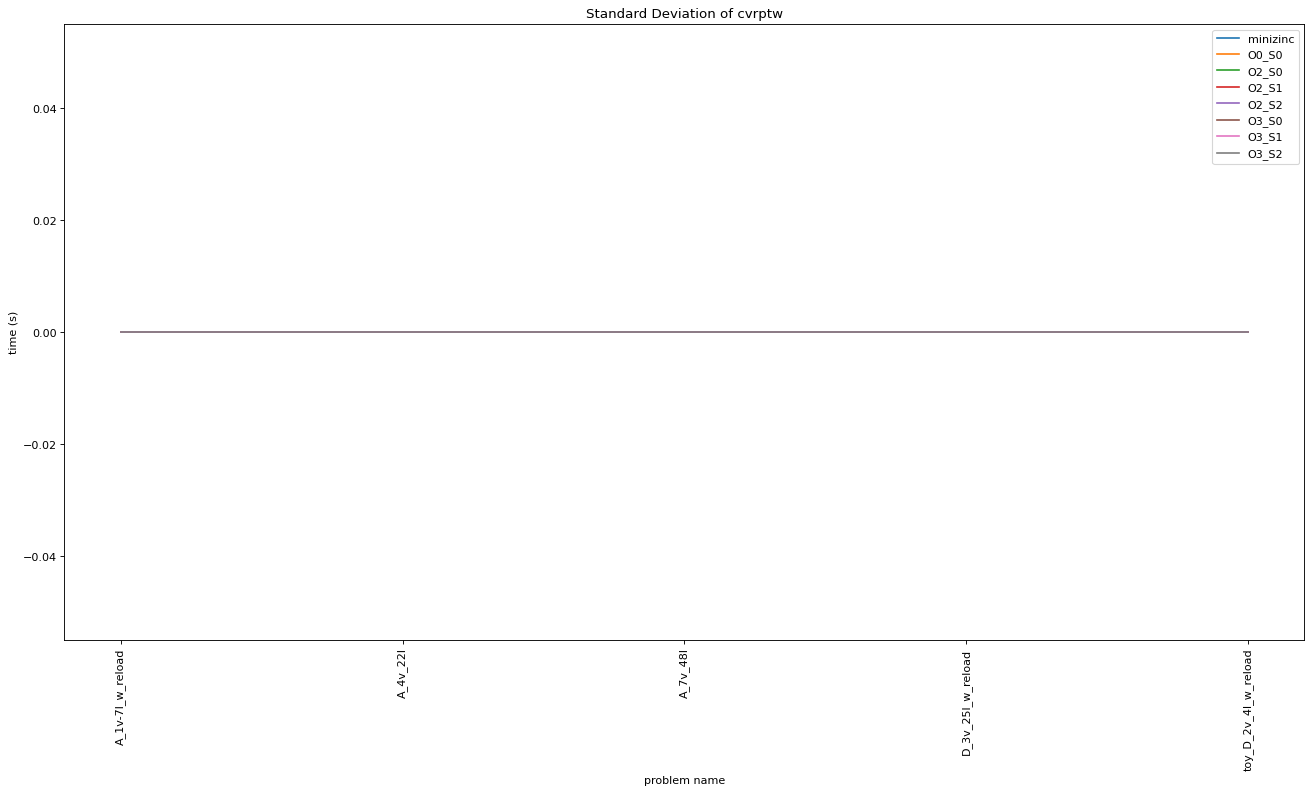

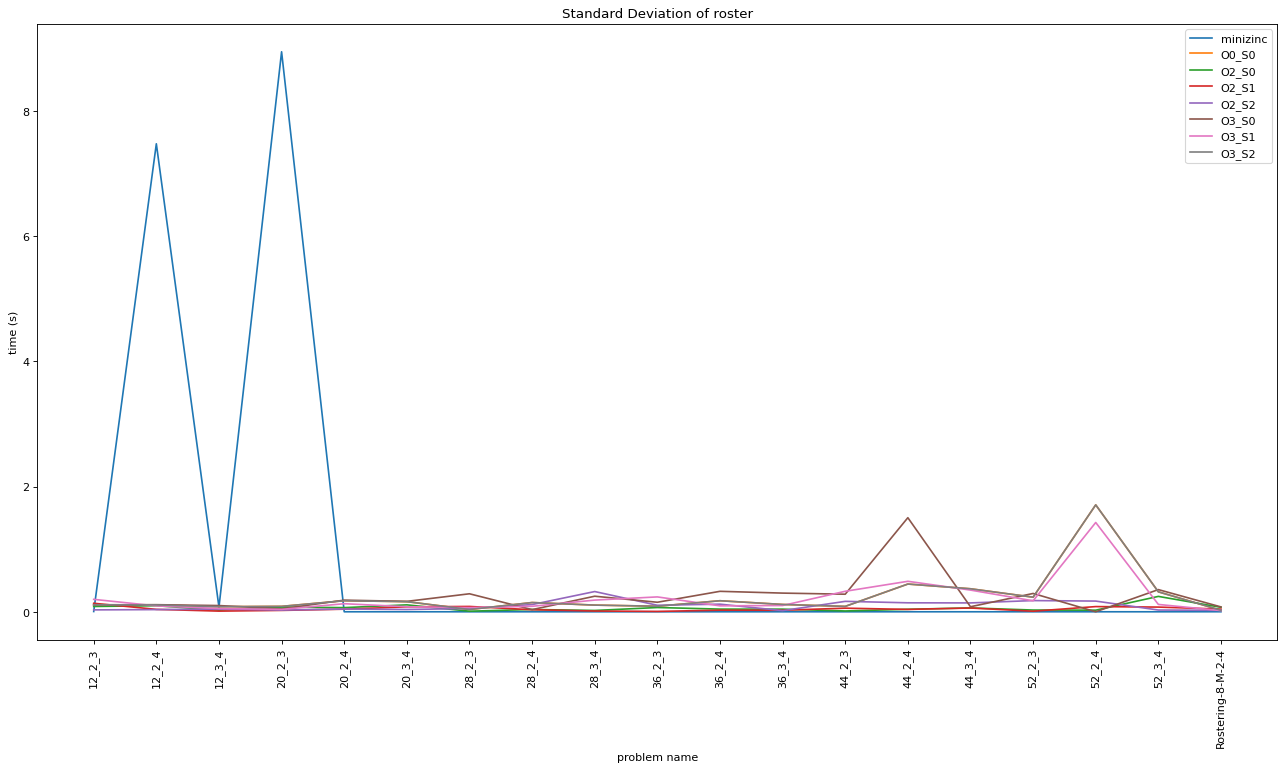

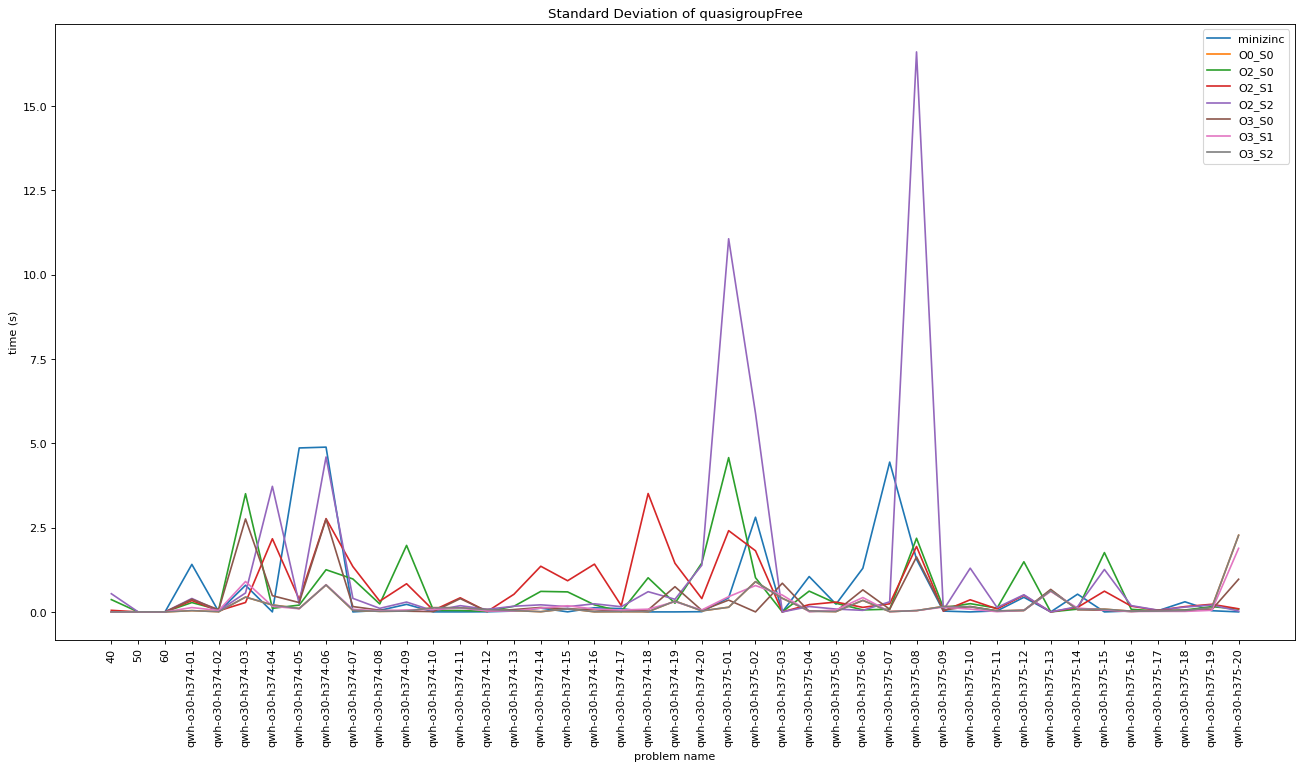

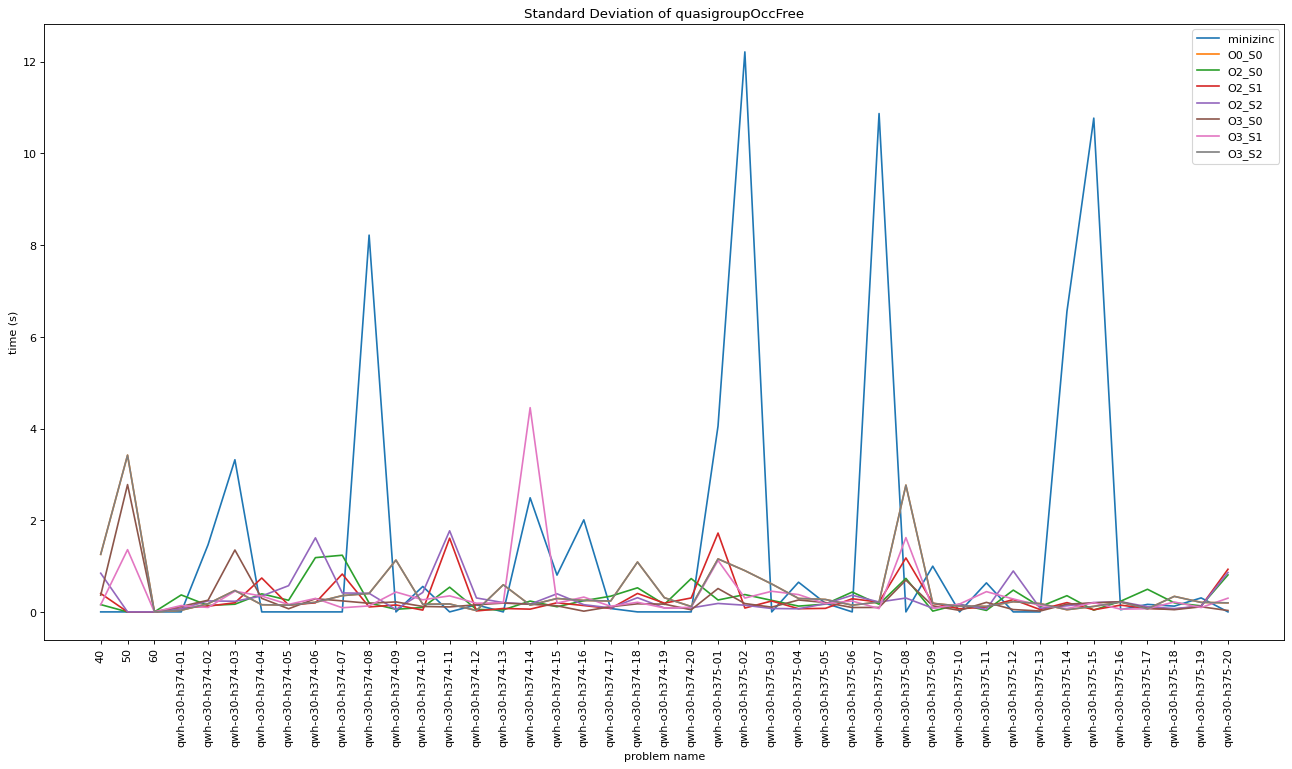

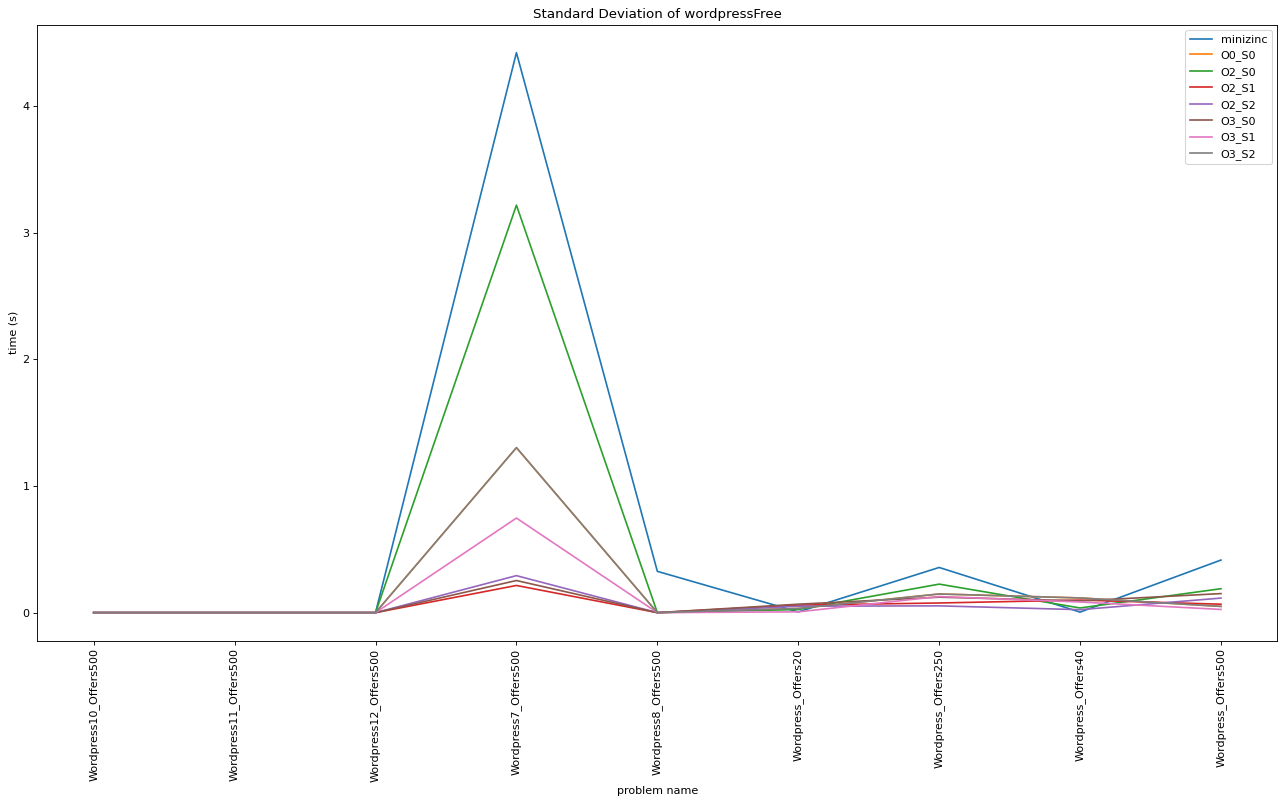

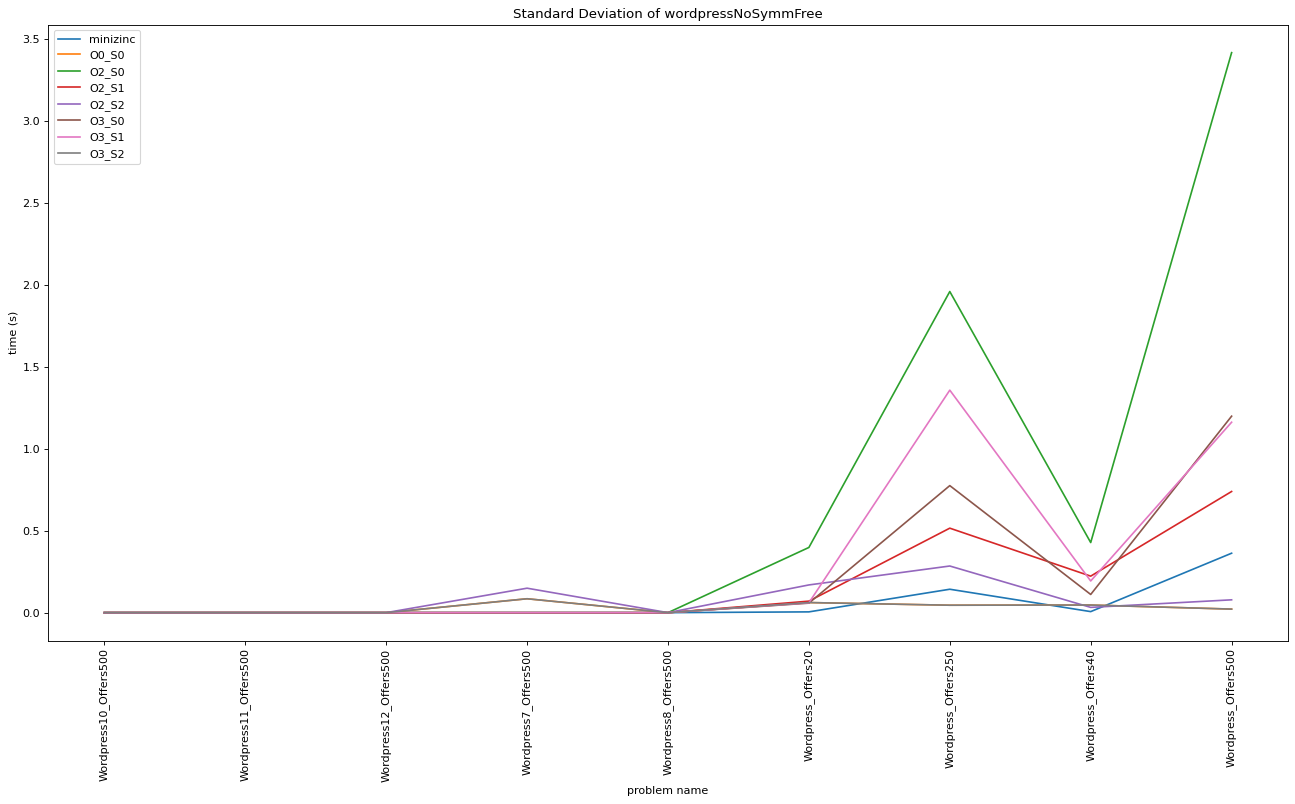

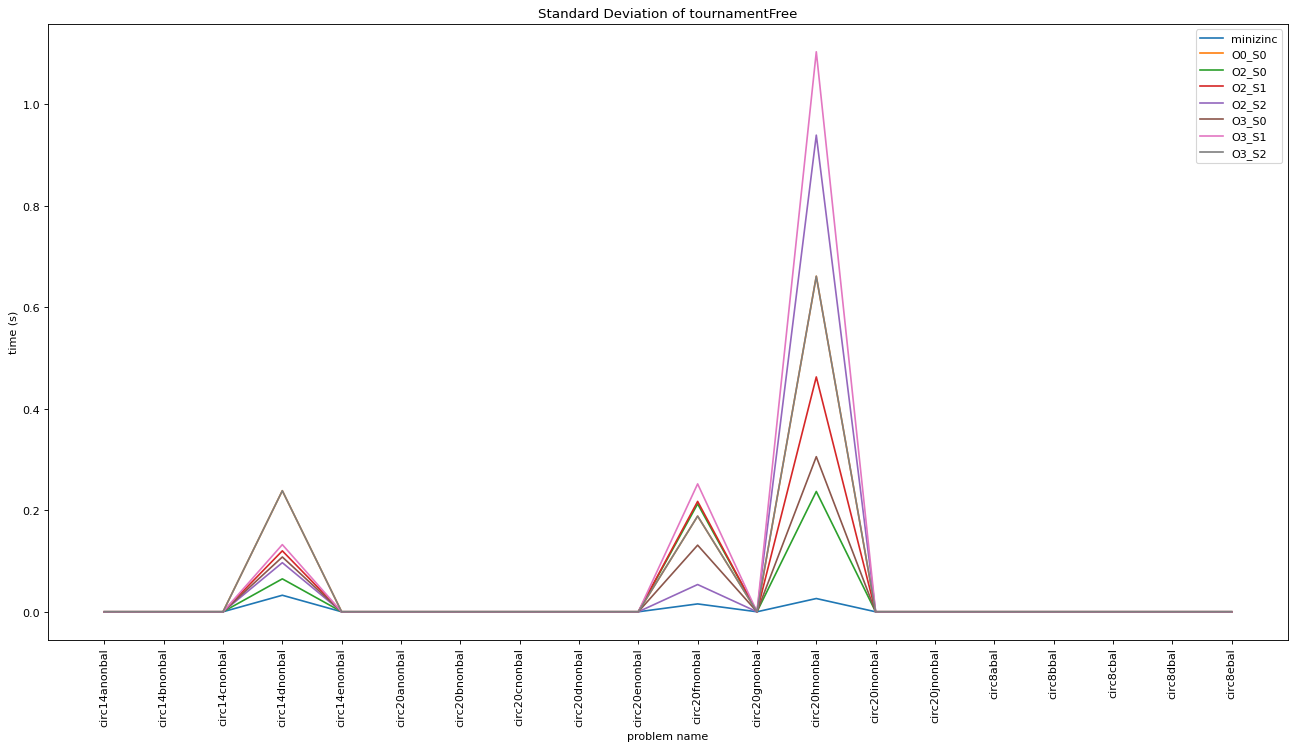

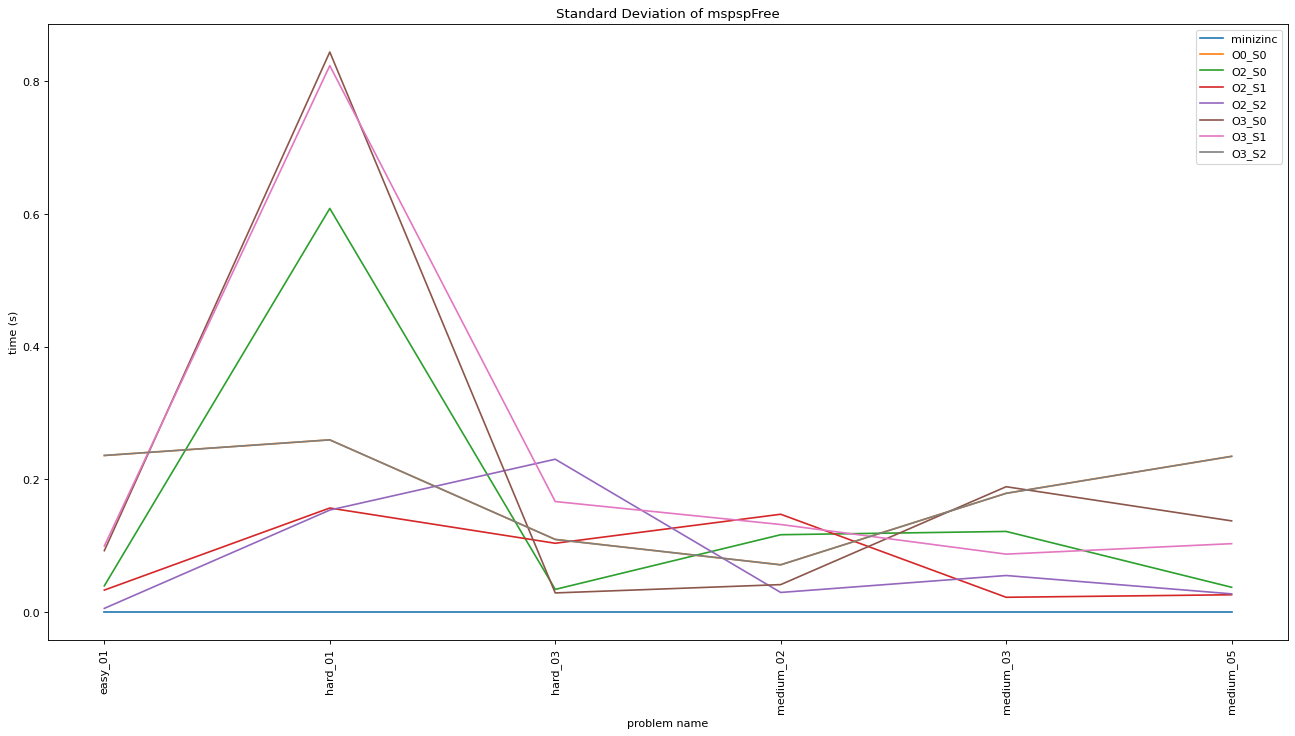

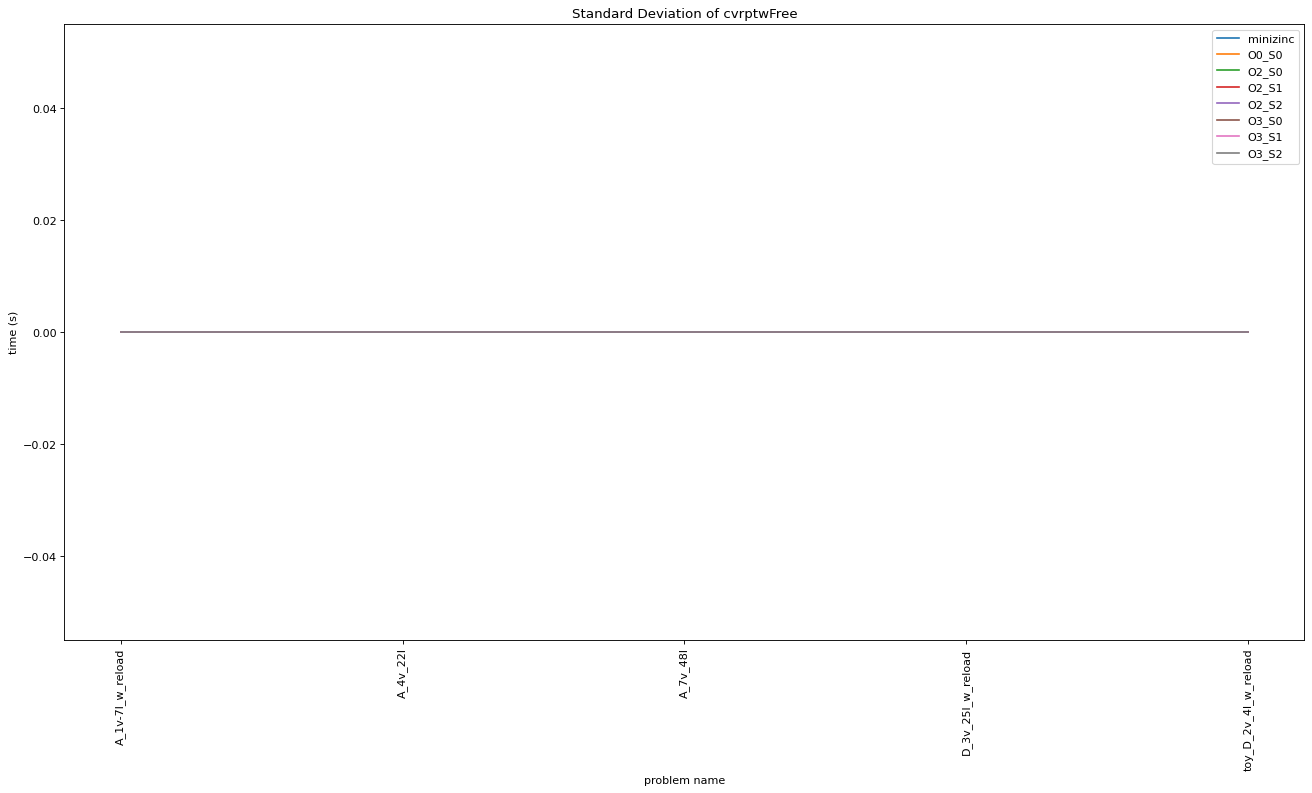

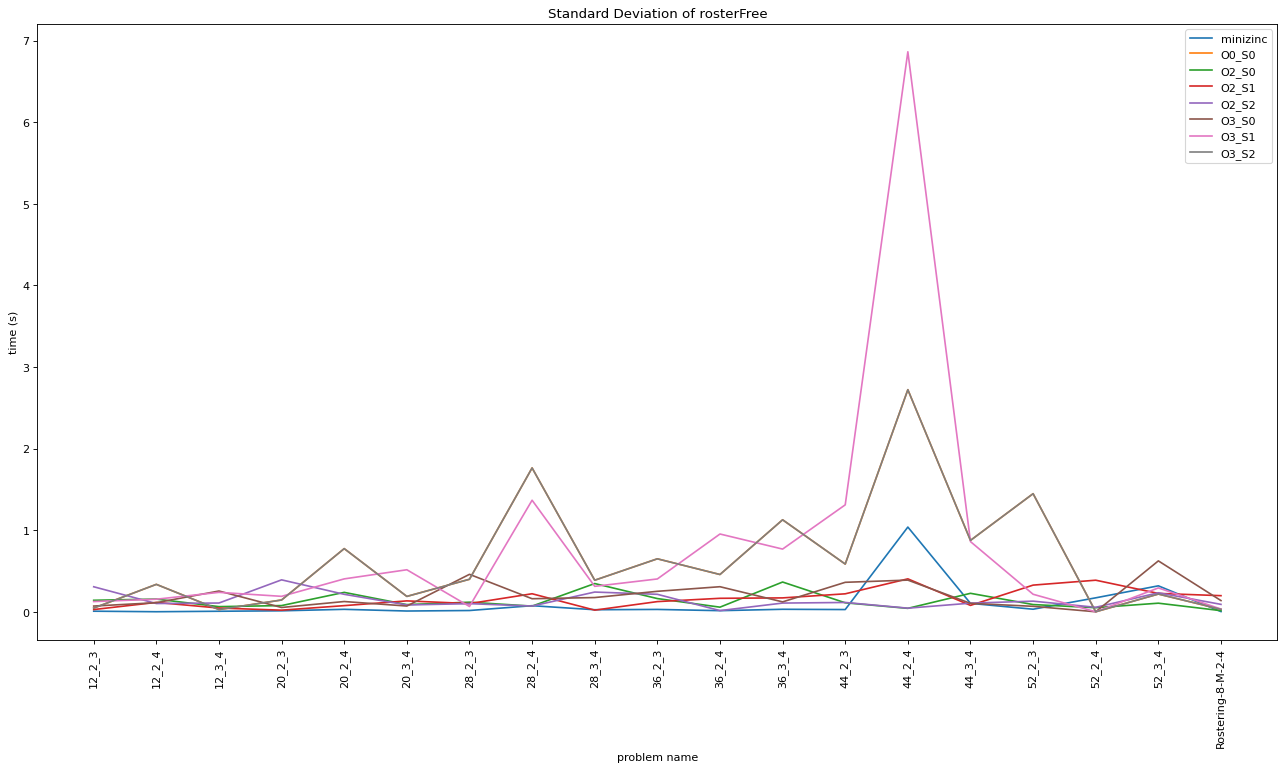

In [ ]:
def setupStdPlot(title):
    figure(figsize=(20, 10), dpi=80)
    plt.xlabel("problem name")
    plt.ylabel("time (s)")
    plt.xticks(rotation = 90)
    plt.title(title)

def plotStd(toGraph, opt=None, stdDevIndex=timingStdevIndex):
    xVals, yVals = toGraph[problemIndex], toGraph[stdDevIndex]
    xVals = [i.split(".")[0] for i in xVals]
    plt.plot(xVals, yVals, label=opt if opt else "minizinc")

for problem in problems:
    setupStdPlot("Standard Deviation of " + problem)
    plotStd(allMinizincTimings[problem])
    for opt in optimisations:
    # for opt in ["O0_S0"]:
        plotStd(allEprimeTimings[problem][opt], opt=opt)
    plt.legend(loc="best")
    